<a href="https://colab.research.google.com/github/nancymatijas/OSiRV-Projekt/blob/main/task_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import sys
import time
import cv2
import numpy as np
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
from skimage.transform import resize
import shutil
import nibabel as nib
from IPython.display import clear_output
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

import random

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# **NESTO**

In [4]:
imgs_dir='/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData_comb/'
all_dirs = glob (f'{imgs_dir}/*')
len (all_dirs)
all_dirs.sort()

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def shuffle_split(all_dirs, val_pct=0.1, test_pct=0.1, seed=42):
    seed_everything(seed)
    n_test = int(len(all_dirs) * test_pct)
    n_val = int(len(all_dirs) * val_pct)
    idx = np.random.permutation(len(all_dirs))
    all_dirs = np.array(all_dirs)[idx]
    test_dirs = all_dirs[:n_test]
    valid_dirs = all_dirs[n_test:n_test + n_val]
    train_dirs = all_dirs[n_test + n_val:]
    return train_dirs, valid_dirs, test_dirs

In [6]:
train_dirs, valid_dirs, test_dirs = shuffle_split(all_dirs)
print(len(train_dirs), len(valid_dirs), len(test_dirs))

297 36 36


In [7]:
class BratsDataset (Dataset):
    def __init__ (self, img_dirs, modality_types, transform = None):
        self.img_dirs = img_dirs
        self.transform = transform
        self.modality_types = modality_types

    def __len__ (self):
        return len (self.img_dirs)

    def __getitem__(self, index):
        imgs_path = self.img_dirs[index]
        patient_id = os.path.basename(imgs_path)
        image = self.concat_imgs(imgs_path)

        mask = np.array(Image.open(f'{imgs_path}/{patient_id}_SEG_combined.jpg'))
        mask = (mask / 255 * 4).round()
        mask = self.preprocess_mask_labels(mask)

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

         # Select only the first channel from the mask
        mask = mask[..., 0]
        return image.astype(float), mask.astype(float)

    ## Spajanje slika s id-om pacijenta
    def concat_imgs(self, path: str):
      patient_id = os.path.basename(path)
      types = []
      for modality_type in modality_types:
          img = np.array(Image.open(f'{path}/{patient_id}_{modality_type}_combined.jpg'))
          img = self.normalize(img)
          types.append(img)
      #return np.array(types)
      return np.array(types)[..., 0]

    ## Ova metoda pretvara izvornu masku segmentacije u one-hot kodiranu masku s četiri kanala koji predstavljaju različite regije tumora
    ## Cijeli tumor - WT, Tumorska jezgra - TC, Povećanje tumora - ET, Pozadina - BG
    def preprocess_mask_labels(self, mask: np.ndarray):
        mask_WT = np.zeros(mask.shape)
        mask_WT[mask == 2] = 1

        mask_TC = np.zeros(mask.shape)
        mask_TC[mask == 1] = 1

        mask_ET = np.zeros(mask.shape)
        mask_ET[mask == 3] = 1

        mask_BG = np.zeros(mask.shape)
        mask_BG[mask == 0] = 1

        mask = np.stack([mask_WT, mask_TC, mask_ET, mask_BG])
        return mask

    ## Normalizacija ulaznih podataka
    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        if np.max(data) == 0:
            return data
        if (np.max(data) - data_min) == 0:
            return data / data_min
        return (data - data_min) / (np.max(data) - data_min)

modality_types = ['FLAIR', 'T1', 'T1CE', 'T2']

In [8]:
batch_size = 8

#Datasets
train_ds = BratsDataset(train_dirs, modality_types)
valid_ds = BratsDataset(valid_dirs, modality_types)
test_ds = BratsDataset(test_dirs, modality_types)

#DataLoaders
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size = batch_size, shuffle = True)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = True)

print(len(train_dl),len(valid_dl), len(test_dl))

38 5 5


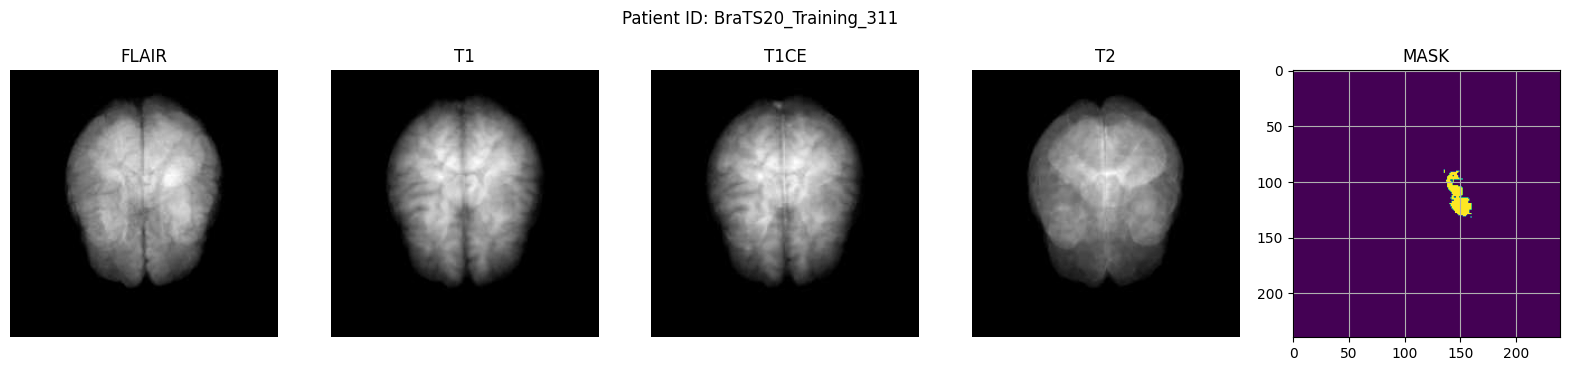

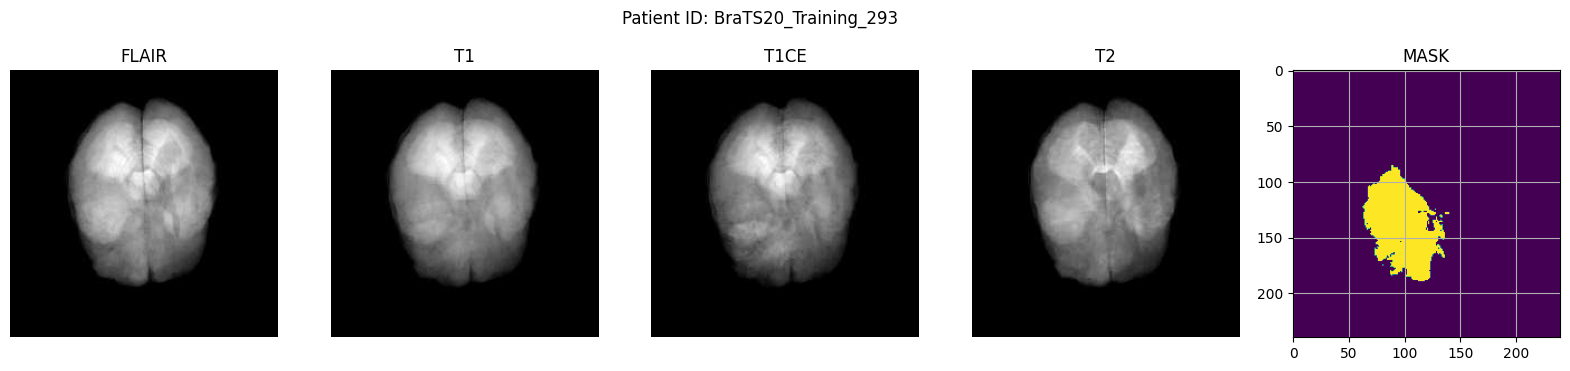

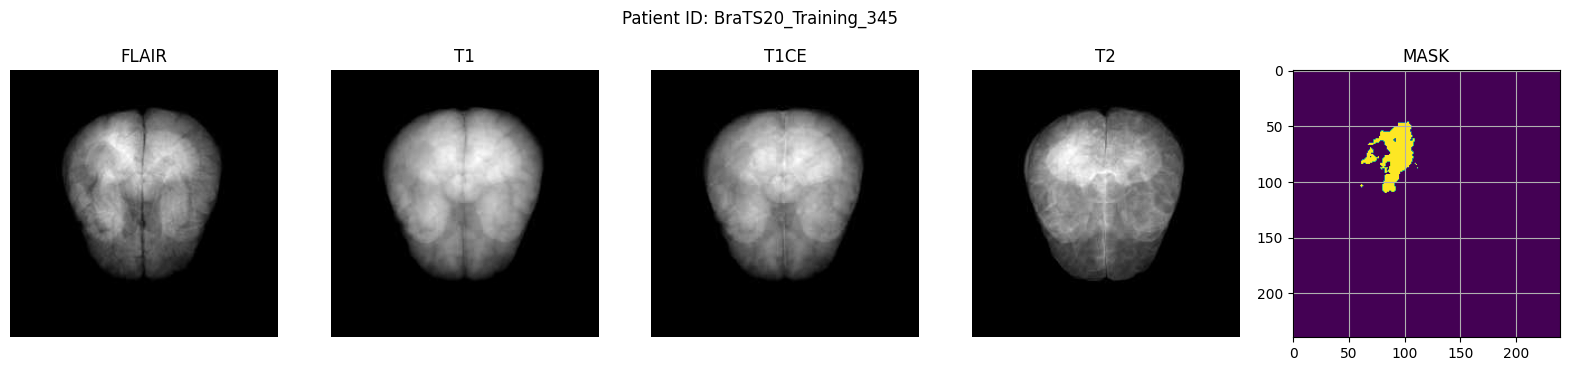

In [9]:
def visualize_samples(dataset, modality_types, num_samples):
    for i in range(num_samples):
        image, mask = dataset[i]

        # Extract patient ID
        patient_id = os.path.basename(dataset.img_dirs[i])

        # Create a single figure with one row and (len(modality_types) + 1) columns
        plt.figure(figsize=(20, 4))

        # Visualize all MRI modalities in the first len(modality_types) columns
        for j in range(len(modality_types)):
            plt.subplot(1, len(modality_types) + 1, j + 1)
            plt.imshow(image[j], cmap='gray')
            plt.axis('off')
            plt.title(f"{modality_types[j]}")

        # Visualize mask in the last column
        plt.subplot(1, len(modality_types) + 1, len(modality_types) + 1)
        plt.imshow(mask[1], cmap='viridis')
        plt.grid()
        plt.title("MASK")

        plt.suptitle(f"Patient ID: {patient_id}")
        plt.show()

# Prikazivanje uzoraka u istom redu
visualize_samples(train_ds, modality_types, num_samples=3)

In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.down5 = Down(1024,2048)

        self.up0 = Up(2048,1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)

        x = self.up0(x6,x5)
        x = self.up1(x, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [11]:
## Računa Dice koeficijent za binarnu segmentaciju između predviđenih vjerojatnosti (probabilities) i stvarnih oznaka (truth)
## Dice koeficijent mjeri sličnost između predviđenih i stvarnih područja
def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)

## Računa Jaccard koeficijent za binarnu segmentaciju između predviđenih vjerojatnosti i stvarnih oznaka
## Jaccard koeficijent mjeri sličnost između predviđenih i stvarnih područja
def jaccard_coef_metric(probabilities: torch.Tensor,
               truth: torch.Tensor,
               treshold: float = 0.5,
               eps: float = 1e-9) -> np.ndarray:
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)

In [12]:
## Klasa koja služi za praćenje i ažuriranje Dice i Jaccard koeficijenata tijekom evaluacije modela
class Meter:
    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []

    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)

        self.dice_scores.append(dice)
        self.iou_scores.append(iou)

    def get_metrics(self) -> np.ndarray:
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou

In [13]:
def bce_dice_loss(input, target, alpha, beta, smooth=1):
    # BCE loss
    bce_loss = F.binary_cross_entropy_with_logits(input, target)

    # Dice loss
    input = torch.sigmoid(input)
    input_flat = input.view(-1)
    target_flat = target.view(-1)
    intersection = (input_flat * target_flat).sum()
    dice_loss = 1 - (2 * intersection + smooth) / (input_flat.sum() + target_flat.sum() + smooth)

    # Combined loss
    loss = alpha * bce_loss + beta * dice_loss

    return loss

In [14]:
class Trainer:
    def __init__(self,
                 net: nn.Module,
                 train_dl: DataLoader,
                 val_dl: DataLoader,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 num_epochs: int,
                 display_plot: bool = True,

                ):

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr, betas=(0.9,0.999))
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs
        self.dataloaders = {
            "train": train_dl,
            "val"  : val_dl
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.jaccard_scores = {phase: [] for phase in self.phases}

    def _compute_loss_and_outputs(self, images: torch.Tensor, targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images.float())
        loss = bce_dice_loss(logits, targets, alpha=0.5, beta=0.5)
        return loss, logits

    def _do_epoch(self, epoch: int, phase: str):
        self.net.train() if phase == "train" else self.net.eval()
        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()

        for itr, (images, targets) in enumerate(tqdm(dataloader, desc=f"{phase} epoch {epoch + 1}/{self.num_epochs}")):
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            meter.update(logits.detach().cpu(), targets.detach().cpu())

        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou = meter.get_metrics()

        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)

        print(f"Loss: {epoch_loss:.4f} | Dice: {epoch_dice:.4f} | IoU: {epoch_iou:.4f}")
        return epoch_loss

    ## Pokretanje treniranja kroz sve epohe
    def run(self):
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
            if self.display_plot:
                self._plot_train_history()

            if val_loss < self.best_loss:
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), "best_model.pth")
            print()
        self._save_train_history()

    ## Prikaz grafa gubitaka, Dice i Jaccard koeficijenata tijekom treninga i validacije
    def _plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores]
        colors = ['pink', 'violet']
        labels = [
            f"Train Loss: {self.losses['train'][-1]:.4f} \nValidation Loss: {self.losses['val'][-1]:.4f}",
            f"Train Dice: {self.dice_scores['train'][-1]:.4f} \nValidation Dice: {self.dice_scores['val'][-1]:.4f}",
            f"Train Jaccard: {self.jaccard_scores['train'][-1]:.4f} \nValidation Jaccard: {self.jaccard_scores['val'][-1]:.4f}"
        ]

        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))

            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="Validation")
                ax.plot(data[i]['train'], c=colors[1], label="Training")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")

            plt.tight_layout()
            plt.show()

    ## Spremanje težine modela i rezultate treniranja
    def _save_train_history(self):
        torch.save(self.net.state_dict(),
                   f"last_epoch_model.pth")

        logs_ = [self.losses, self.dice_scores, self.jaccard_scores]
        log_names_ = ["_loss", "_dice", "_jaccard"]
        logs = [logs_[i][key] for i in list(range(len(logs_)))
                         for key in logs_[i]]
        log_names = [key+log_names_[i]
                     for i in list(range(len(logs_)))
                     for key in logs_[i]
                    ]
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv("train_log.csv", index=False)

In [15]:
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=4, n_classes=4).to(device)

In [16]:
trainer = Trainer(net = model,
                  train_dl = train_dl,
                  val_dl = valid_dl,
                  lr = 1e-5,
                  accumulation_steps = batch_size,
                  batch_size = batch_size,
                  num_epochs = 70,
                 )

device: cuda


train epoch 1/70: 100%|██████████| 38/38 [08:03<00:00, 12.71s/it]


Loss: 0.6848 | Dice: 0.4621 | IoU: 0.3011


val epoch 1/70: 100%|██████████| 5/5 [00:51<00:00, 10.21s/it]


Loss: 0.6800 | Dice: 0.4132 | IoU: 0.2605


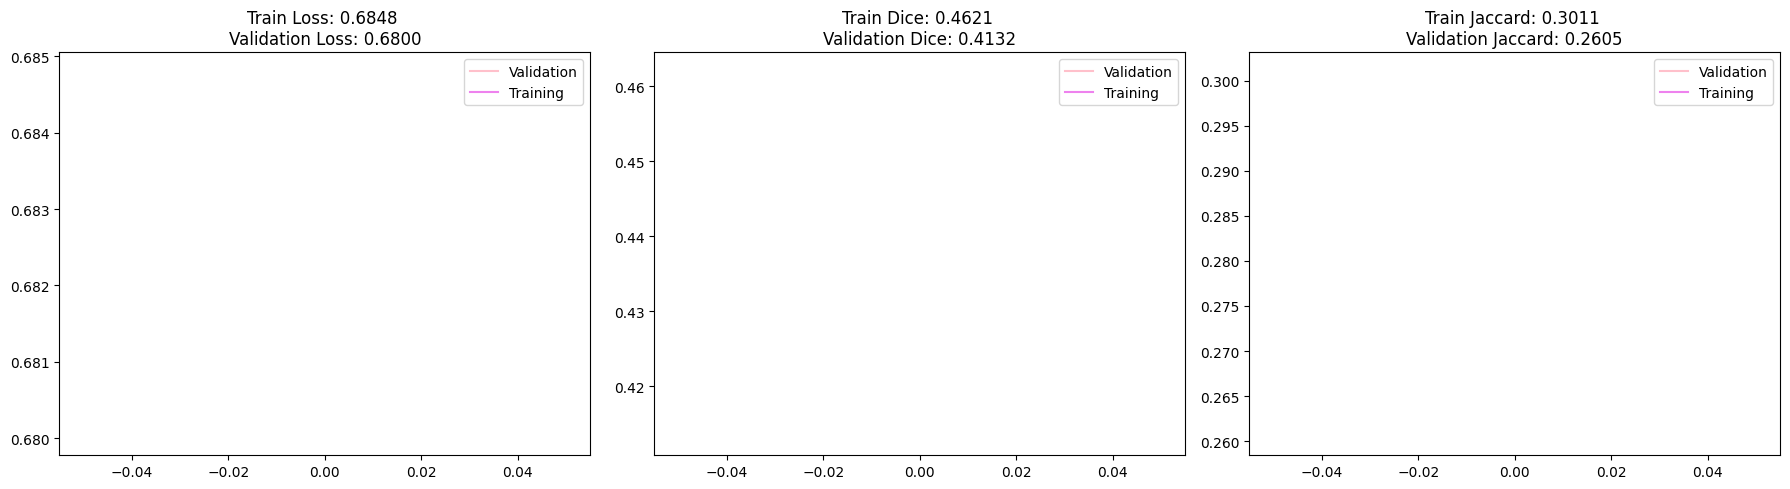

train epoch 2/70: 100%|██████████| 38/38 [00:26<00:00,  1.46it/s]


Loss: 0.6463 | Dice: 0.5841 | IoU: 0.4150


val epoch 2/70: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s]


Loss: 0.6272 | Dice: 0.6352 | IoU: 0.4661


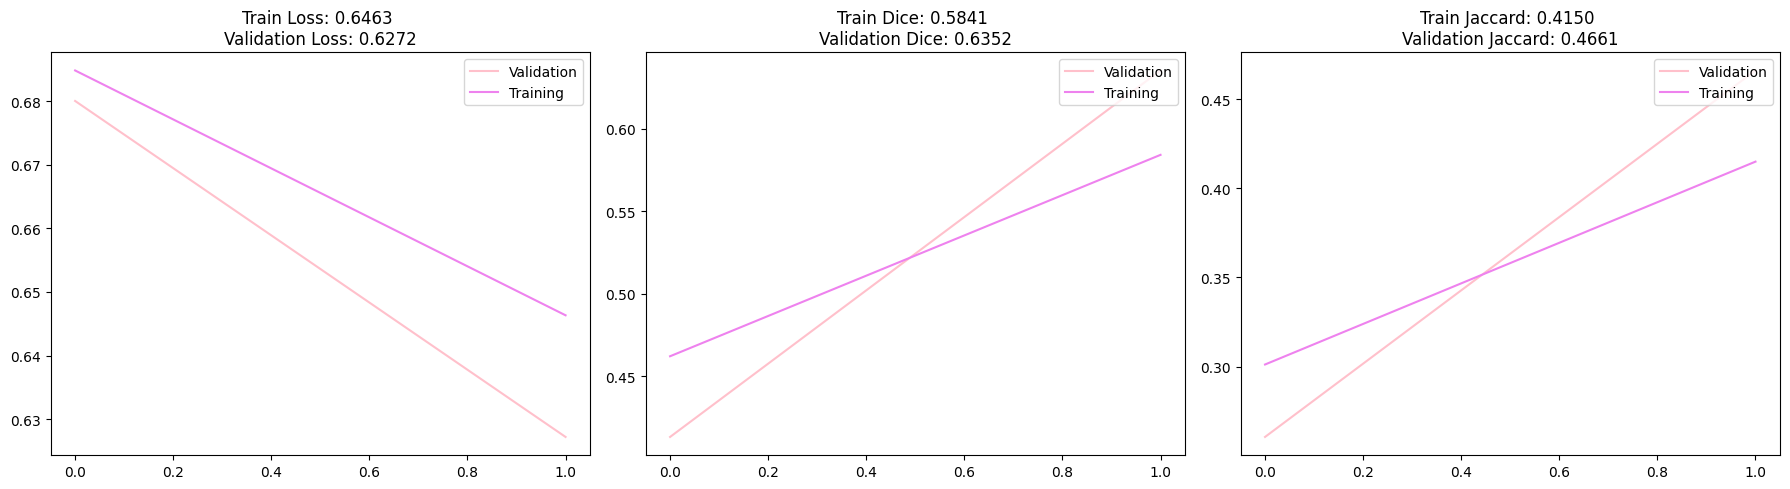

train epoch 3/70: 100%|██████████| 38/38 [00:26<00:00,  1.44it/s]


Loss: 0.6183 | Dice: 0.6846 | IoU: 0.5218


val epoch 3/70: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


Loss: 0.6063 | Dice: 0.7022 | IoU: 0.5418


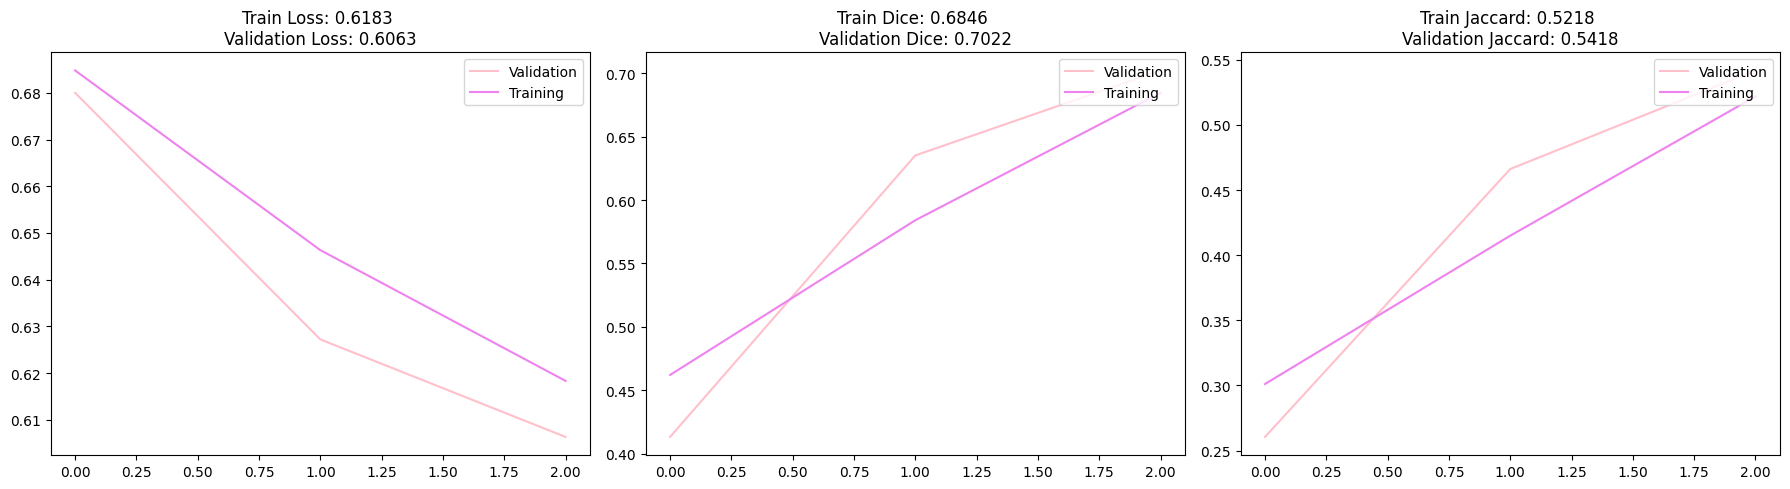

train epoch 4/70: 100%|██████████| 38/38 [00:26<00:00,  1.41it/s]


Loss: 0.6001 | Dice: 0.7423 | IoU: 0.5917


val epoch 4/70: 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


Loss: 0.5926 | Dice: 0.8055 | IoU: 0.6748


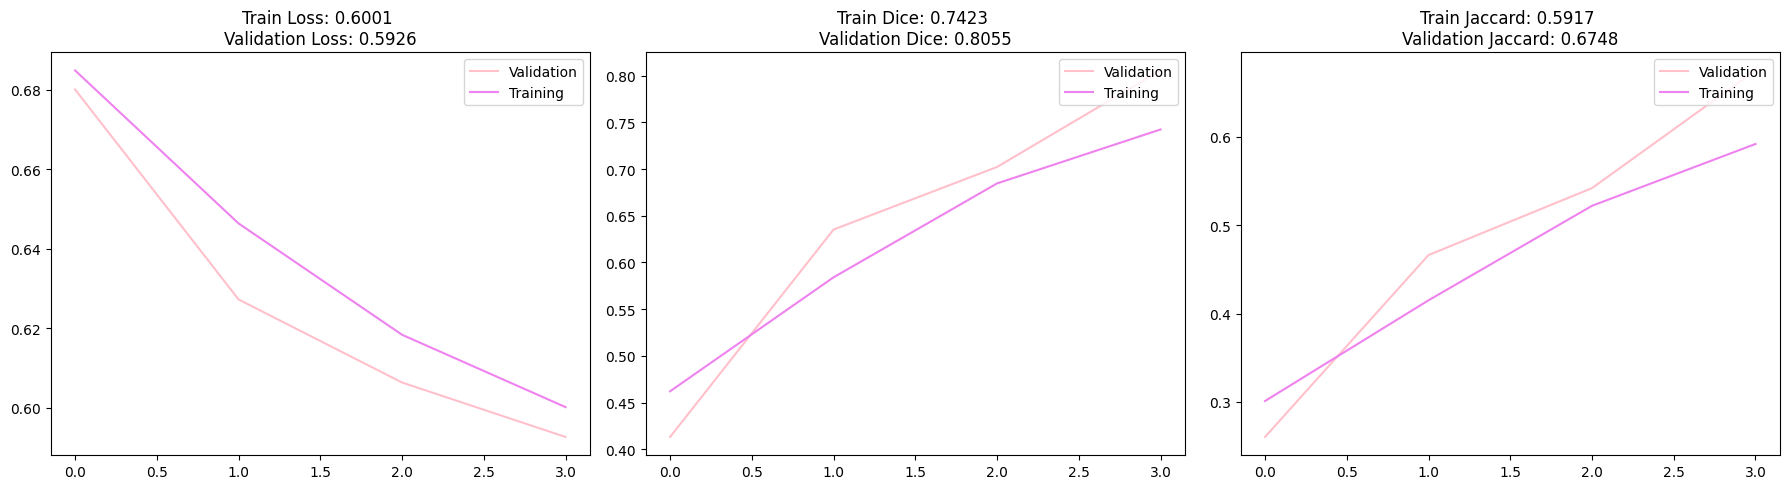

train epoch 5/70: 100%|██████████| 38/38 [00:26<00:00,  1.43it/s]


Loss: 0.5887 | Dice: 0.8219 | IoU: 0.6983


val epoch 5/70: 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


Loss: 0.5831 | Dice: 0.8339 | IoU: 0.7154


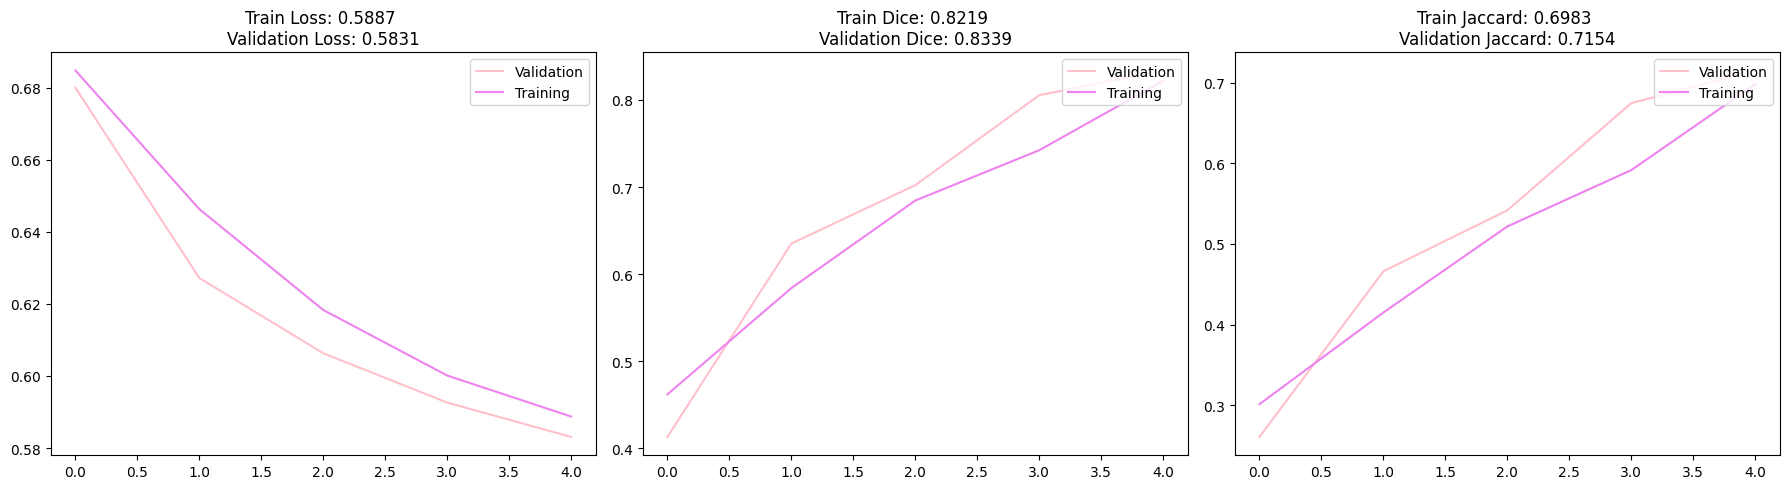

train epoch 6/70: 100%|██████████| 38/38 [00:27<00:00,  1.39it/s]


Loss: 0.5810 | Dice: 0.8403 | IoU: 0.7249


val epoch 6/70: 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]


Loss: 0.5766 | Dice: 0.8456 | IoU: 0.7328


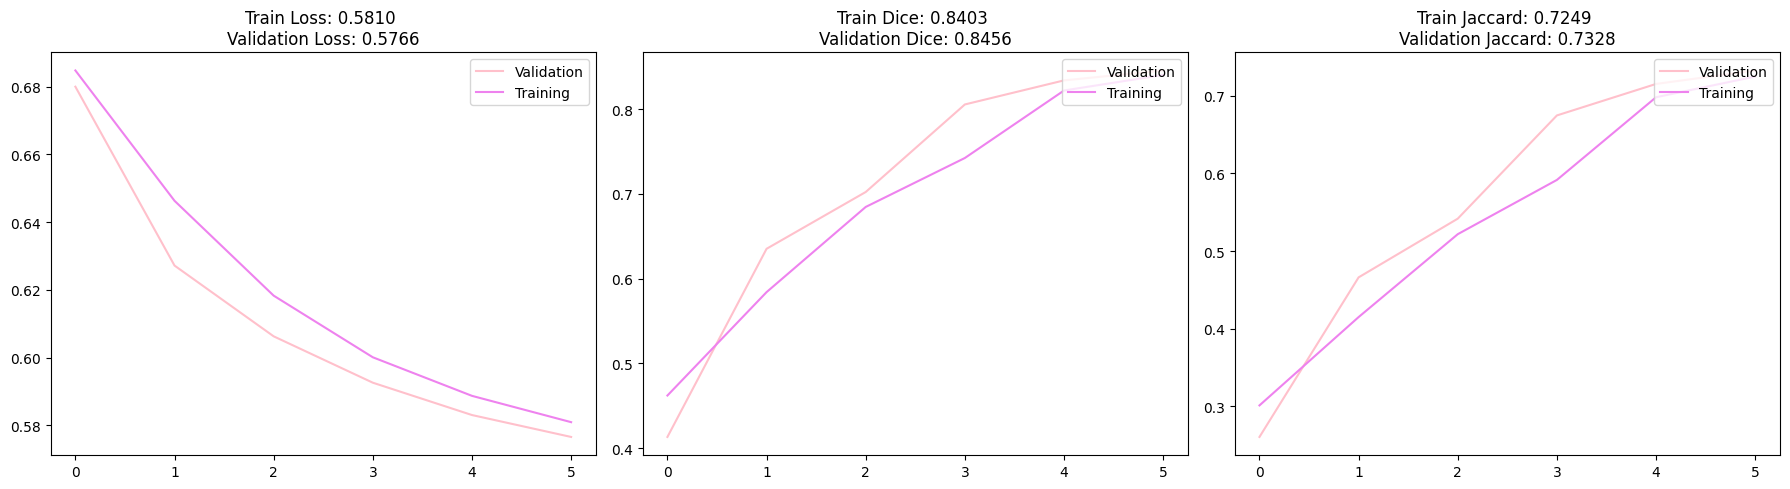

train epoch 7/70: 100%|██████████| 38/38 [00:26<00:00,  1.42it/s]


Loss: 0.5748 | Dice: 0.8516 | IoU: 0.7417


val epoch 7/70: 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]


Loss: 0.5737 | Dice: 0.8538 | IoU: 0.7451


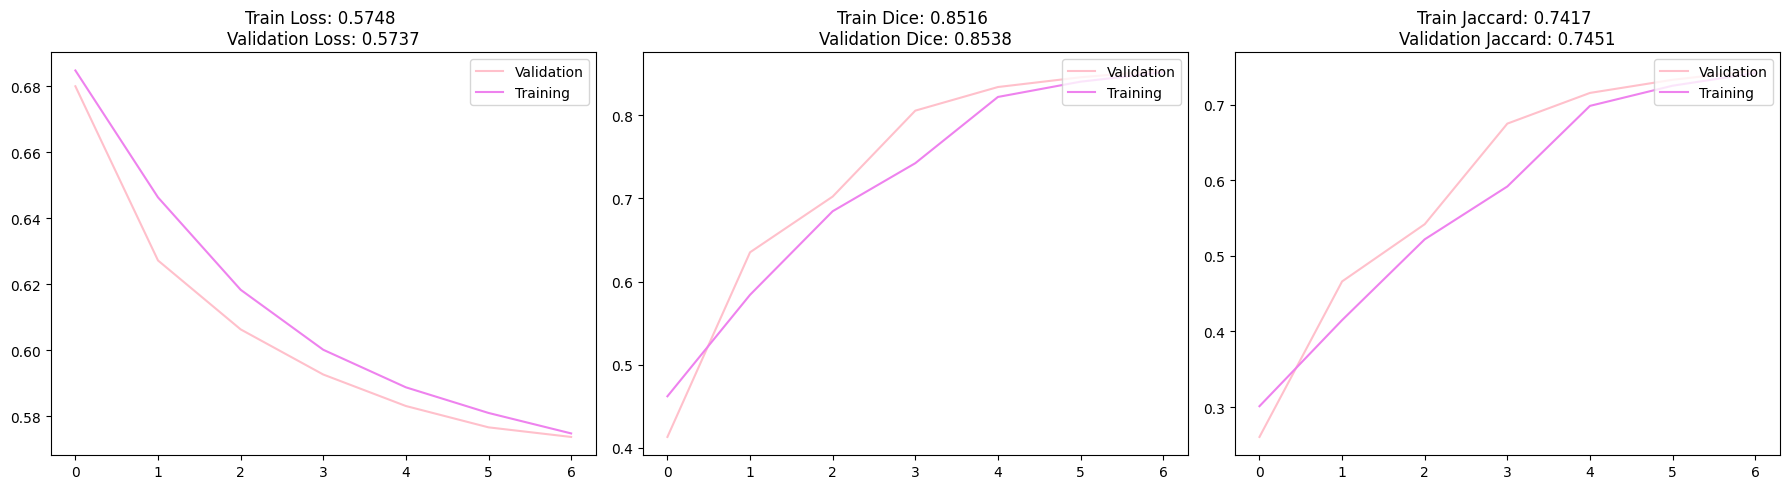

train epoch 8/70: 100%|██████████| 38/38 [00:27<00:00,  1.39it/s]


Loss: 0.5695 | Dice: 0.8609 | IoU: 0.7559


val epoch 8/70: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


Loss: 0.5694 | Dice: 0.8598 | IoU: 0.7544


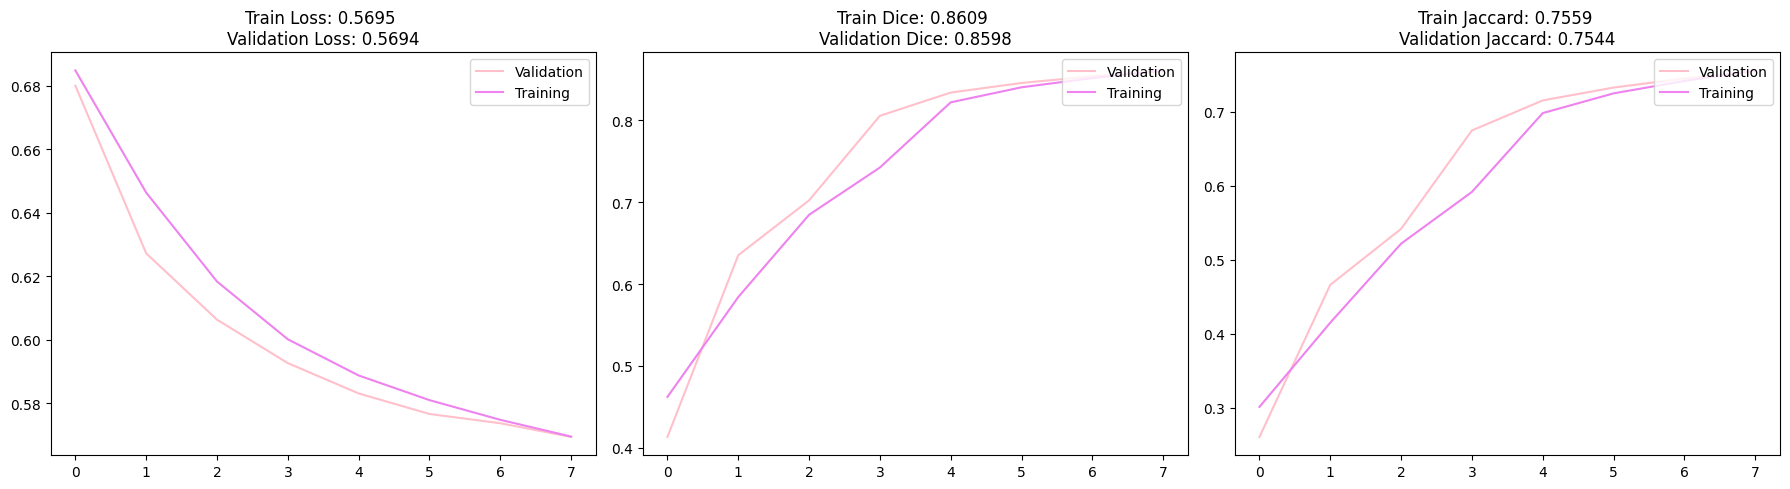

train epoch 9/70: 100%|██████████| 38/38 [00:26<00:00,  1.42it/s]


Loss: 0.5652 | Dice: 0.8702 | IoU: 0.7704


val epoch 9/70: 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


Loss: 0.5644 | Dice: 0.8689 | IoU: 0.7685


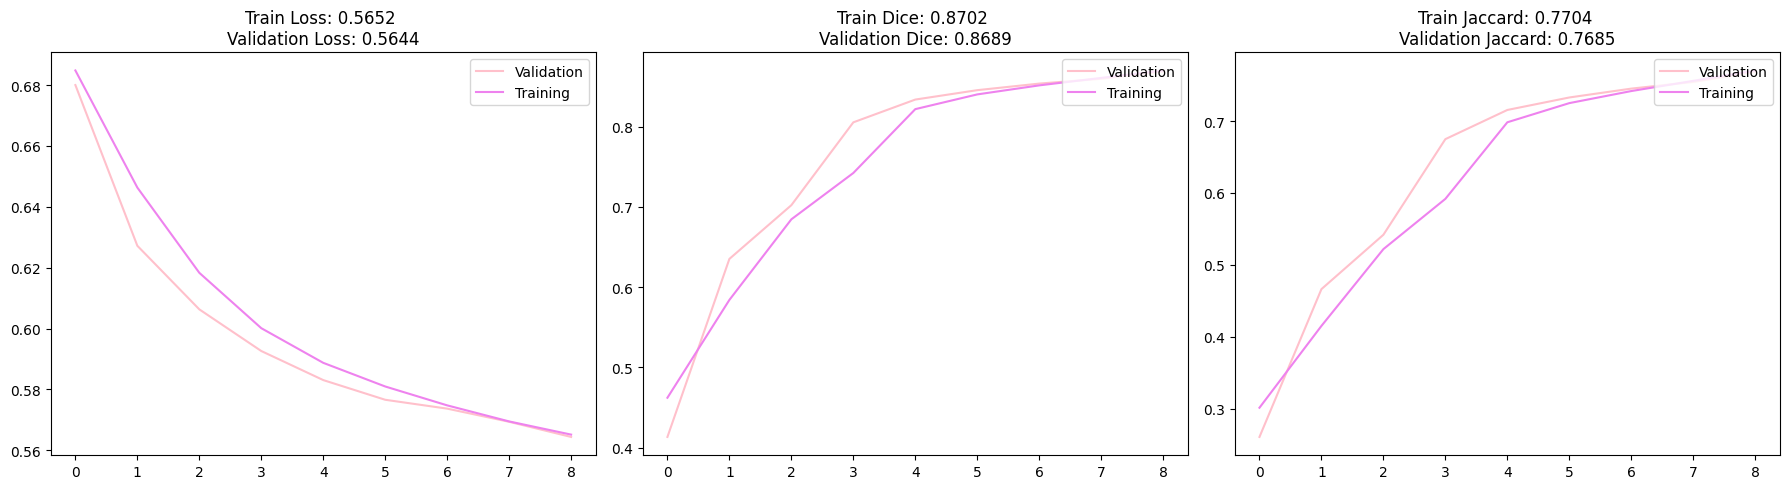

train epoch 10/70: 100%|██████████| 38/38 [00:27<00:00,  1.41it/s]


Loss: 0.5630 | Dice: 0.8773 | IoU: 0.7817


val epoch 10/70: 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]


Loss: 0.5598 | Dice: 0.8806 | IoU: 0.7869


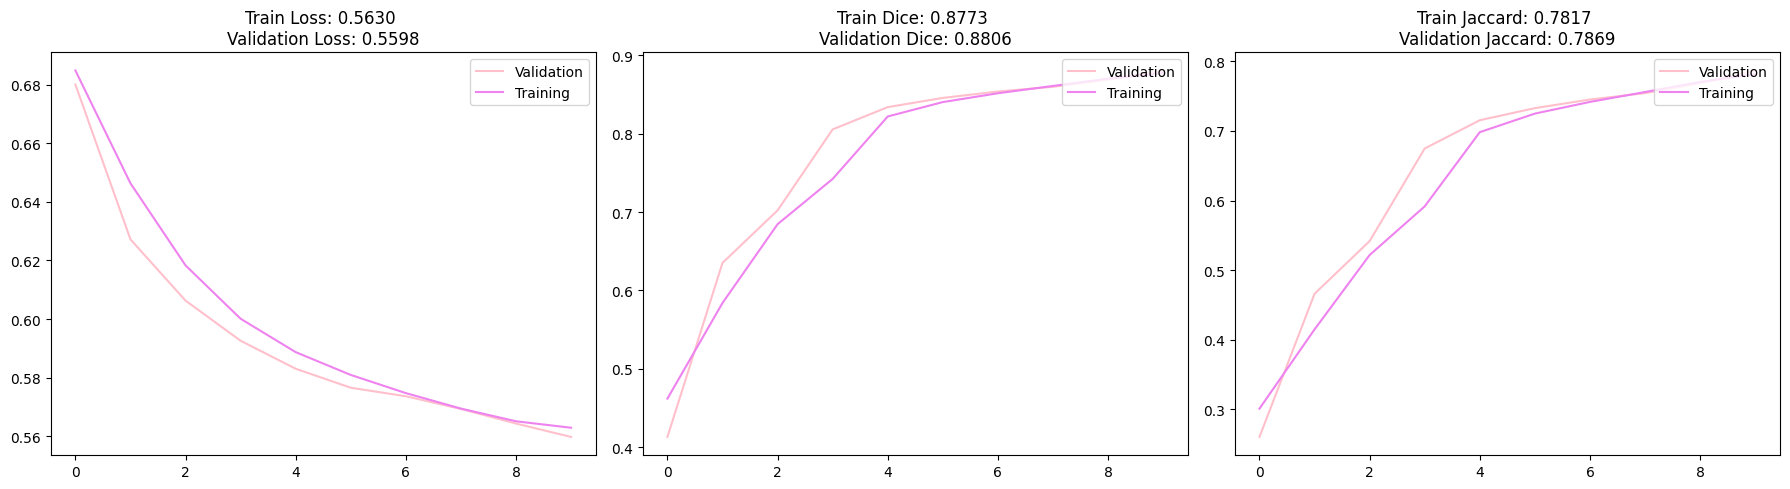

train epoch 11/70: 100%|██████████| 38/38 [00:27<00:00,  1.39it/s]


Loss: 0.5582 | Dice: 0.8930 | IoU: 0.8069


val epoch 11/70: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


Loss: 0.5573 | Dice: 0.8984 | IoU: 0.8159


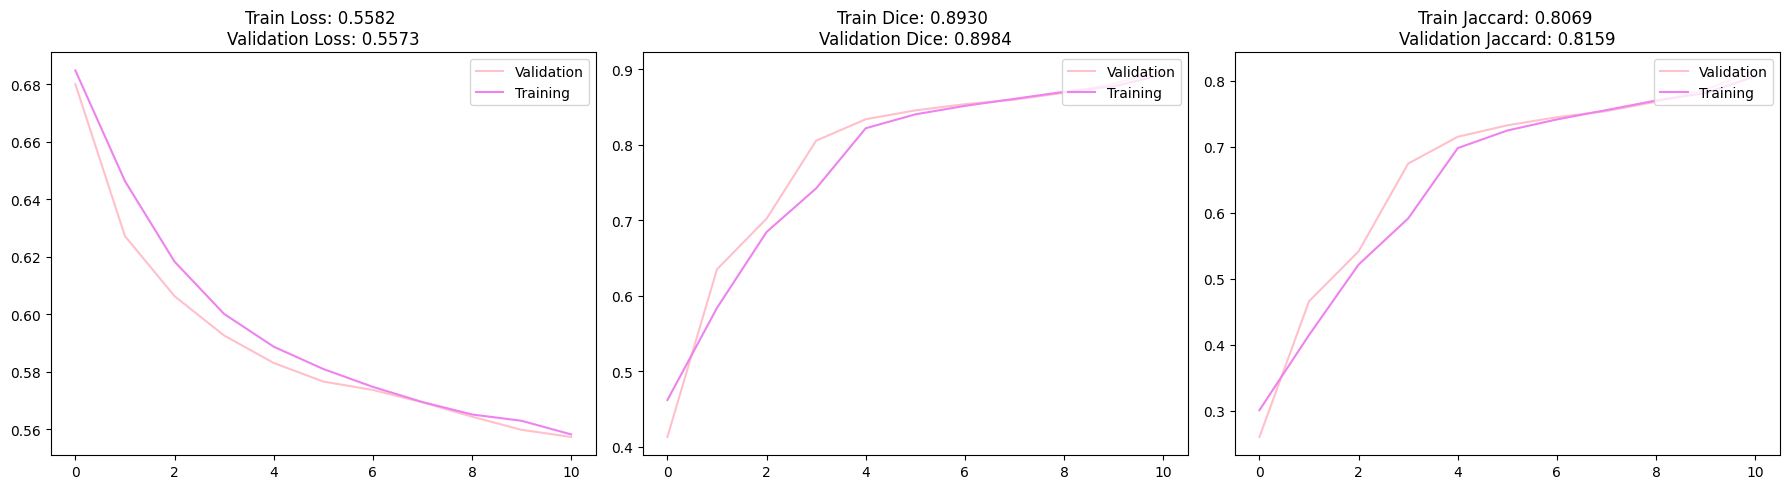

train epoch 12/70: 100%|██████████| 38/38 [00:26<00:00,  1.41it/s]


Loss: 0.5544 | Dice: 0.9090 | IoU: 0.8335


val epoch 12/70: 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


Loss: 0.5547 | Dice: 0.9166 | IoU: 0.8464


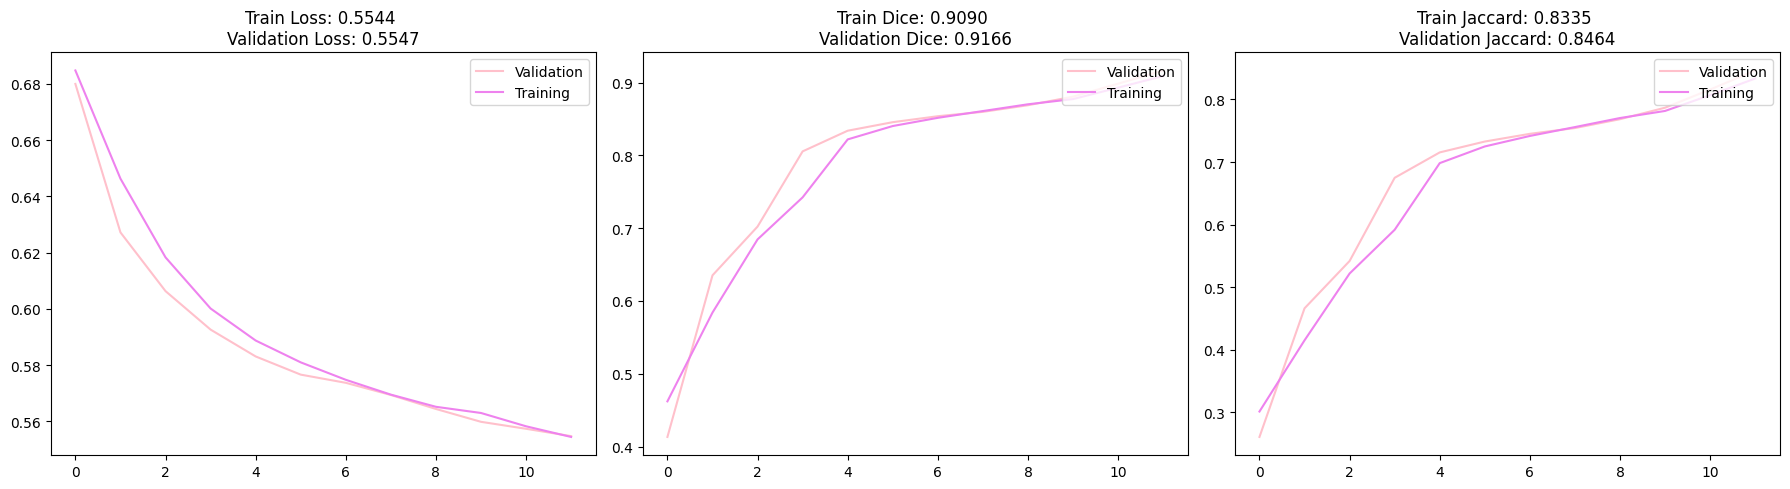

train epoch 13/70: 100%|██████████| 38/38 [00:27<00:00,  1.40it/s]


Loss: 0.5518 | Dice: 0.9251 | IoU: 0.8610


val epoch 13/70: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


Loss: 0.5505 | Dice: 0.9383 | IoU: 0.8842


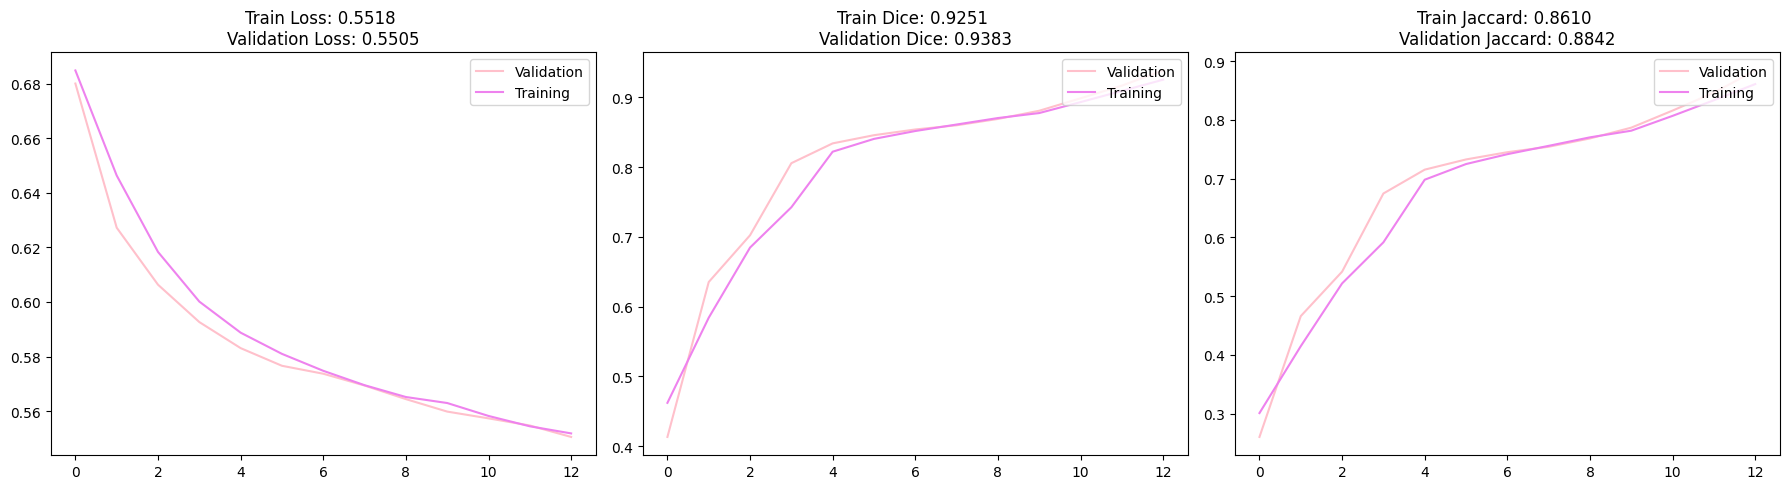

train epoch 14/70: 100%|██████████| 38/38 [00:26<00:00,  1.41it/s]


Loss: 0.5486 | Dice: 0.9471 | IoU: 0.8998


val epoch 14/70: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


Loss: 0.5523 | Dice: 0.9385 | IoU: 0.8860


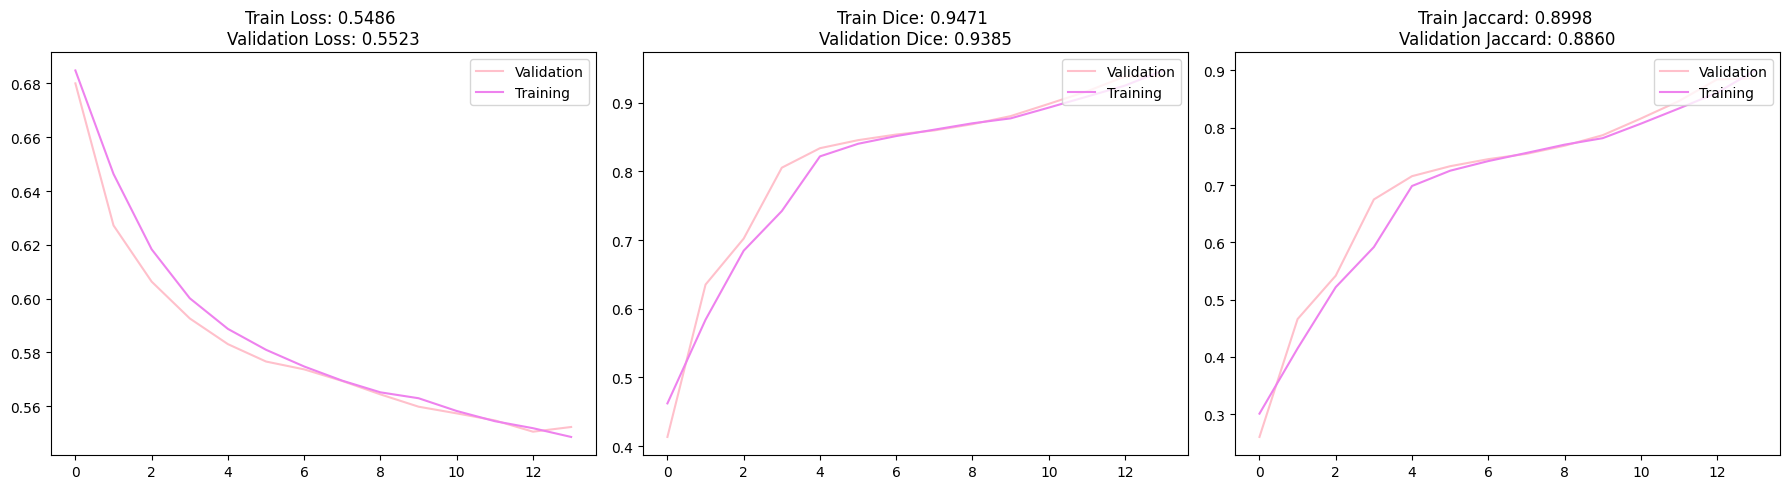

train epoch 15/70: 100%|██████████| 38/38 [00:26<00:00,  1.43it/s]


Loss: 0.5456 | Dice: 0.9589 | IoU: 0.9213


val epoch 15/70: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]


Loss: 0.5456 | Dice: 0.9603 | IoU: 0.9240


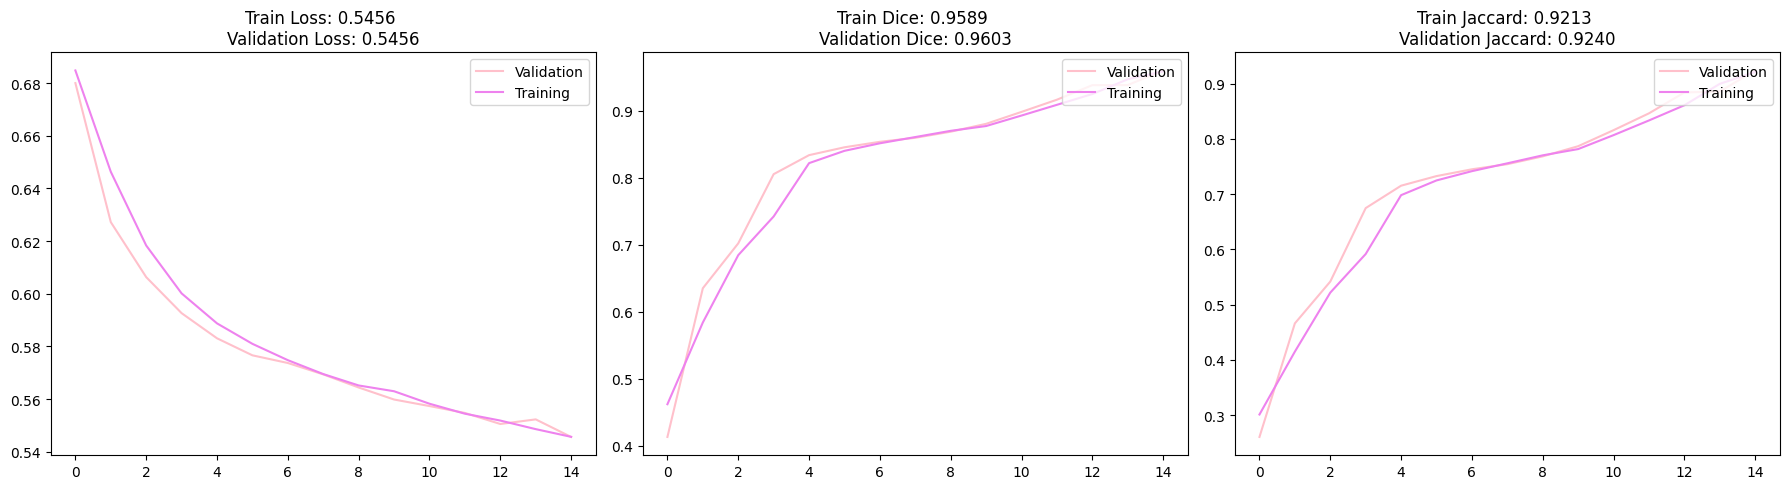

train epoch 16/70: 100%|██████████| 38/38 [00:26<00:00,  1.42it/s]


Loss: 0.5425 | Dice: 0.9667 | IoU: 0.9356


val epoch 16/70: 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]


Loss: 0.5480 | Dice: 0.9510 | IoU: 0.9085


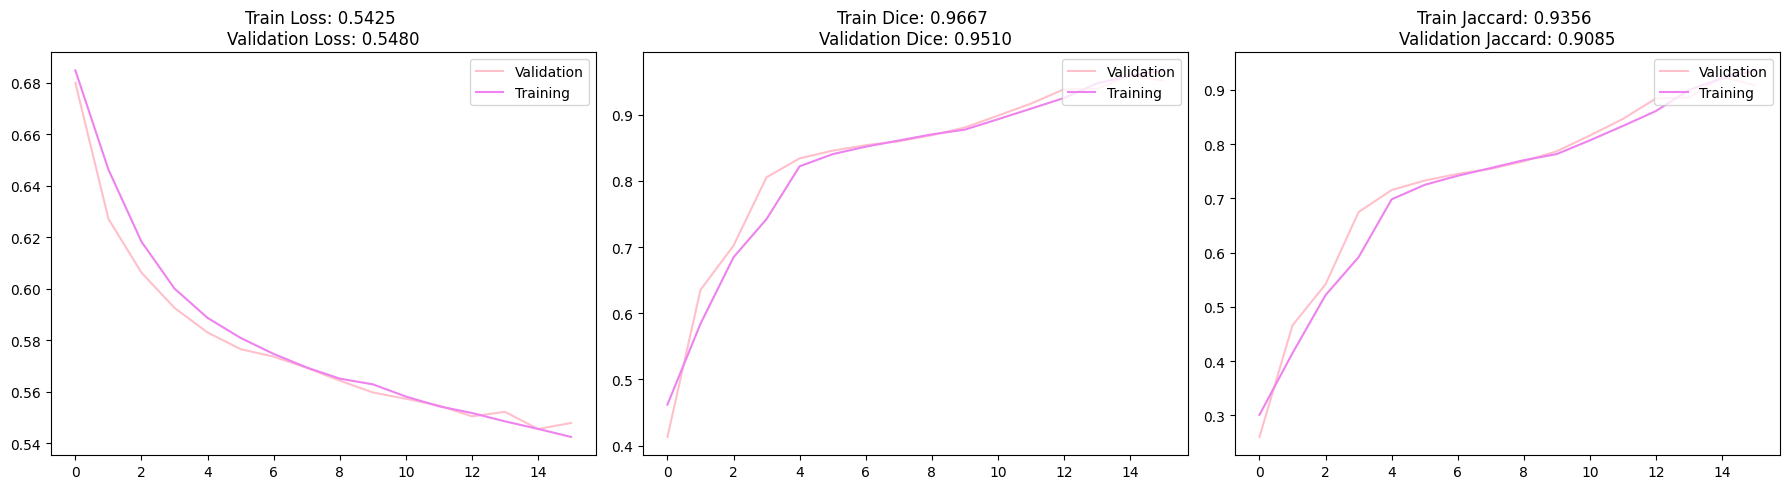

train epoch 17/70: 100%|██████████| 38/38 [00:26<00:00,  1.41it/s]


Loss: 0.5411 | Dice: 0.9705 | IoU: 0.9428


val epoch 17/70: 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]


Loss: 0.5414 | Dice: 0.9636 | IoU: 0.9305


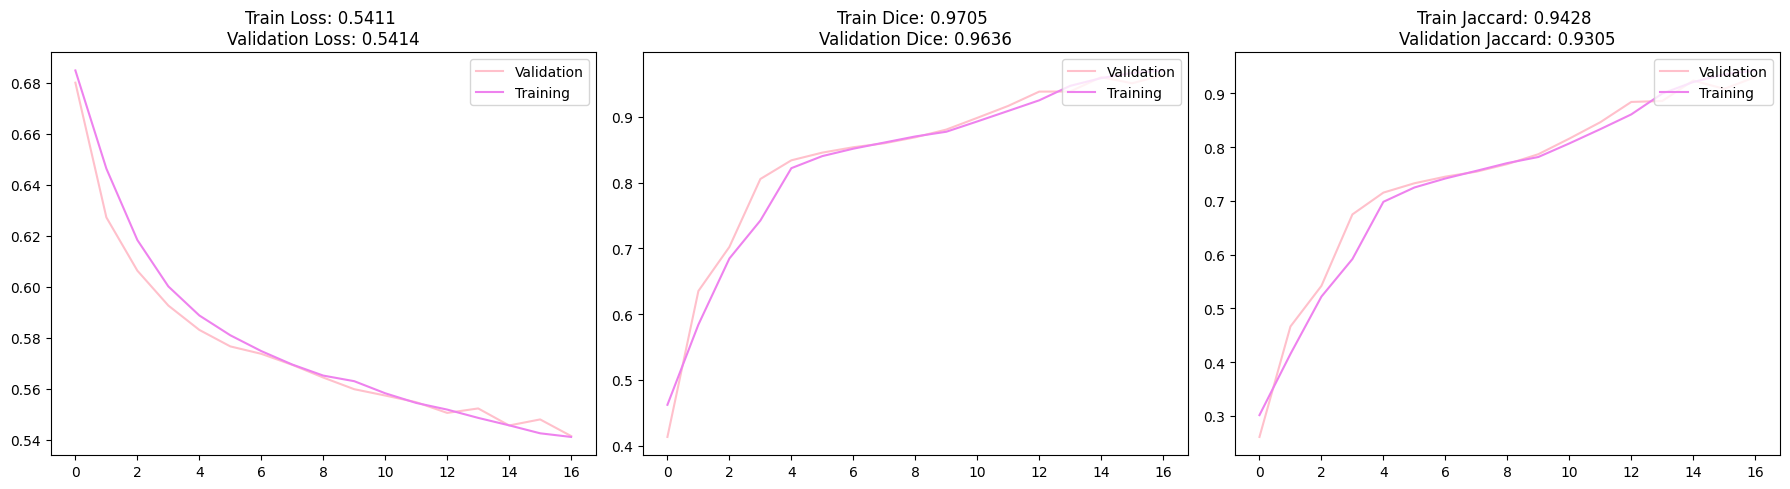

train epoch 18/70: 100%|██████████| 38/38 [00:27<00:00,  1.38it/s]


Loss: 0.5378 | Dice: 0.9744 | IoU: 0.9502


val epoch 18/70: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


Loss: 0.5388 | Dice: 0.9703 | IoU: 0.9426


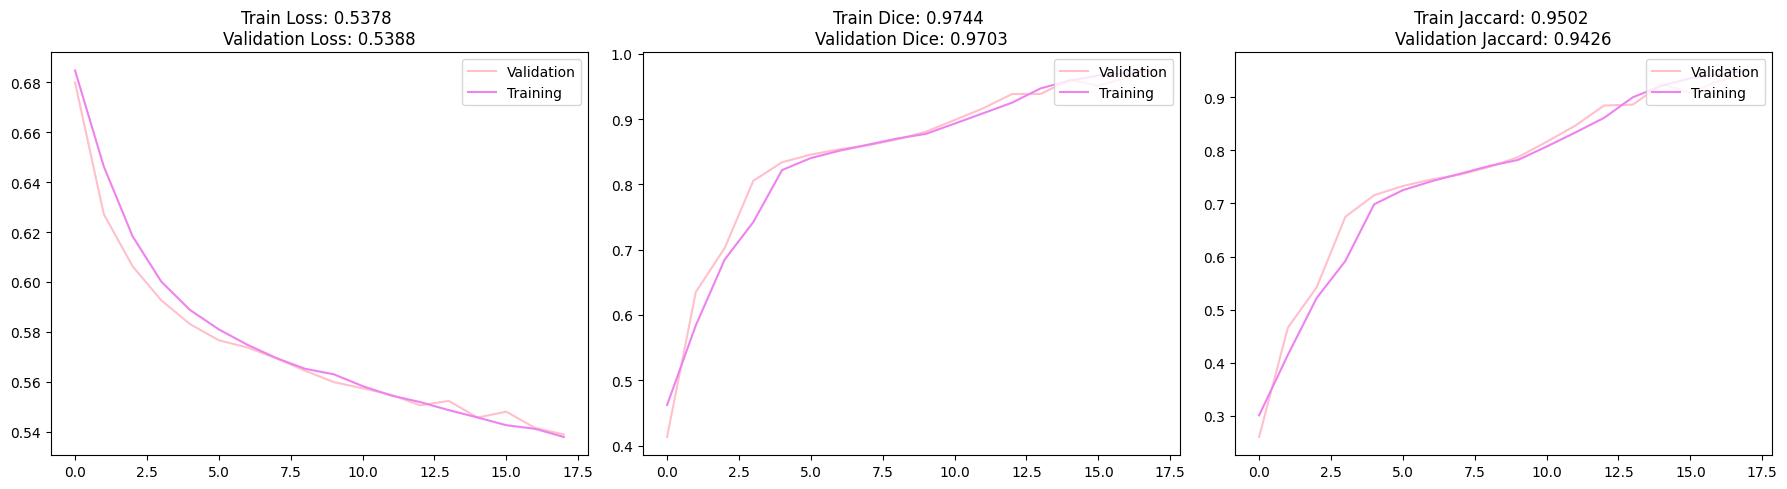

train epoch 19/70: 100%|██████████| 38/38 [00:26<00:00,  1.42it/s]


Loss: 0.5353 | Dice: 0.9769 | IoU: 0.9549


val epoch 19/70: 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


Loss: 0.5353 | Dice: 0.9760 | IoU: 0.9533


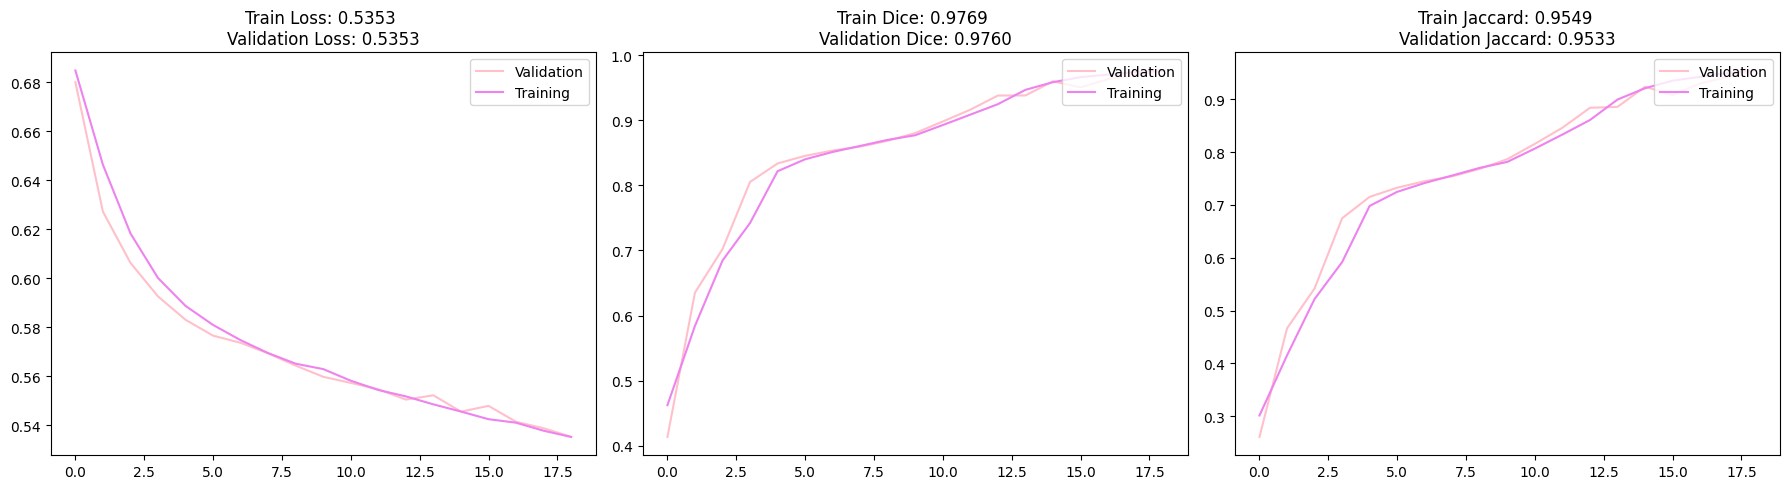

train epoch 20/70: 100%|██████████| 38/38 [00:27<00:00,  1.38it/s]


Loss: 0.5335 | Dice: 0.9770 | IoU: 0.9552


val epoch 20/70: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]


Loss: 0.5473 | Dice: 0.9517 | IoU: 0.9095


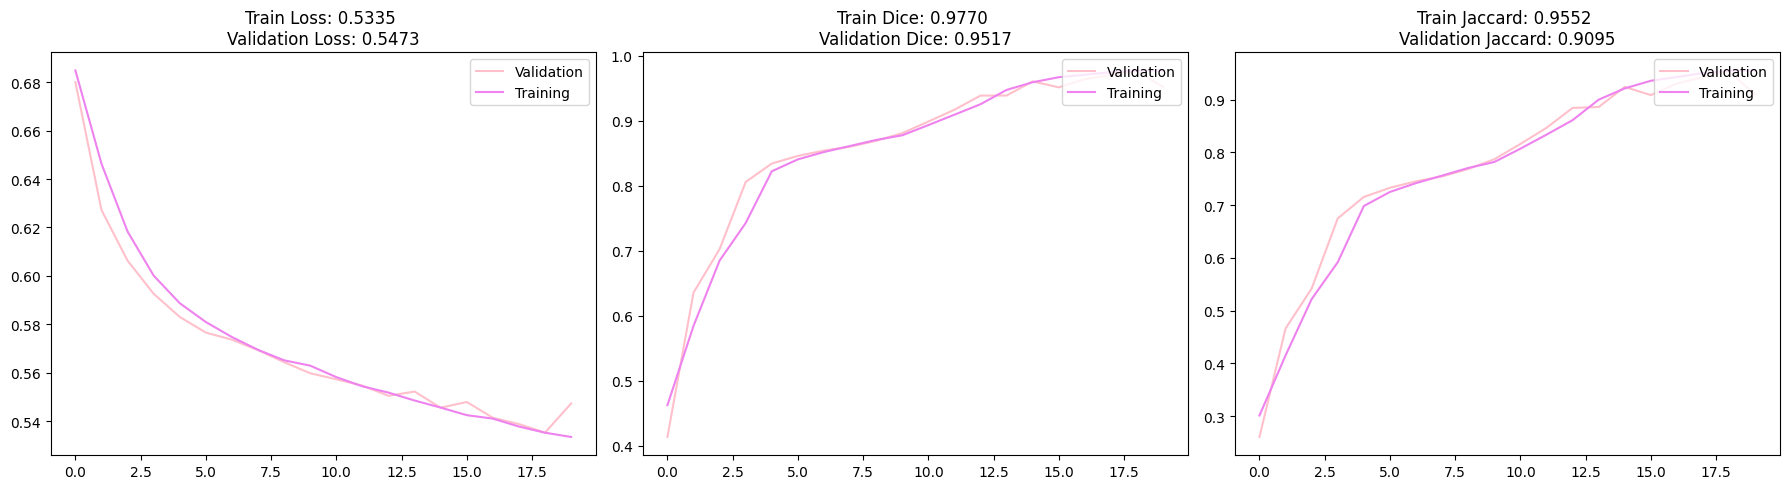

train epoch 21/70: 100%|██████████| 38/38 [00:27<00:00,  1.40it/s]


Loss: 0.5337 | Dice: 0.9746 | IoU: 0.9507


val epoch 21/70: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


Loss: 0.5314 | Dice: 0.9784 | IoU: 0.9579


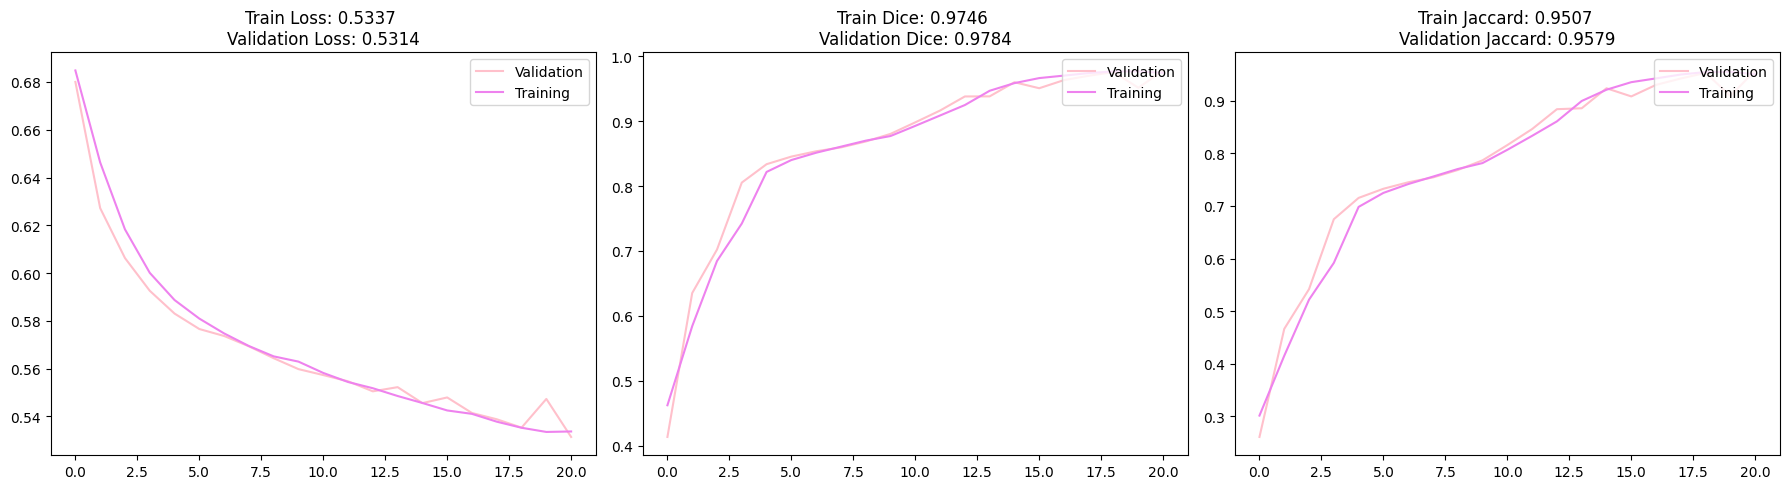

train epoch 22/70: 100%|██████████| 38/38 [00:27<00:00,  1.41it/s]


Loss: 0.5290 | Dice: 0.9797 | IoU: 0.9602


val epoch 22/70: 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]


Loss: 0.5290 | Dice: 0.9774 | IoU: 0.9559


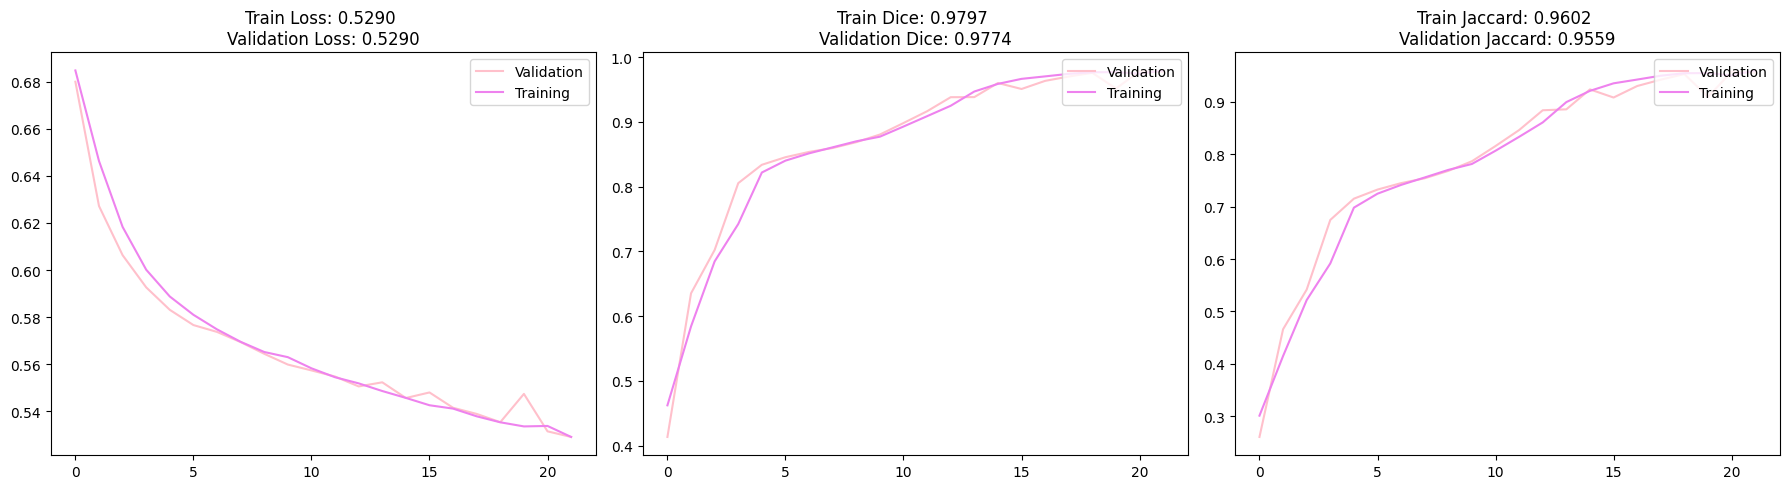

train epoch 23/70: 100%|██████████| 38/38 [00:27<00:00,  1.38it/s]


Loss: 0.5269 | Dice: 0.9810 | IoU: 0.9627


val epoch 23/70: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


Loss: 0.5273 | Dice: 0.9738 | IoU: 0.9495


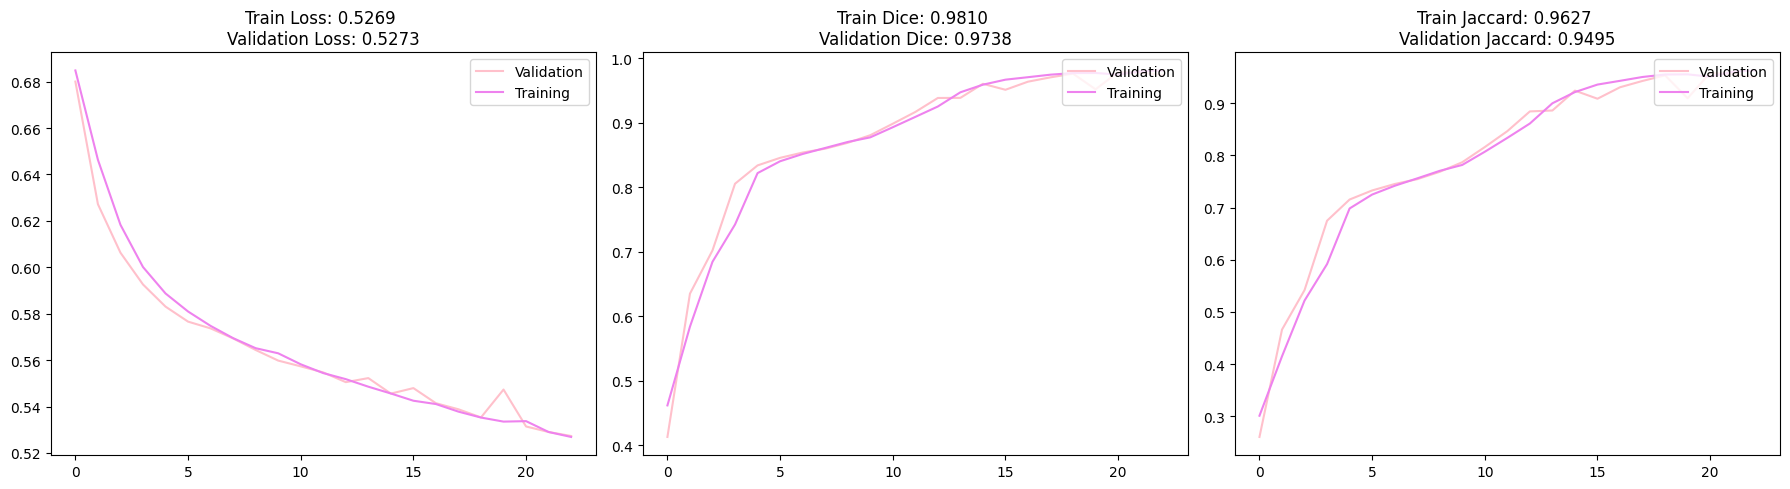

train epoch 24/70: 100%|██████████| 38/38 [00:27<00:00,  1.39it/s]


Loss: 0.5248 | Dice: 0.9818 | IoU: 0.9644


val epoch 24/70: 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]


Loss: 0.5257 | Dice: 0.9763 | IoU: 0.9543


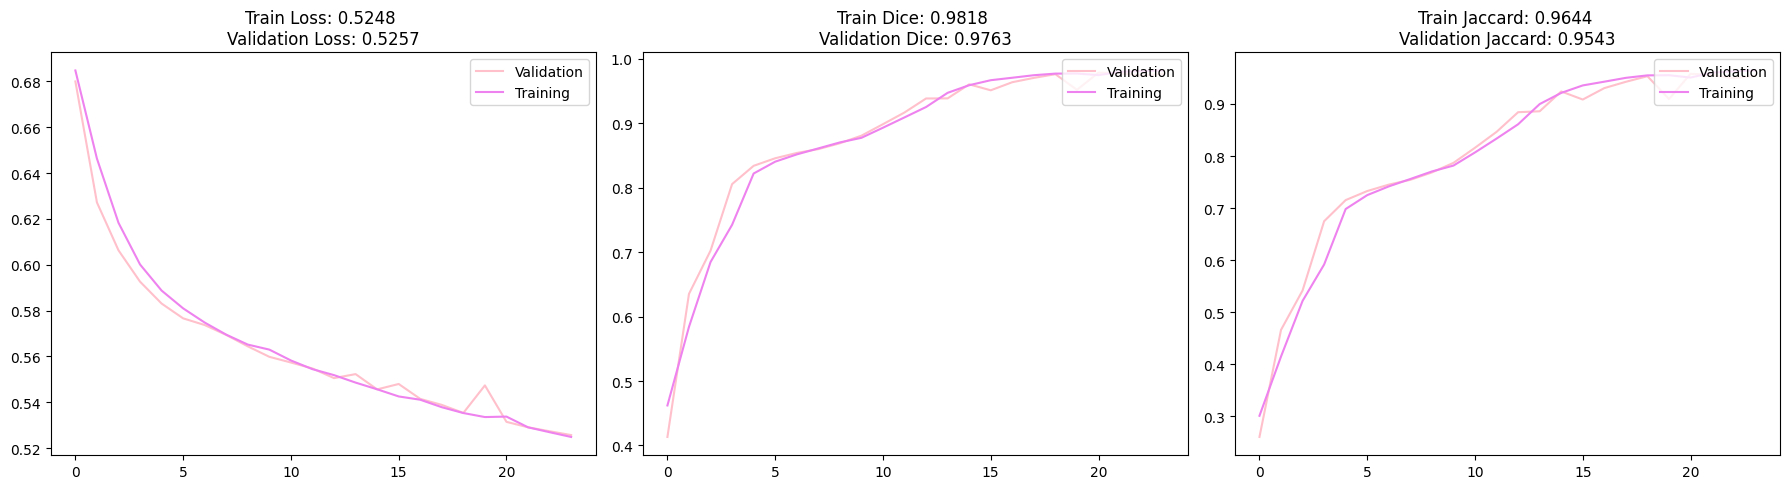

train epoch 25/70: 100%|██████████| 38/38 [00:27<00:00,  1.38it/s]


Loss: 0.5228 | Dice: 0.9816 | IoU: 0.9639


val epoch 25/70: 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]


Loss: 0.5217 | Dice: 0.9824 | IoU: 0.9657


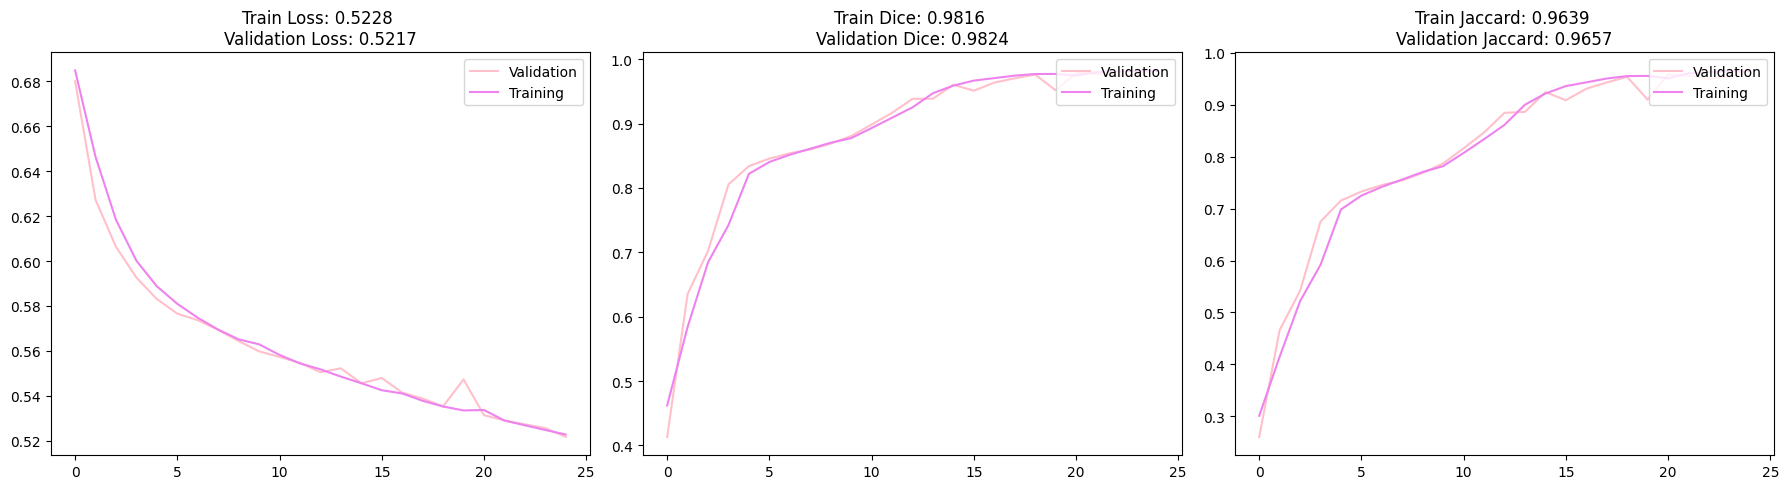

train epoch 26/70: 100%|██████████| 38/38 [00:27<00:00,  1.39it/s]


Loss: 0.5197 | Dice: 0.9846 | IoU: 0.9697


val epoch 26/70: 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]


Loss: 0.5204 | Dice: 0.9808 | IoU: 0.9625


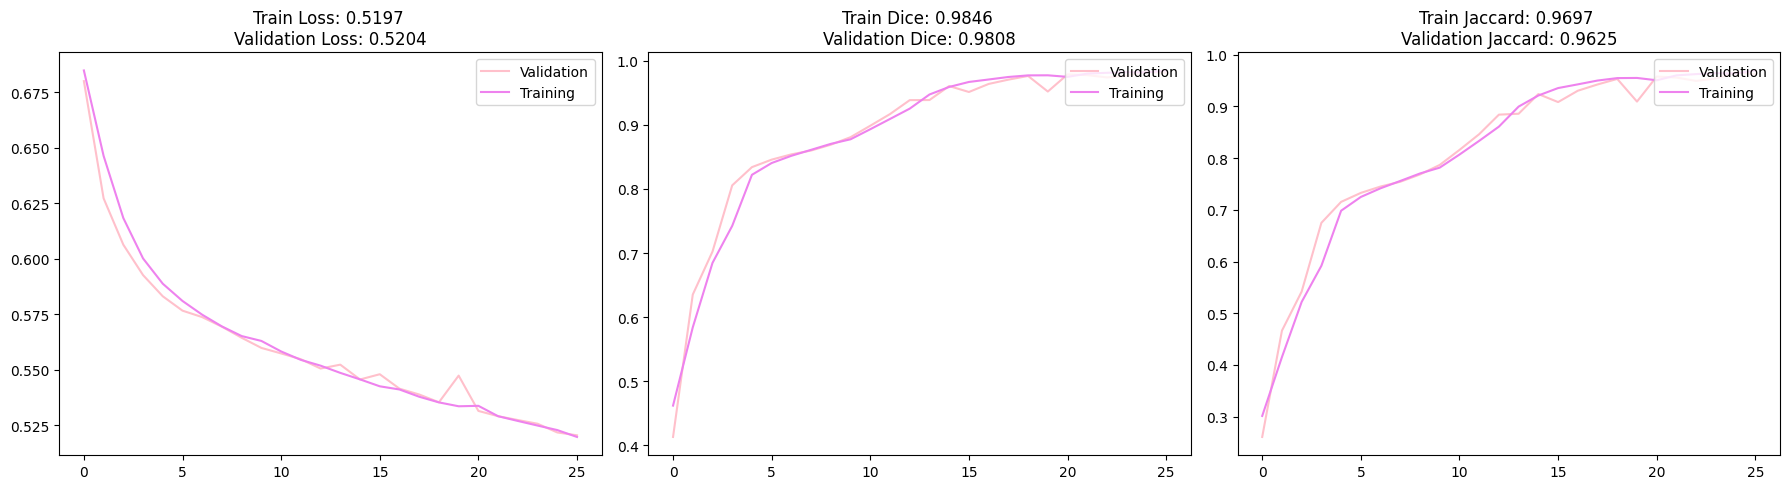

train epoch 27/70: 100%|██████████| 38/38 [00:27<00:00,  1.40it/s]


Loss: 0.5168 | Dice: 0.9866 | IoU: 0.9735


val epoch 27/70: 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]


Loss: 0.5171 | Dice: 0.9840 | IoU: 0.9686


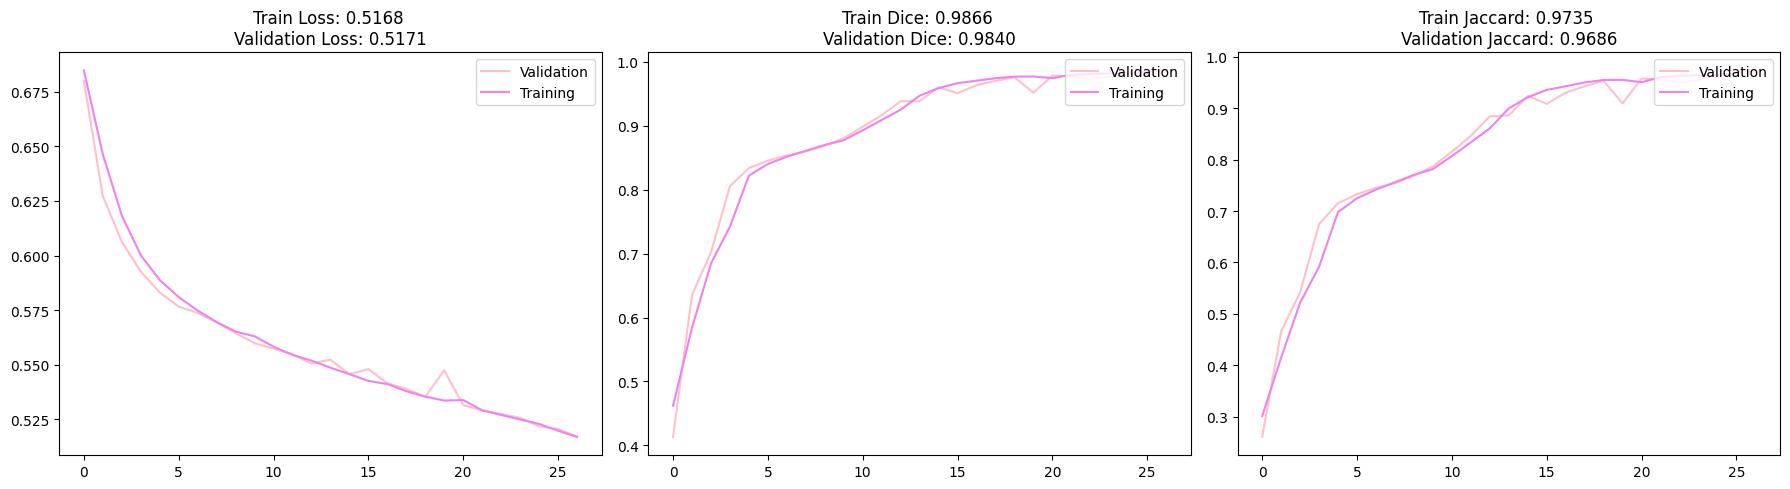

train epoch 28/70: 100%|██████████| 38/38 [00:27<00:00,  1.38it/s]


Loss: 0.5146 | Dice: 0.9876 | IoU: 0.9756


val epoch 28/70: 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


Loss: 0.5165 | Dice: 0.9837 | IoU: 0.9681


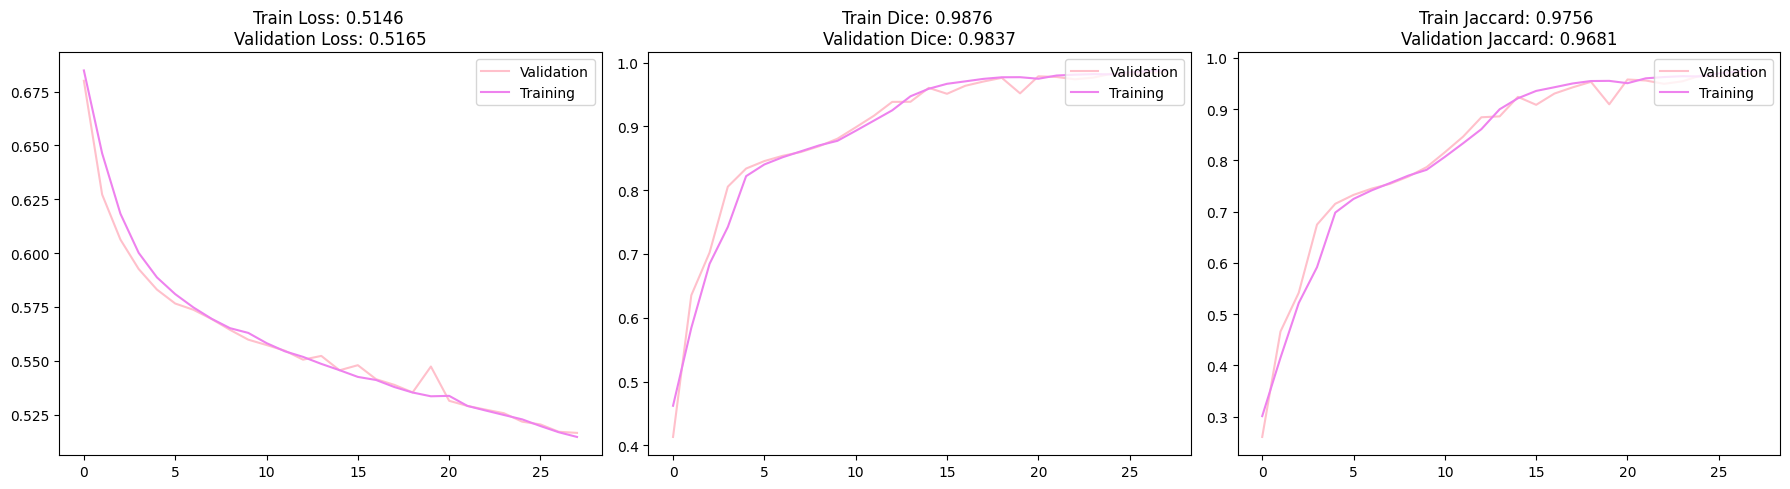

train epoch 29/70: 100%|██████████| 38/38 [00:26<00:00,  1.41it/s]


Loss: 0.5120 | Dice: 0.9890 | IoU: 0.9783


val epoch 29/70: 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]


Loss: 0.5145 | Dice: 0.9863 | IoU: 0.9730


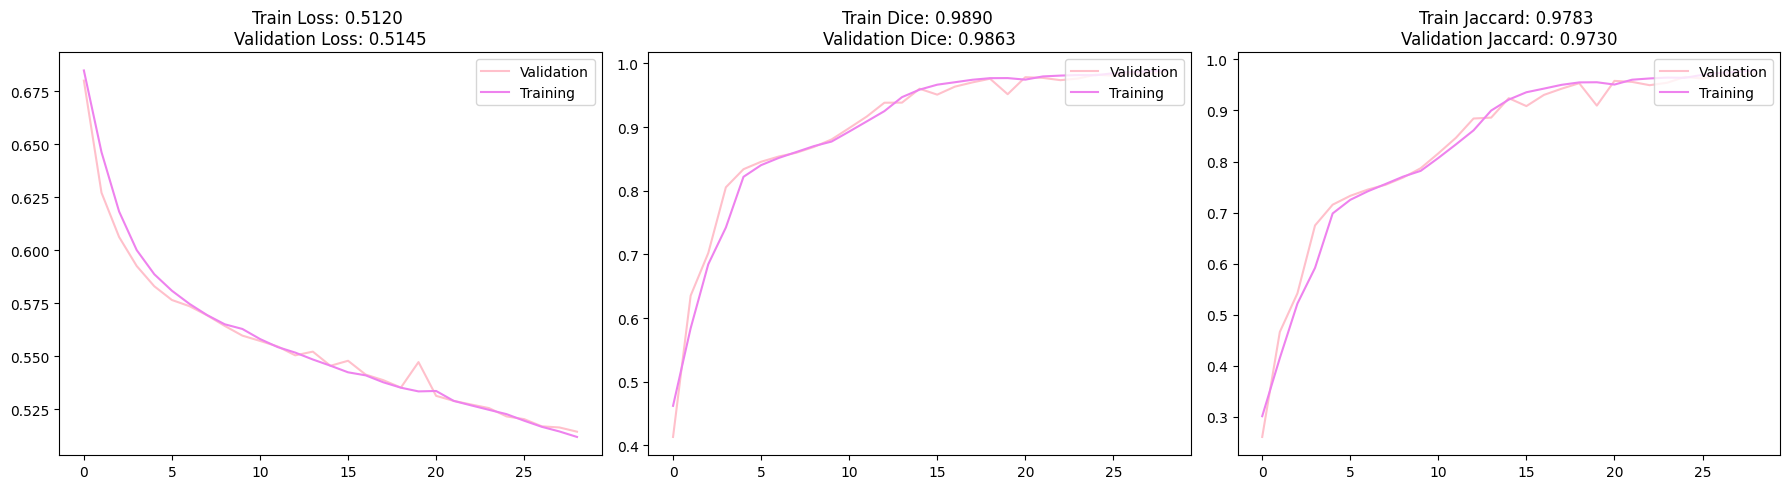

train epoch 30/70: 100%|██████████| 38/38 [00:27<00:00,  1.38it/s]


Loss: 0.5094 | Dice: 0.9899 | IoU: 0.9801


val epoch 30/70: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


Loss: 0.5127 | Dice: 0.9840 | IoU: 0.9688


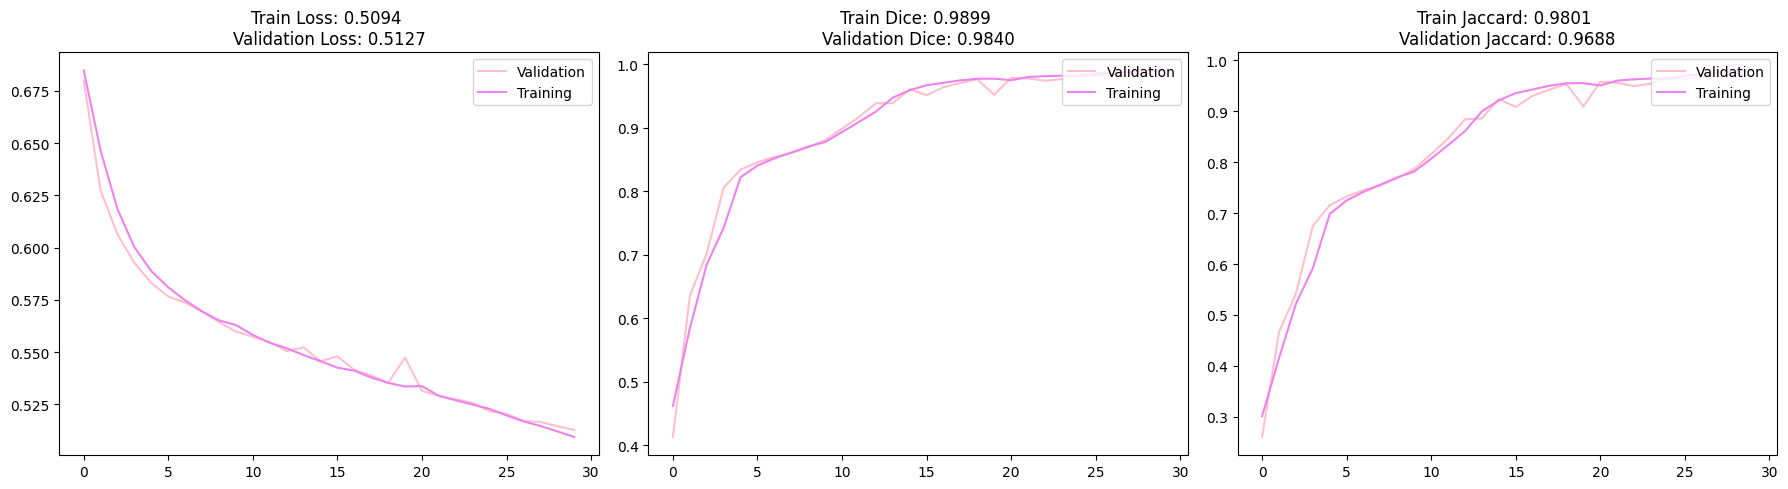

train epoch 31/70: 100%|██████████| 38/38 [00:27<00:00,  1.37it/s]


Loss: 0.5073 | Dice: 0.9897 | IoU: 0.9796


val epoch 31/70: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]


Loss: 0.5126 | Dice: 0.9845 | IoU: 0.9697


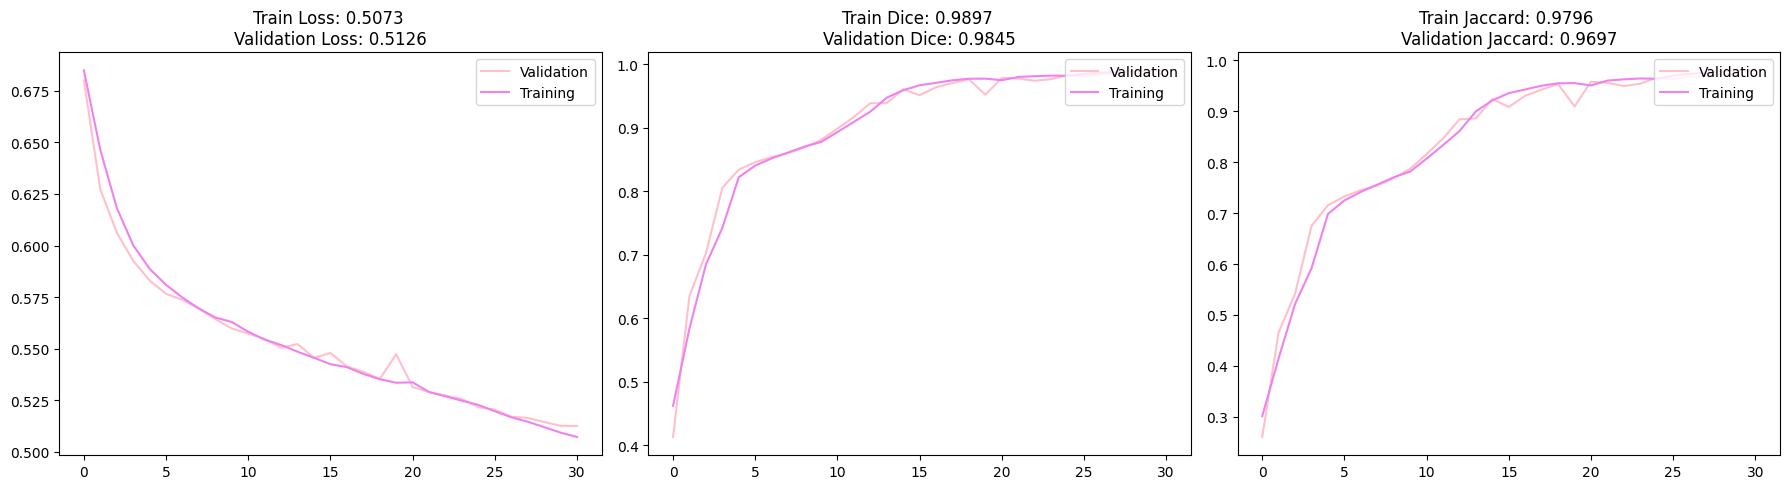

train epoch 32/70: 100%|██████████| 38/38 [00:27<00:00,  1.41it/s]


Loss: 0.5047 | Dice: 0.9898 | IoU: 0.9800


val epoch 32/70: 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]


Loss: 0.5114 | Dice: 0.9860 | IoU: 0.9725


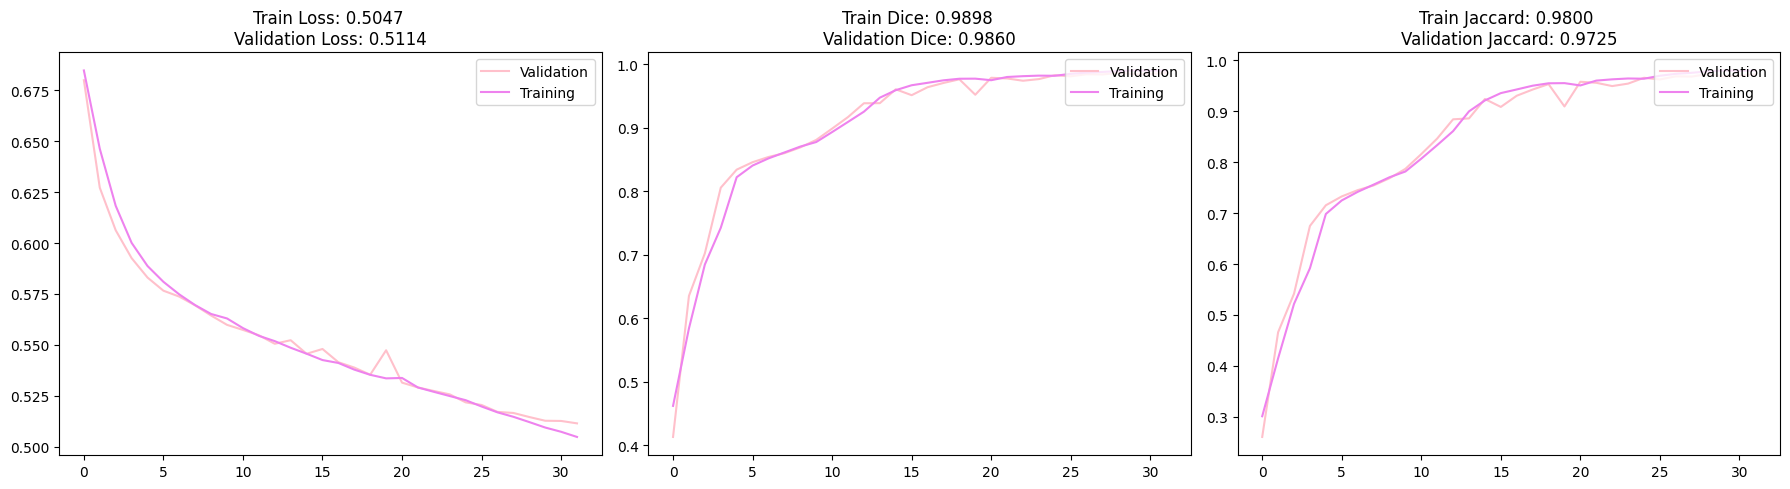

train epoch 33/70: 100%|██████████| 38/38 [00:27<00:00,  1.38it/s]


Loss: 0.5020 | Dice: 0.9894 | IoU: 0.9790


val epoch 33/70: 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


Loss: 0.5100 | Dice: 0.9812 | IoU: 0.9636


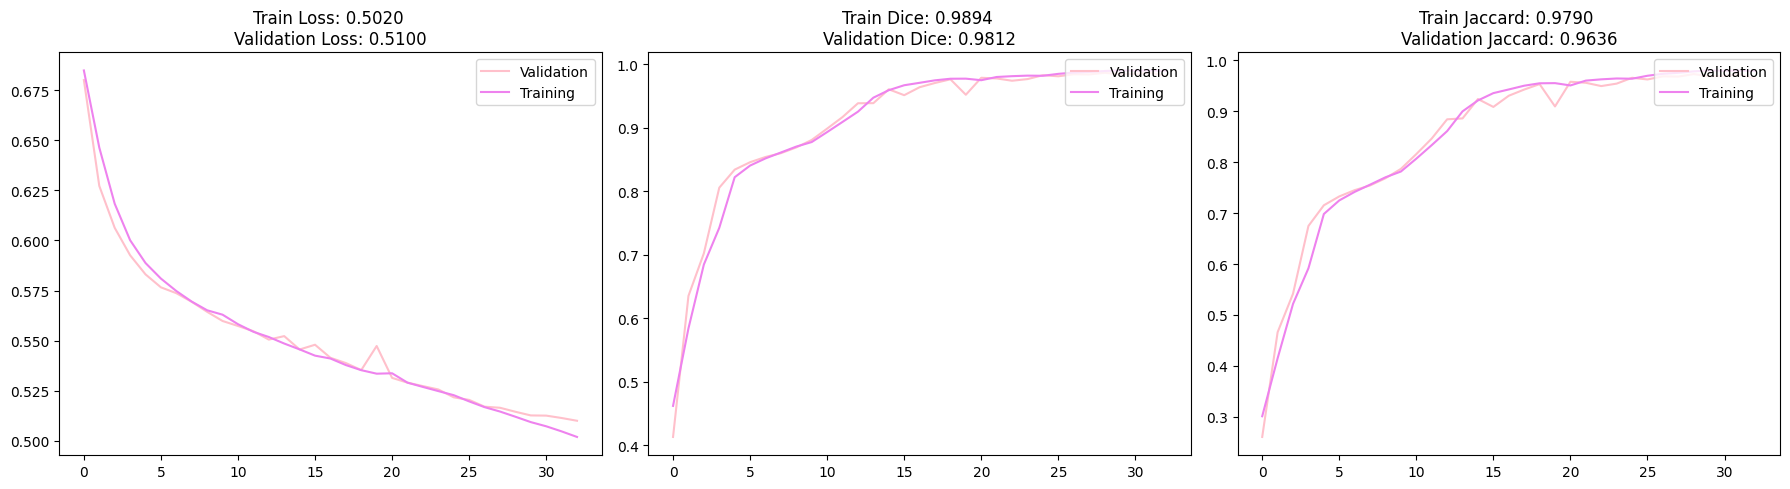

train epoch 34/70: 100%|██████████| 38/38 [00:27<00:00,  1.40it/s]


Loss: 0.4986 | Dice: 0.9896 | IoU: 0.9795


val epoch 34/70: 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


Loss: 0.5076 | Dice: 0.9736 | IoU: 0.9490


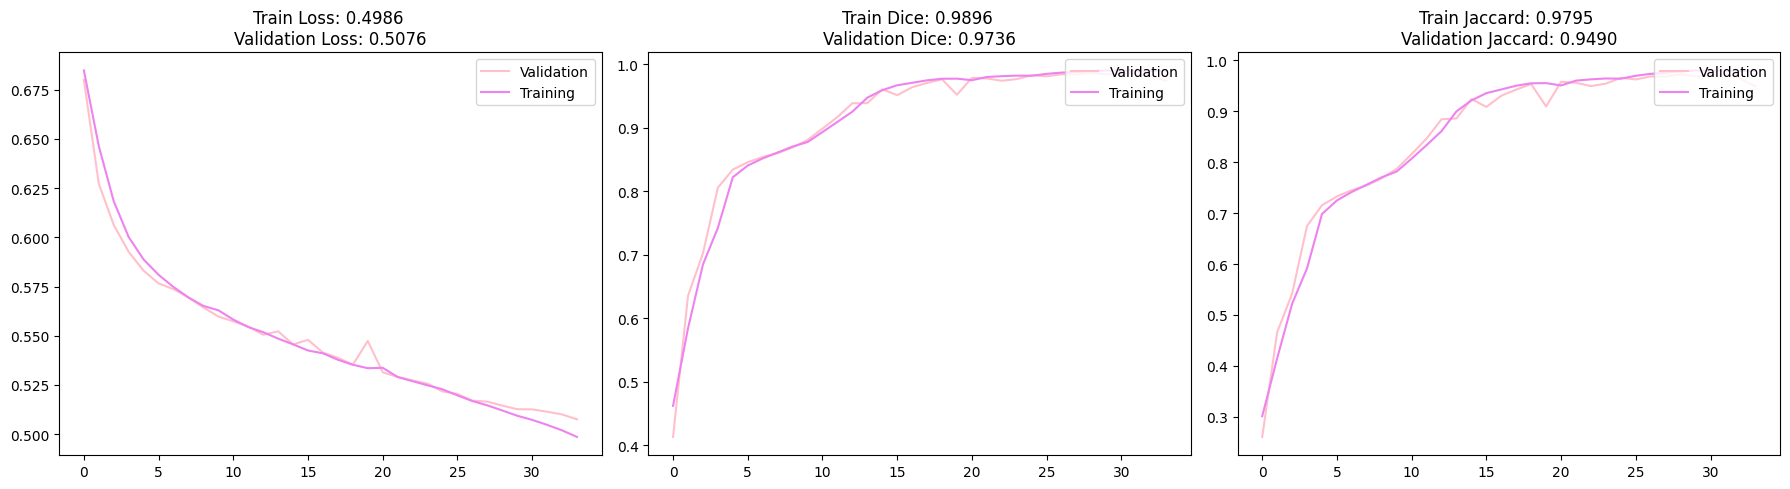

train epoch 35/70: 100%|██████████| 38/38 [00:27<00:00,  1.38it/s]


Loss: 0.4970 | Dice: 0.9857 | IoU: 0.9720


val epoch 35/70: 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]


Loss: 0.4963 | Dice: 0.9847 | IoU: 0.9700


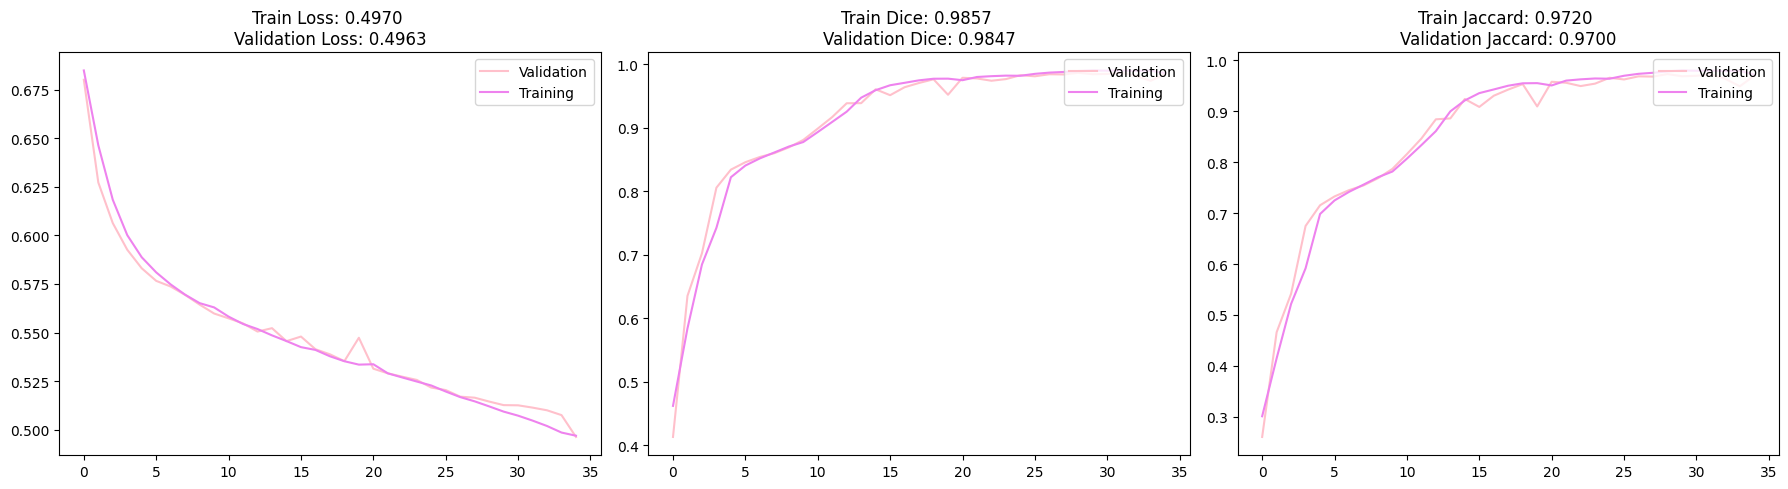

train epoch 36/70: 100%|██████████| 38/38 [00:27<00:00,  1.38it/s]


Loss: 0.4915 | Dice: 0.9888 | IoU: 0.9778


val epoch 36/70: 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]


Loss: 0.4936 | Dice: 0.9887 | IoU: 0.9777


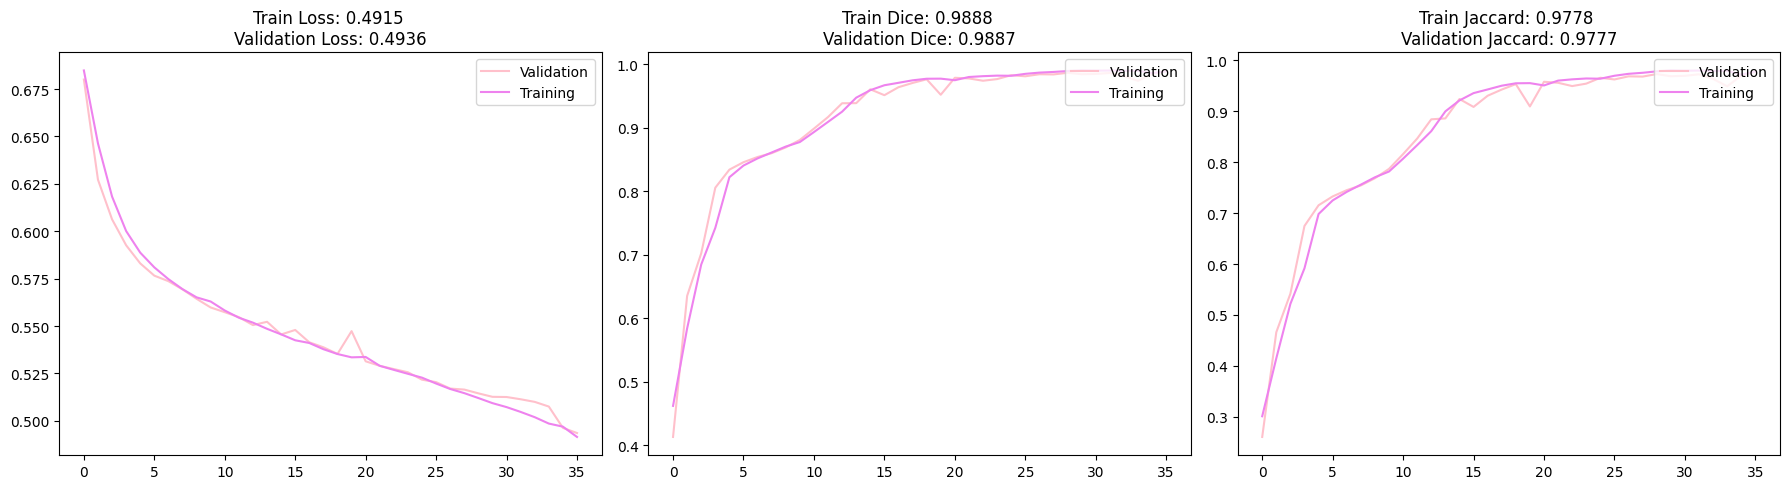

train epoch 37/70: 100%|██████████| 38/38 [00:27<00:00,  1.40it/s]


Loss: 0.4876 | Dice: 0.9901 | IoU: 0.9805


val epoch 37/70: 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


Loss: 0.4897 | Dice: 0.9875 | IoU: 0.9753


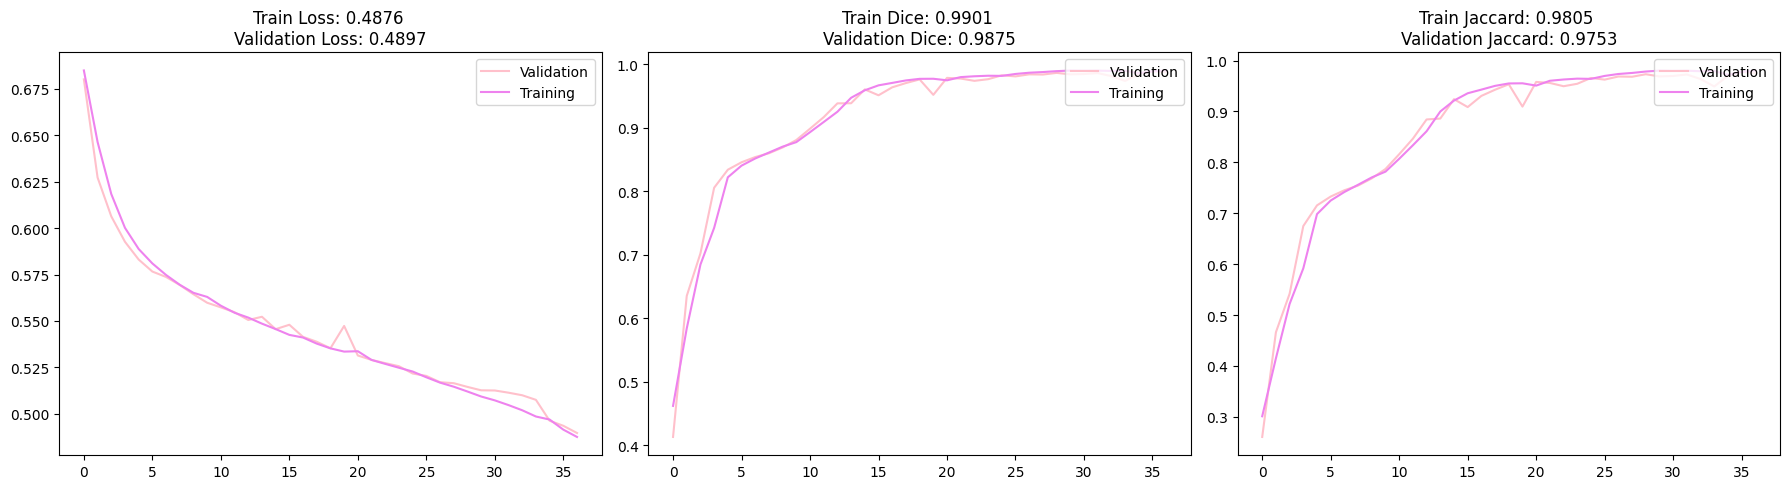

train epoch 38/70: 100%|██████████| 38/38 [00:27<00:00,  1.38it/s]


Loss: 0.4850 | Dice: 0.9906 | IoU: 0.9814


val epoch 38/70: 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]


Loss: 0.4899 | Dice: 0.9883 | IoU: 0.9769


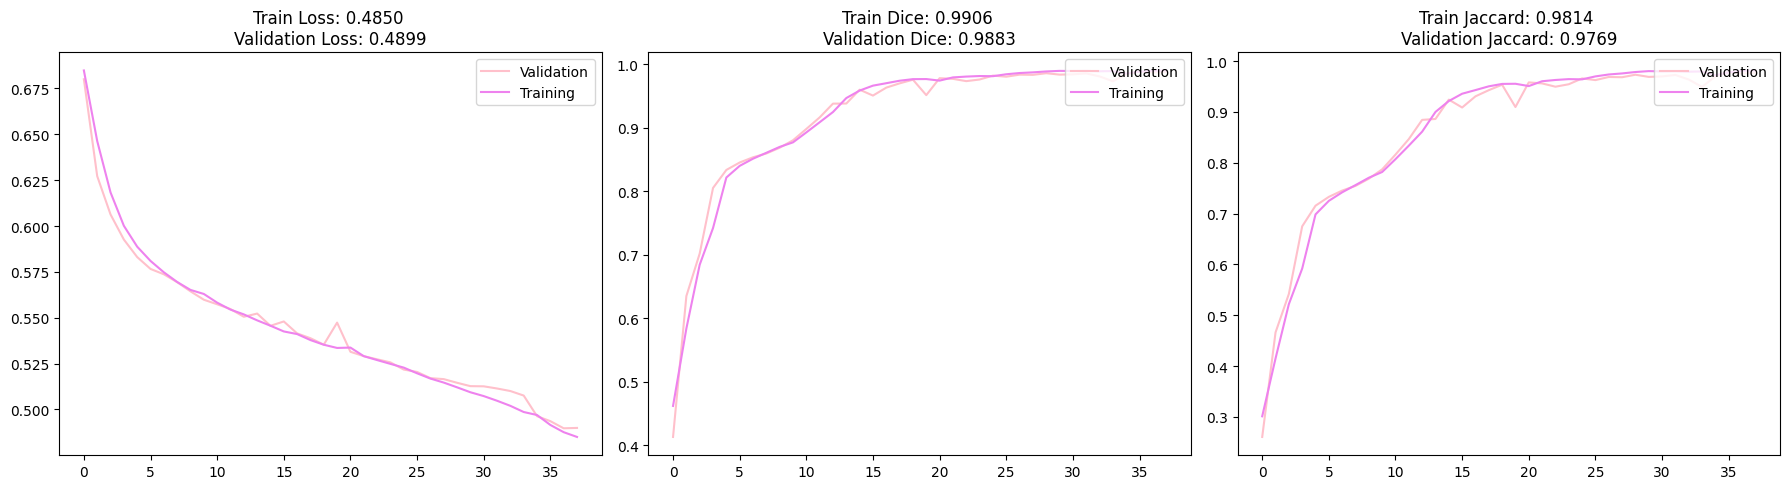

train epoch 39/70: 100%|██████████| 38/38 [00:26<00:00,  1.41it/s]


Loss: 0.4821 | Dice: 0.9912 | IoU: 0.9825


val epoch 39/70: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


Loss: 0.4860 | Dice: 0.9874 | IoU: 0.9752


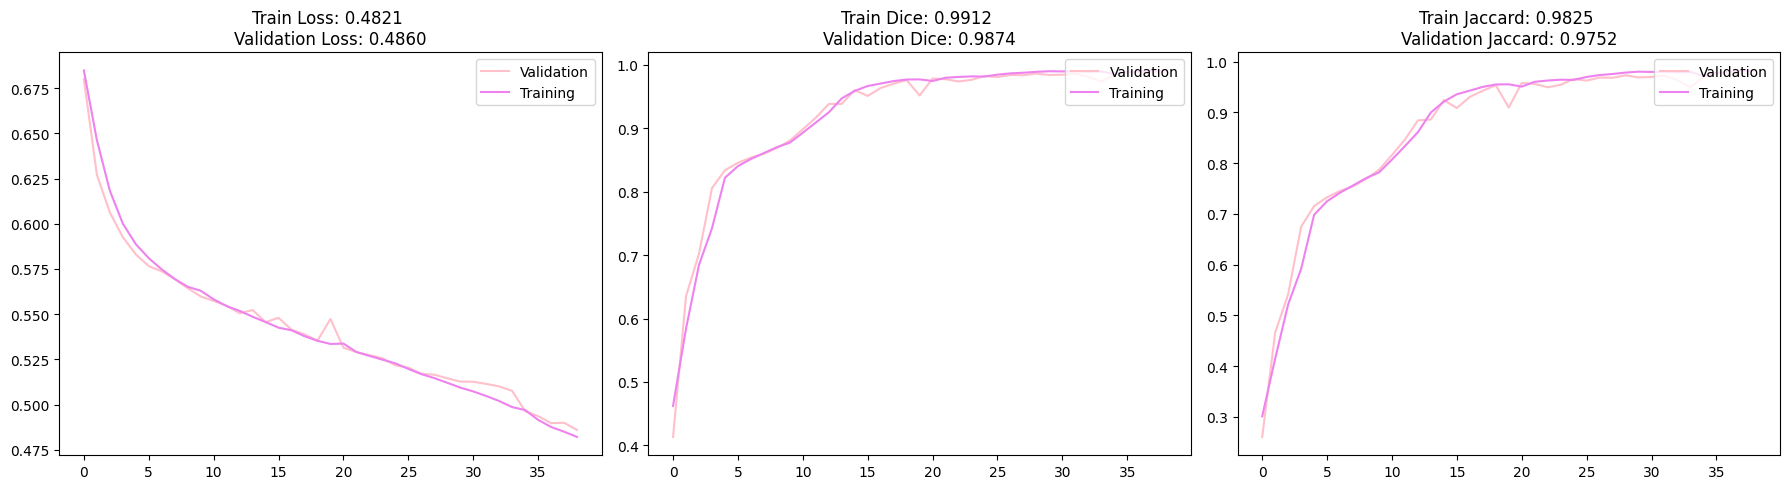

train epoch 40/70: 100%|██████████| 38/38 [00:27<00:00,  1.38it/s]


Loss: 0.4796 | Dice: 0.9913 | IoU: 0.9828


val epoch 40/70: 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


Loss: 0.4862 | Dice: 0.9868 | IoU: 0.9741


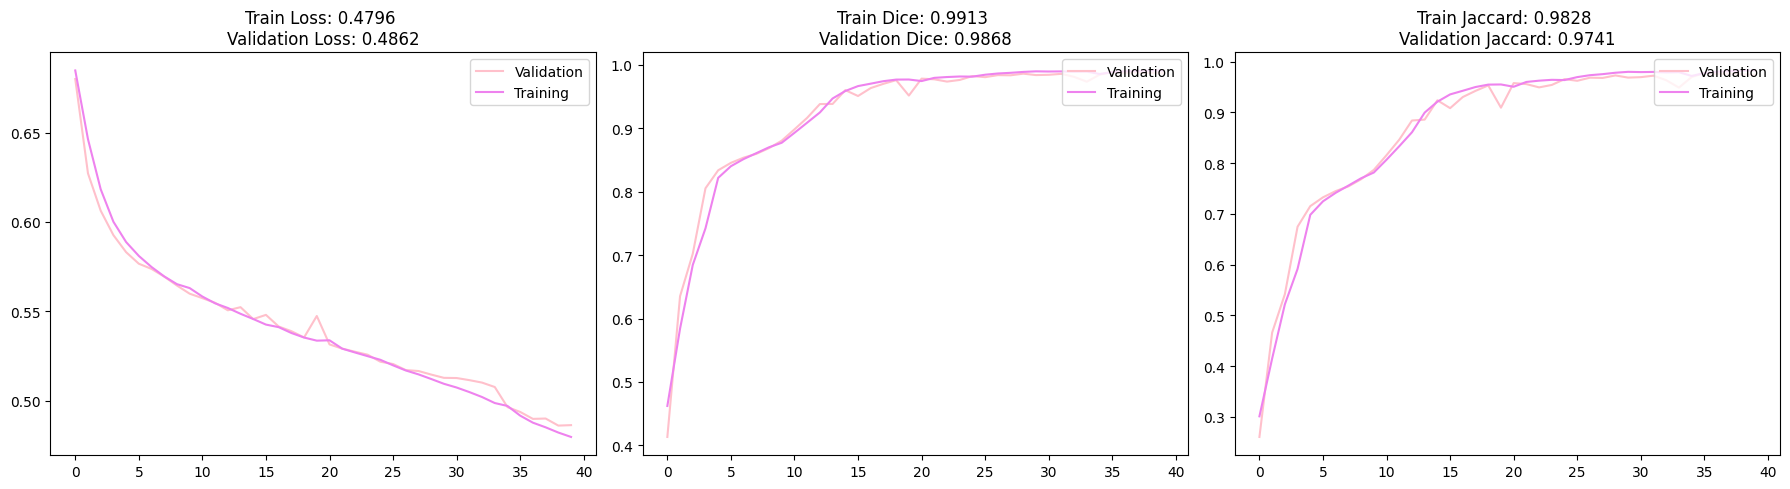

train epoch 41/70: 100%|██████████| 38/38 [00:26<00:00,  1.41it/s]


Loss: 0.4775 | Dice: 0.9909 | IoU: 0.9821


val epoch 41/70: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]


Loss: 0.4800 | Dice: 0.9857 | IoU: 0.9720


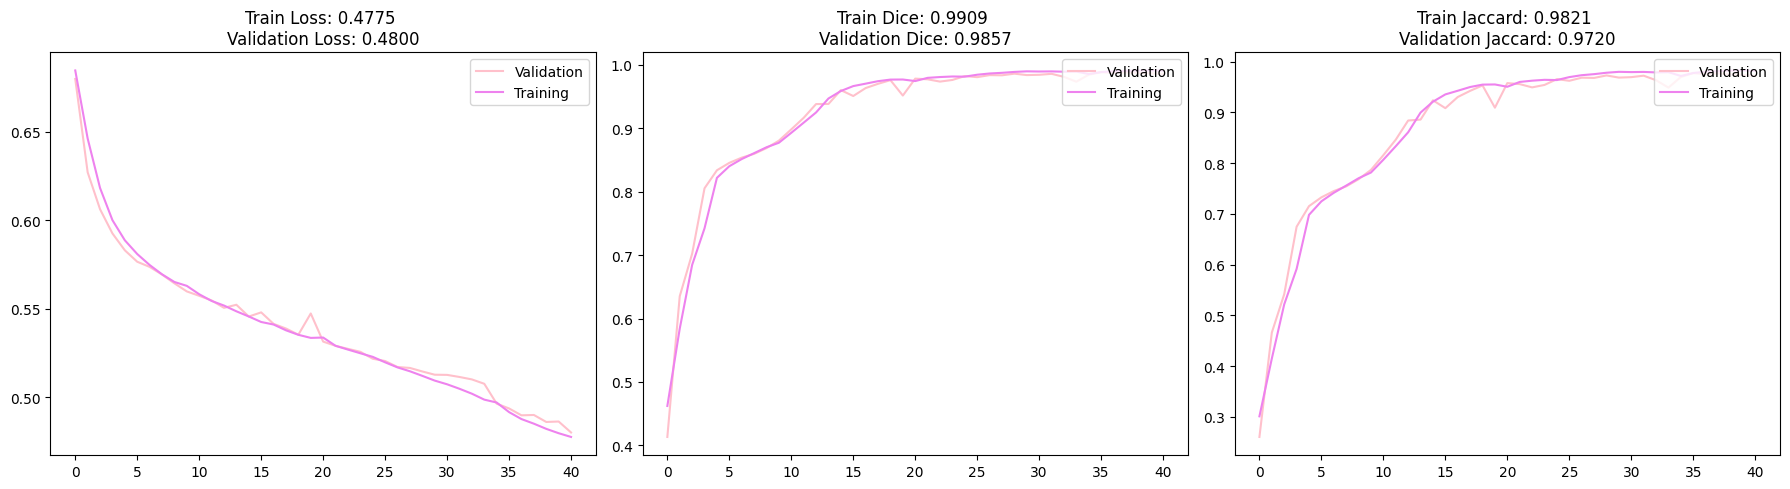

train epoch 42/70: 100%|██████████| 38/38 [00:27<00:00,  1.37it/s]


Loss: 0.4746 | Dice: 0.9913 | IoU: 0.9829


val epoch 42/70: 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]


Loss: 0.4741 | Dice: 0.9855 | IoU: 0.9715


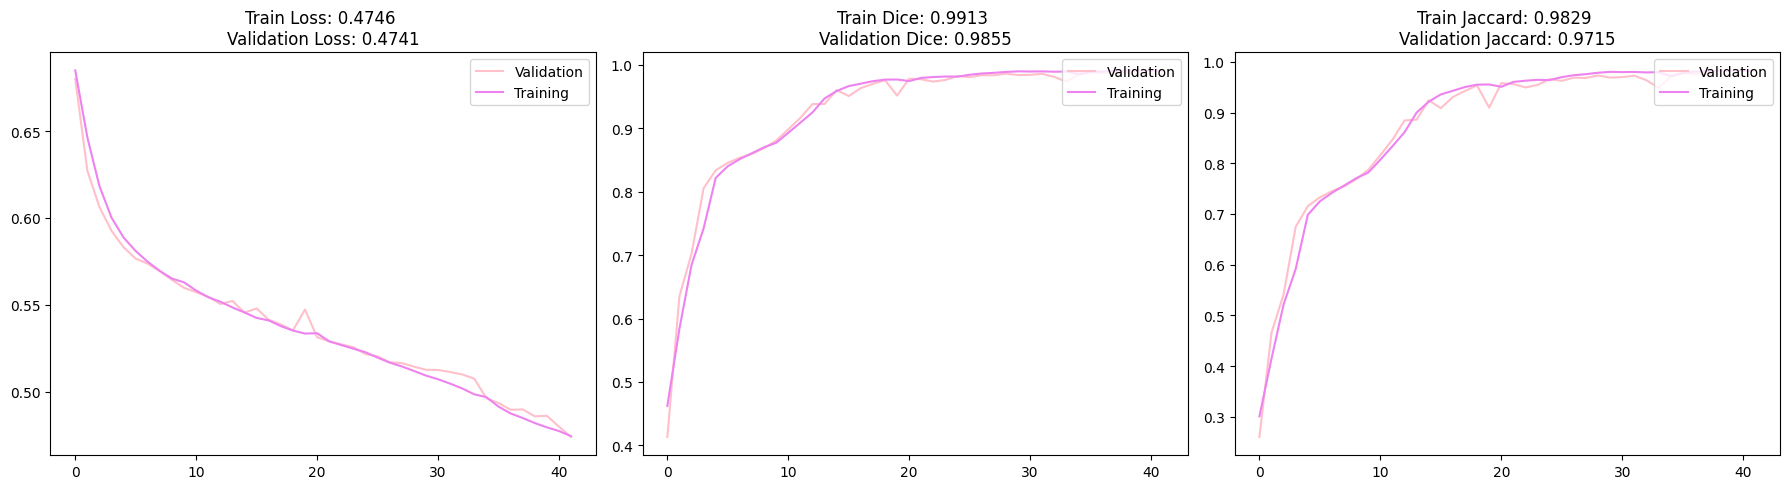

train epoch 43/70: 100%|██████████| 38/38 [00:27<00:00,  1.37it/s]


Loss: 0.4720 | Dice: 0.9918 | IoU: 0.9837


val epoch 43/70: 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]


Loss: 0.4752 | Dice: 0.9850 | IoU: 0.9706


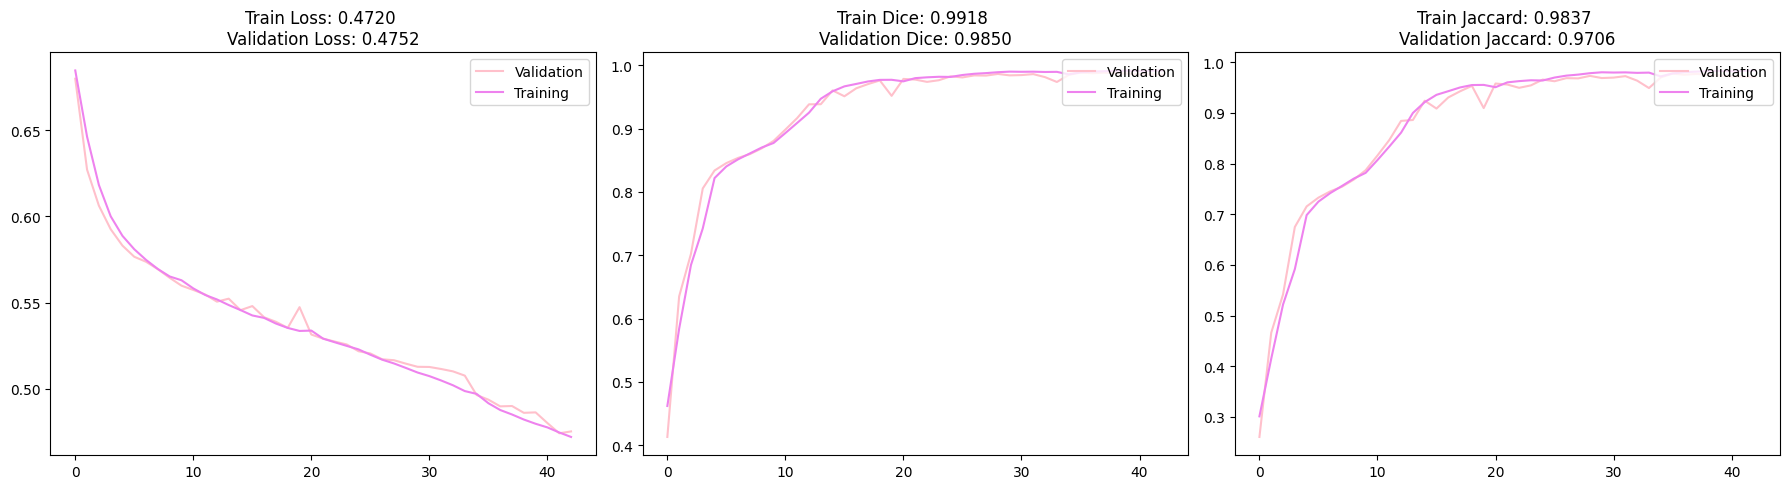

train epoch 44/70: 100%|██████████| 38/38 [00:26<00:00,  1.41it/s]


Loss: 0.4694 | Dice: 0.9918 | IoU: 0.9837


val epoch 44/70: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


Loss: 0.4708 | Dice: 0.9880 | IoU: 0.9764


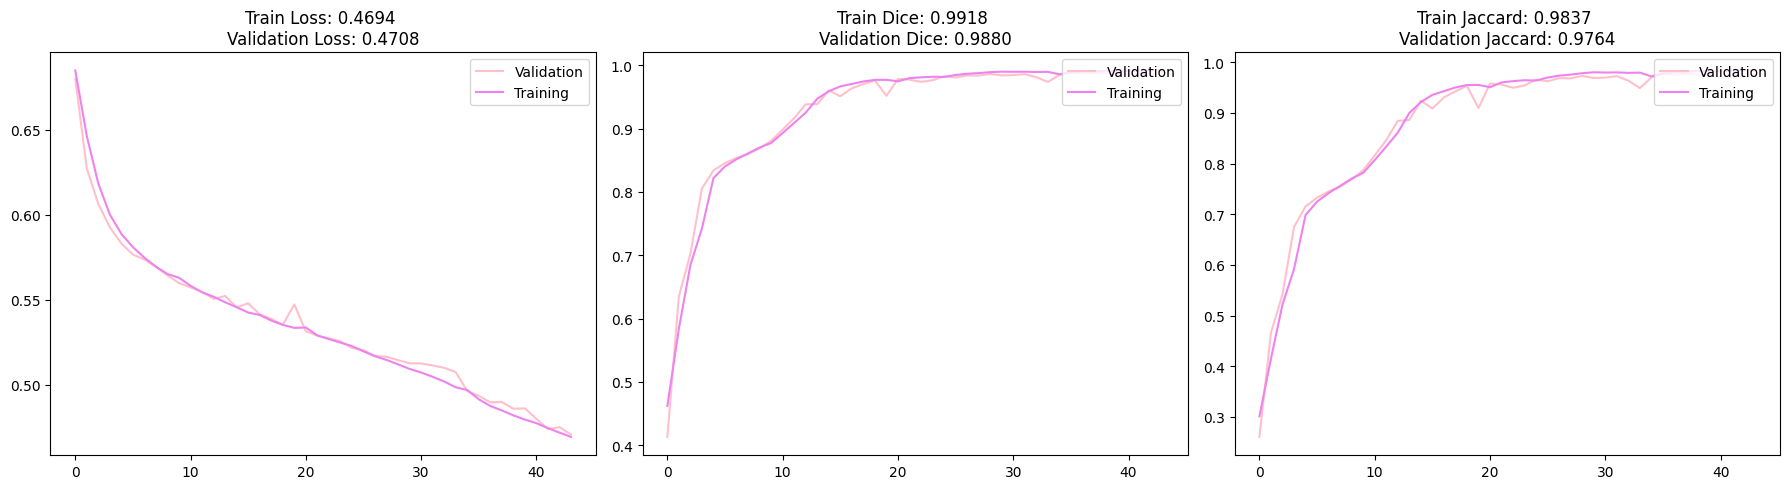

train epoch 45/70: 100%|██████████| 38/38 [00:27<00:00,  1.38it/s]


Loss: 0.4665 | Dice: 0.9924 | IoU: 0.9849


val epoch 45/70: 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


Loss: 0.4707 | Dice: 0.9875 | IoU: 0.9754


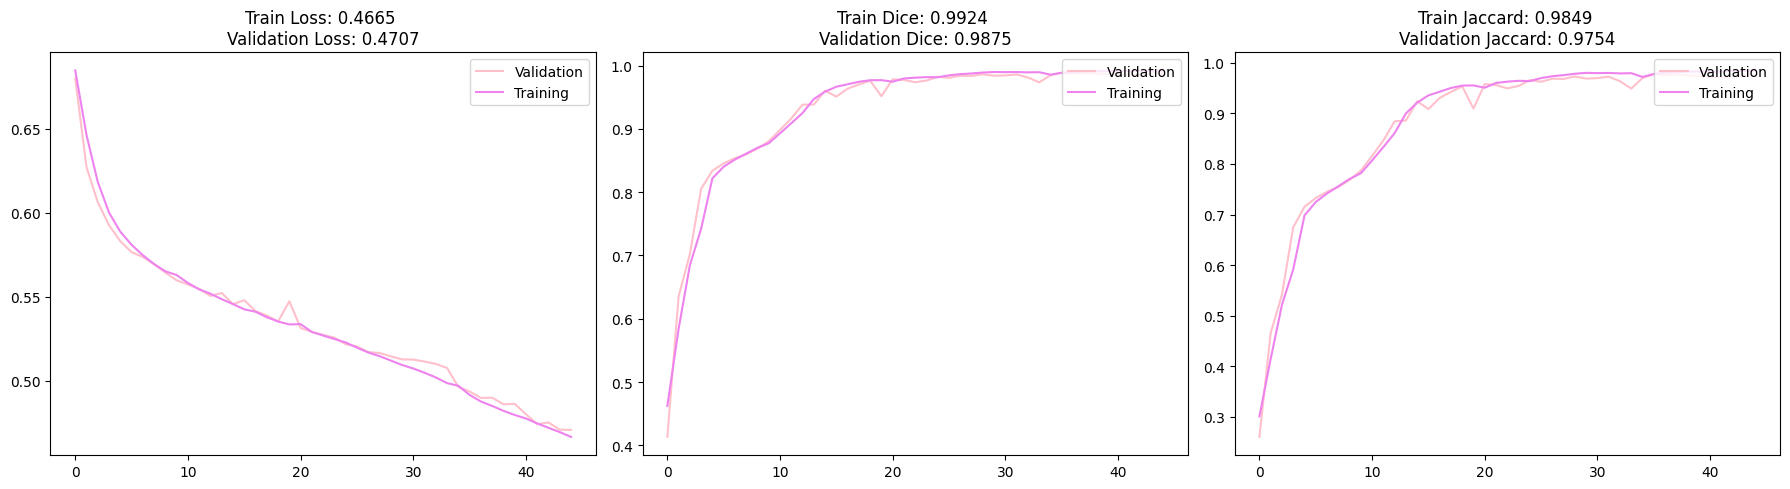

train epoch 46/70: 100%|██████████| 38/38 [00:27<00:00,  1.37it/s]


Loss: 0.4644 | Dice: 0.9924 | IoU: 0.9849


val epoch 46/70: 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


Loss: 0.4659 | Dice: 0.9878 | IoU: 0.9760


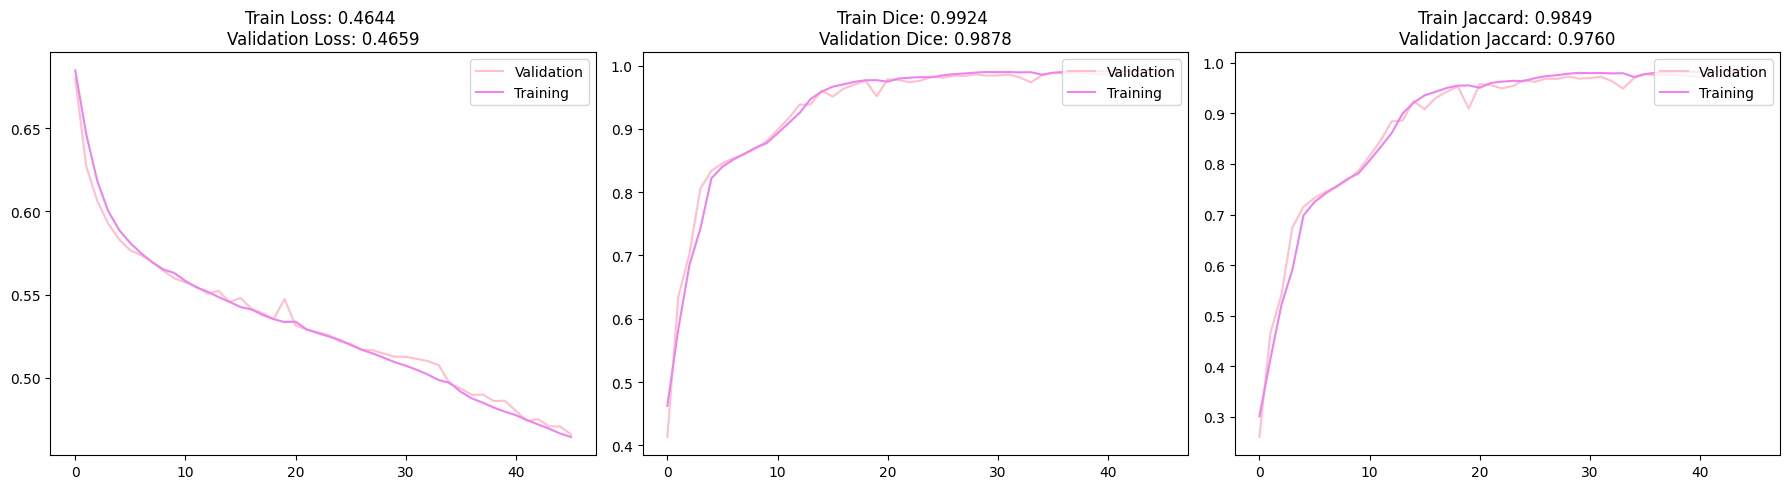

train epoch 47/70: 100%|██████████| 38/38 [00:27<00:00,  1.40it/s]


Loss: 0.4618 | Dice: 0.9927 | IoU: 0.9854


val epoch 47/70: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


Loss: 0.4646 | Dice: 0.9874 | IoU: 0.9752


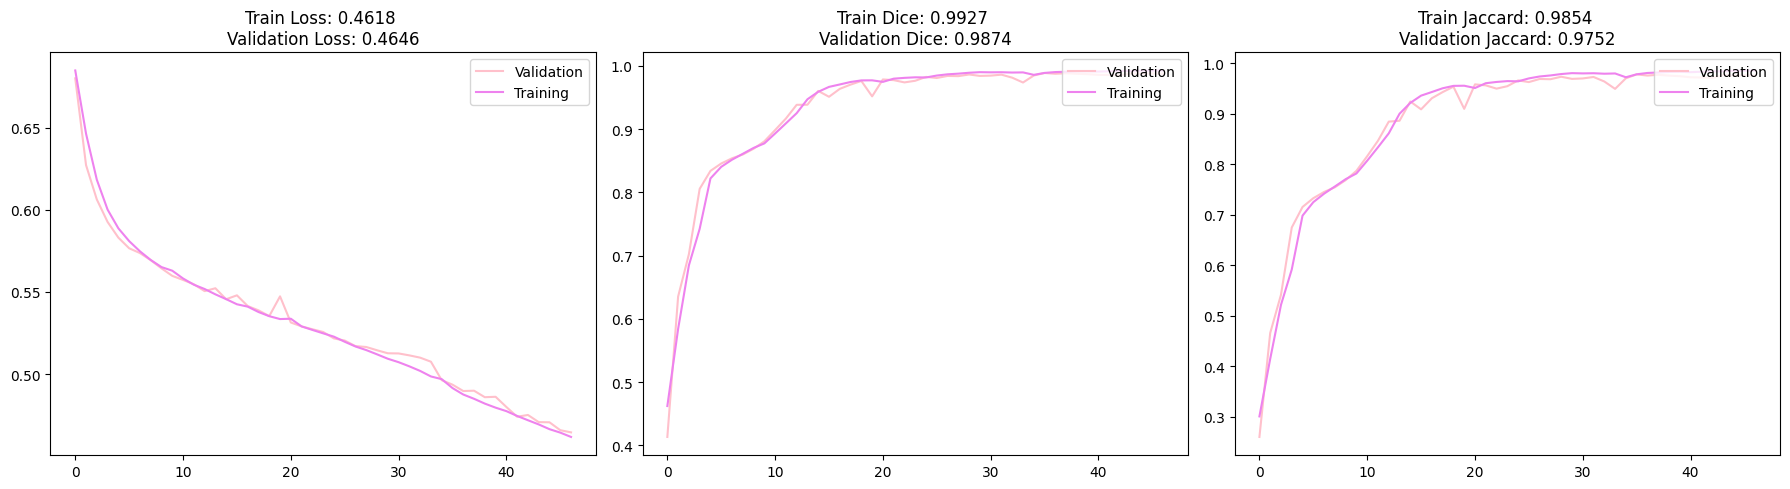

train epoch 48/70: 100%|██████████| 38/38 [00:27<00:00,  1.37it/s]


Loss: 0.4593 | Dice: 0.9928 | IoU: 0.9858


val epoch 48/70: 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


Loss: 0.4614 | Dice: 0.9881 | IoU: 0.9766


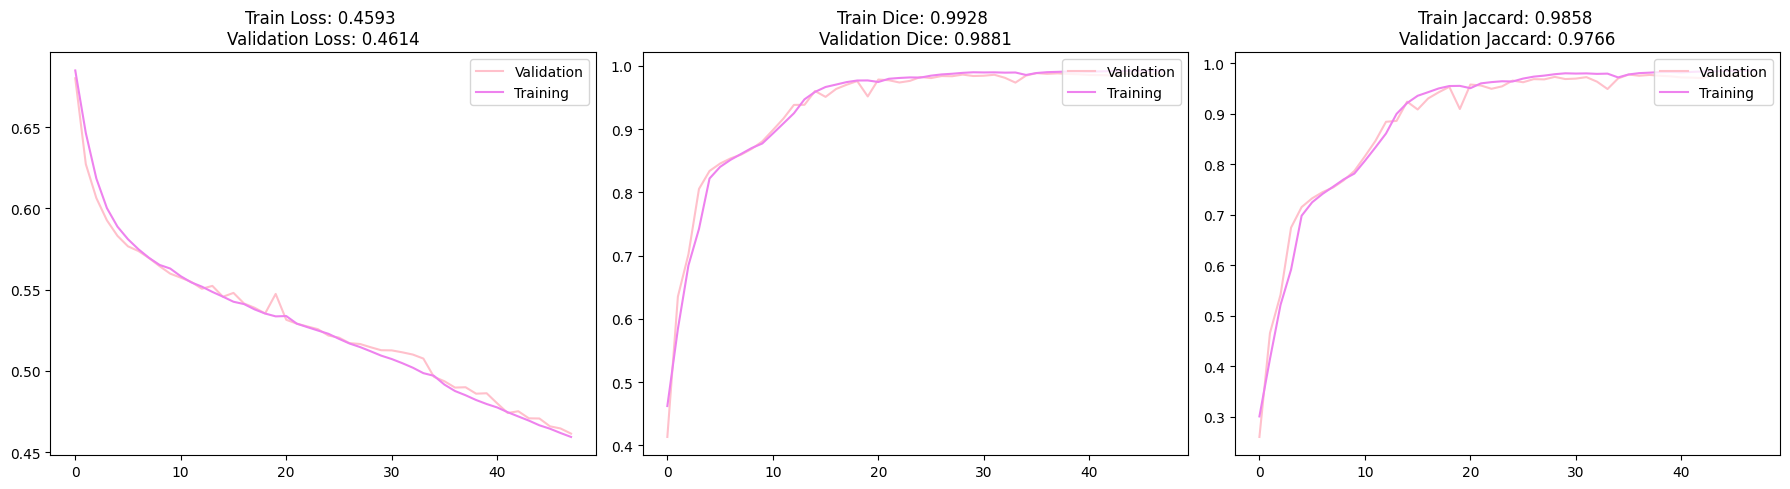

train epoch 49/70: 100%|██████████| 38/38 [00:27<00:00,  1.40it/s]


Loss: 0.4565 | Dice: 0.9931 | IoU: 0.9864


val epoch 49/70: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


Loss: 0.4620 | Dice: 0.9872 | IoU: 0.9748


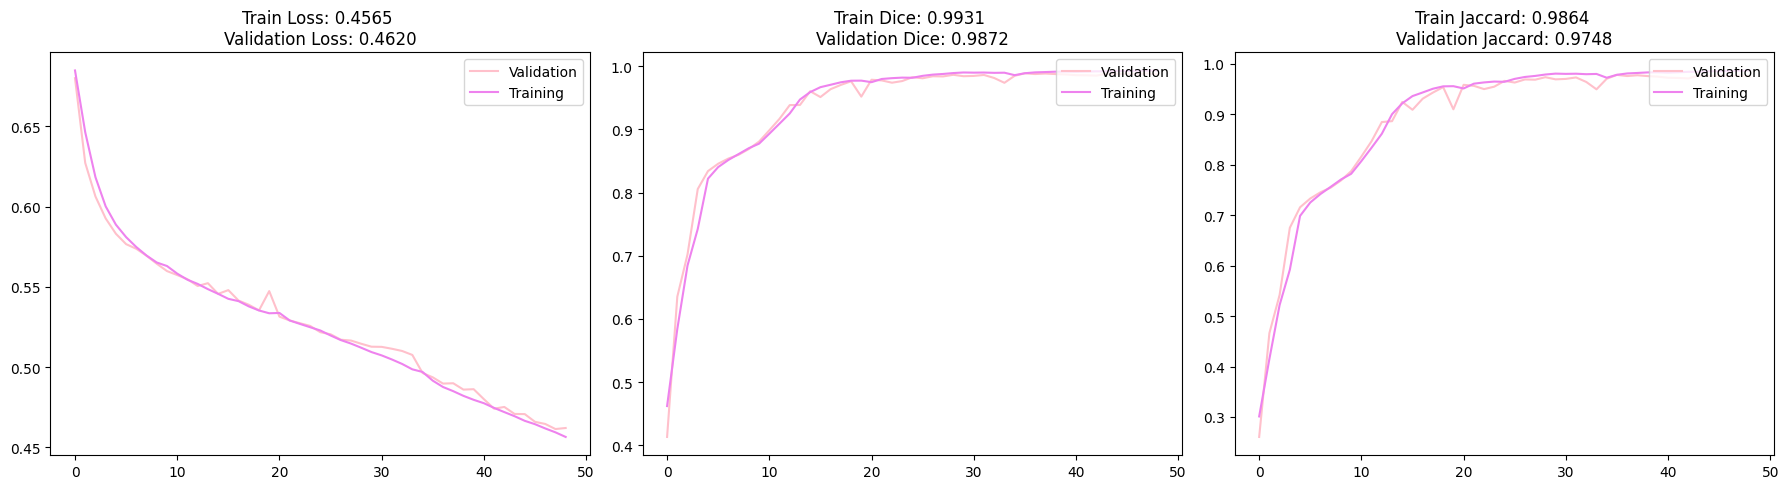

train epoch 50/70: 100%|██████████| 38/38 [00:26<00:00,  1.41it/s]


Loss: 0.4549 | Dice: 0.9923 | IoU: 0.9848


val epoch 50/70: 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]


Loss: 0.4566 | Dice: 0.9880 | IoU: 0.9765


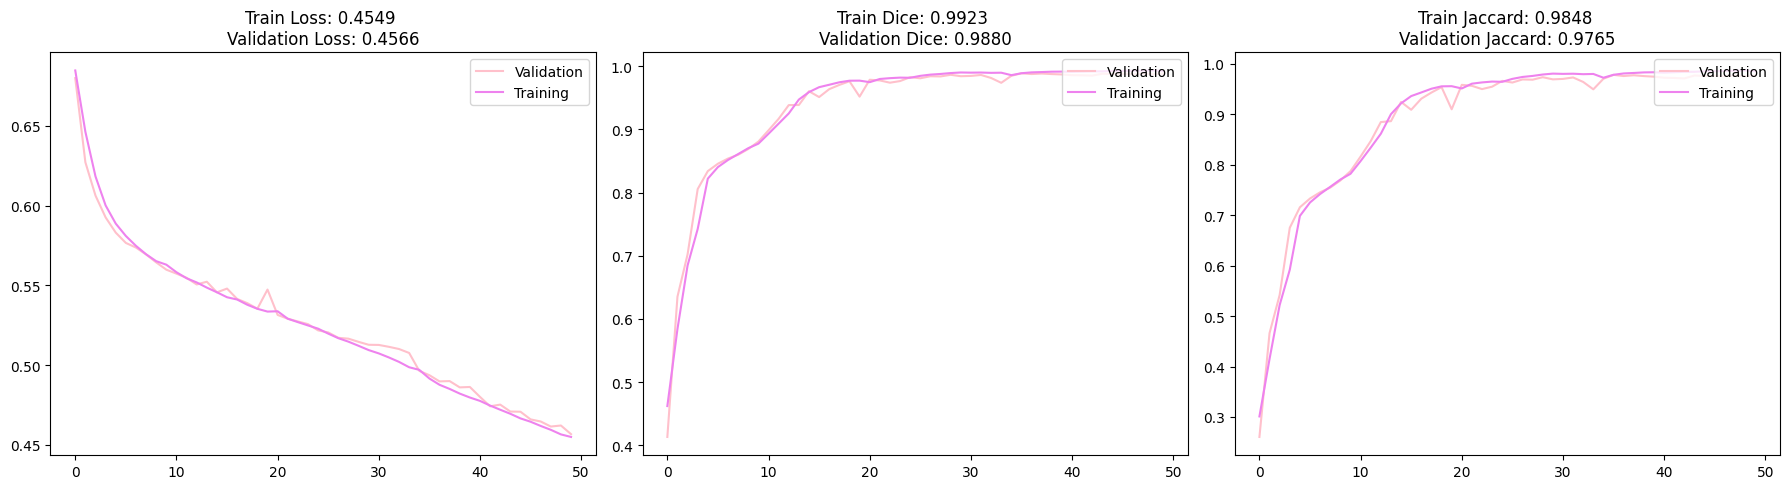

train epoch 51/70: 100%|██████████| 38/38 [00:27<00:00,  1.38it/s]


Loss: 0.4528 | Dice: 0.9922 | IoU: 0.9845


val epoch 51/70: 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]


Loss: 0.4556 | Dice: 0.9850 | IoU: 0.9707


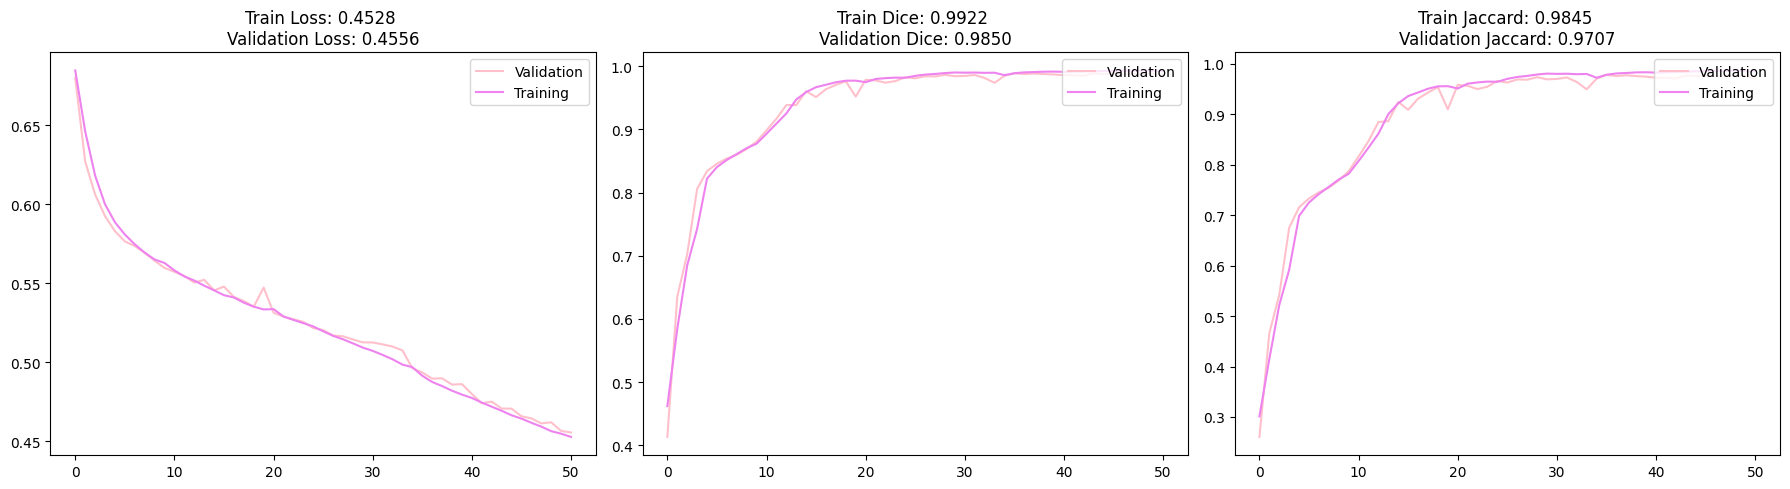

train epoch 52/70: 100%|██████████| 38/38 [00:27<00:00,  1.40it/s]


Loss: 0.4501 | Dice: 0.9915 | IoU: 0.9832


val epoch 52/70: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


Loss: 0.4524 | Dice: 0.9863 | IoU: 0.9732


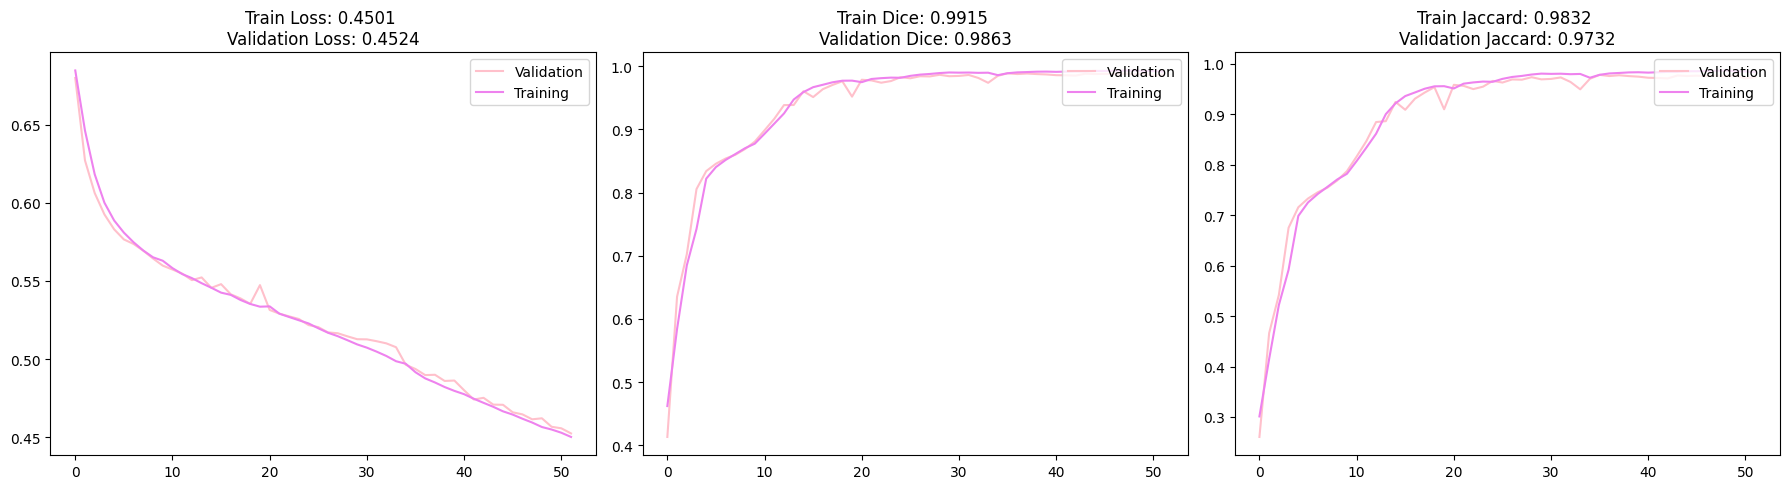

train epoch 53/70: 100%|██████████| 38/38 [00:27<00:00,  1.37it/s]


Loss: 0.4467 | Dice: 0.9925 | IoU: 0.9851


val epoch 53/70: 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


Loss: 0.4512 | Dice: 0.9821 | IoU: 0.9650


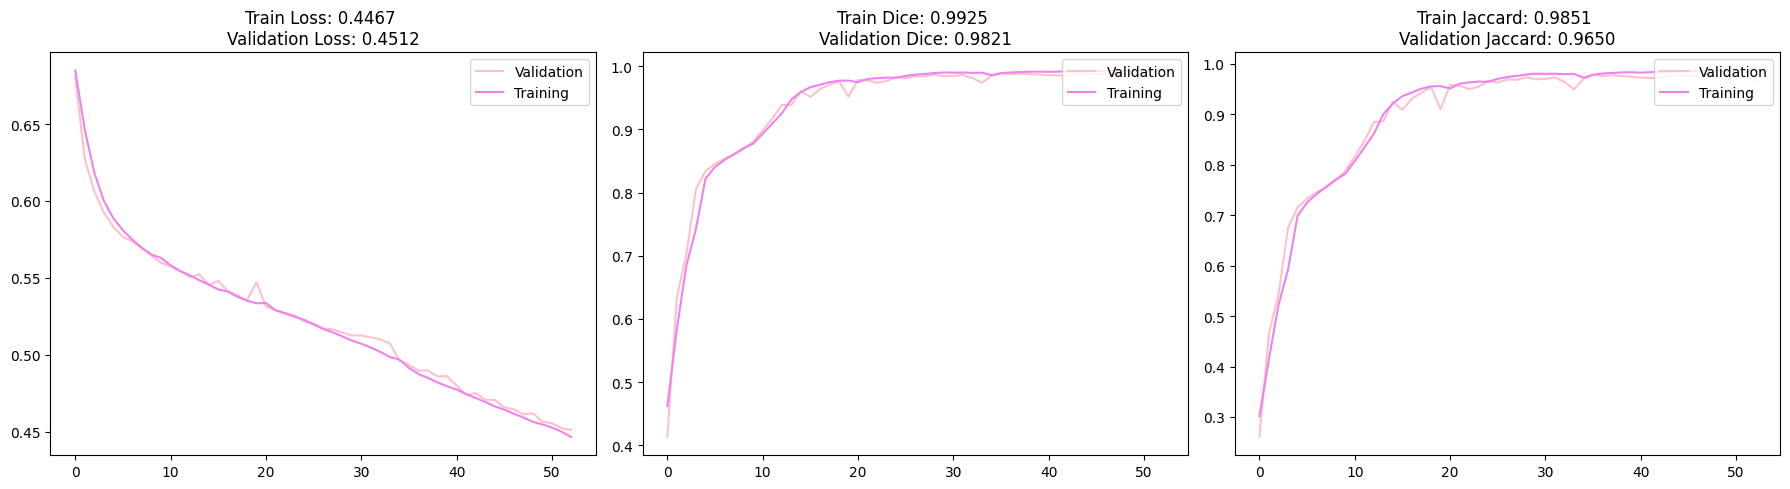

train epoch 54/70: 100%|██████████| 38/38 [00:27<00:00,  1.37it/s]


Loss: 0.4443 | Dice: 0.9919 | IoU: 0.9839


val epoch 54/70: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


Loss: 0.4499 | Dice: 0.9810 | IoU: 0.9633


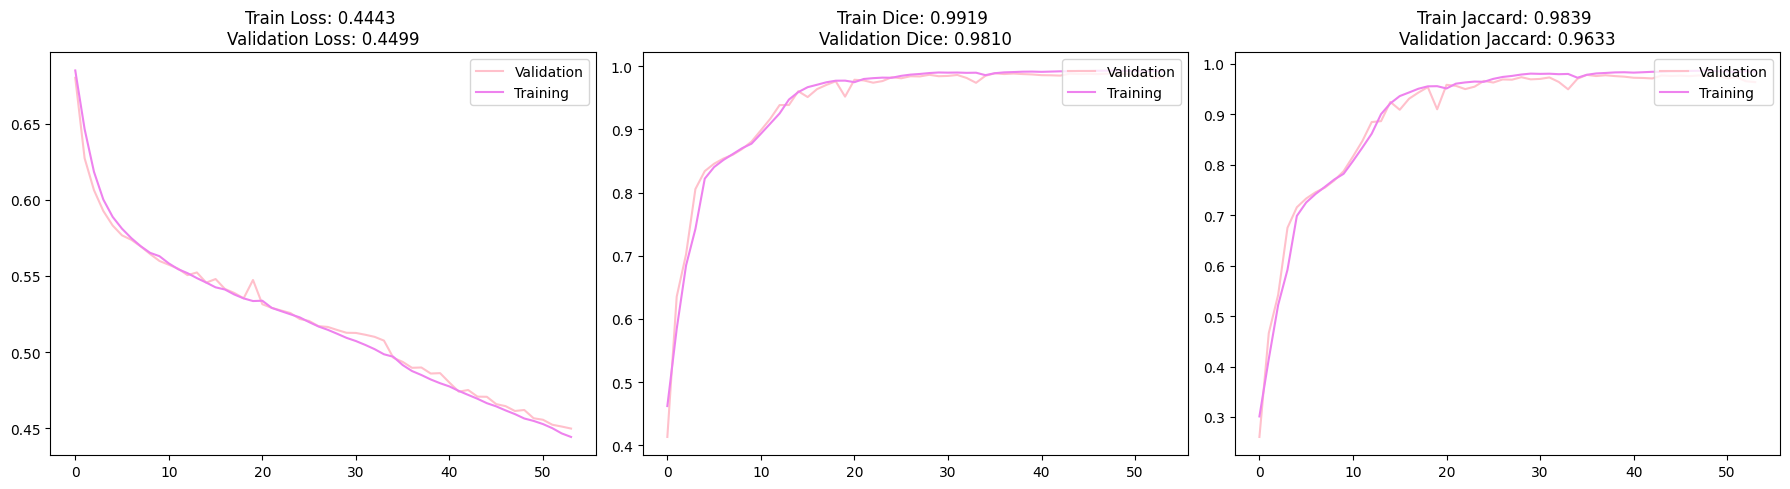

train epoch 55/70: 100%|██████████| 38/38 [00:27<00:00,  1.38it/s]


Loss: 0.4421 | Dice: 0.9923 | IoU: 0.9848


val epoch 55/70: 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]


Loss: 0.4460 | Dice: 0.9857 | IoU: 0.9720


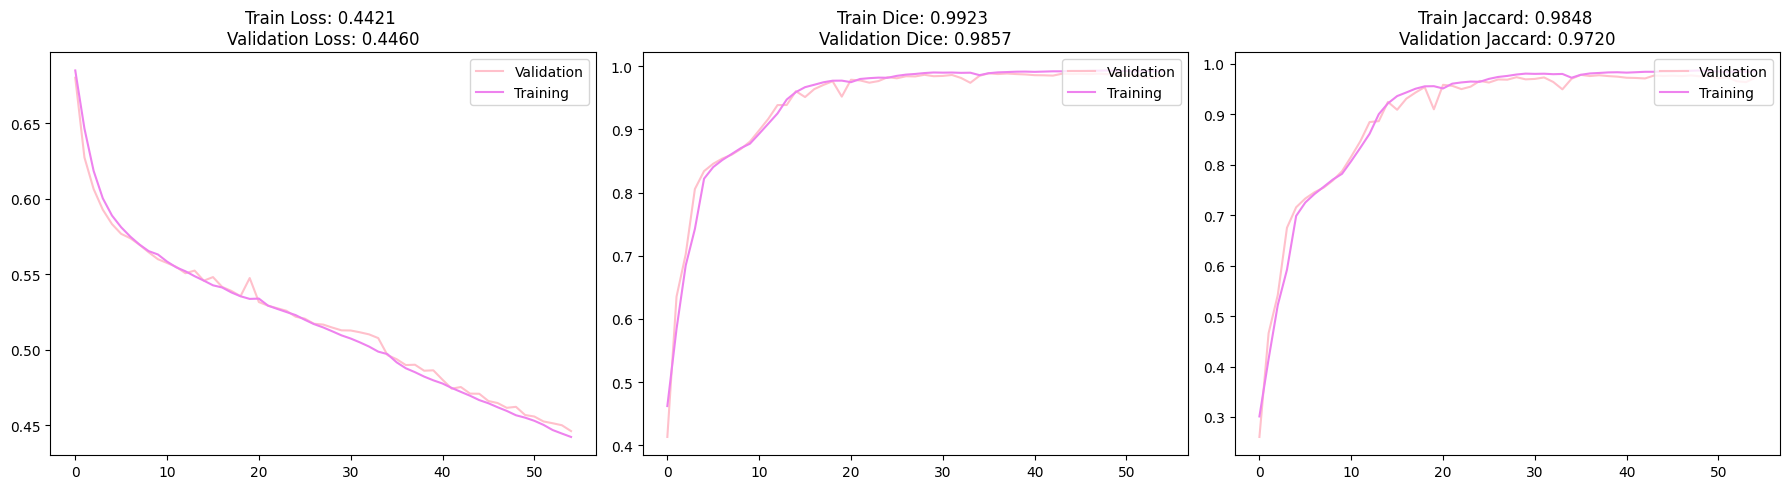

train epoch 56/70: 100%|██████████| 38/38 [00:27<00:00,  1.38it/s]


Loss: 0.4391 | Dice: 0.9928 | IoU: 0.9857


val epoch 56/70: 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


Loss: 0.4401 | Dice: 0.9868 | IoU: 0.9740


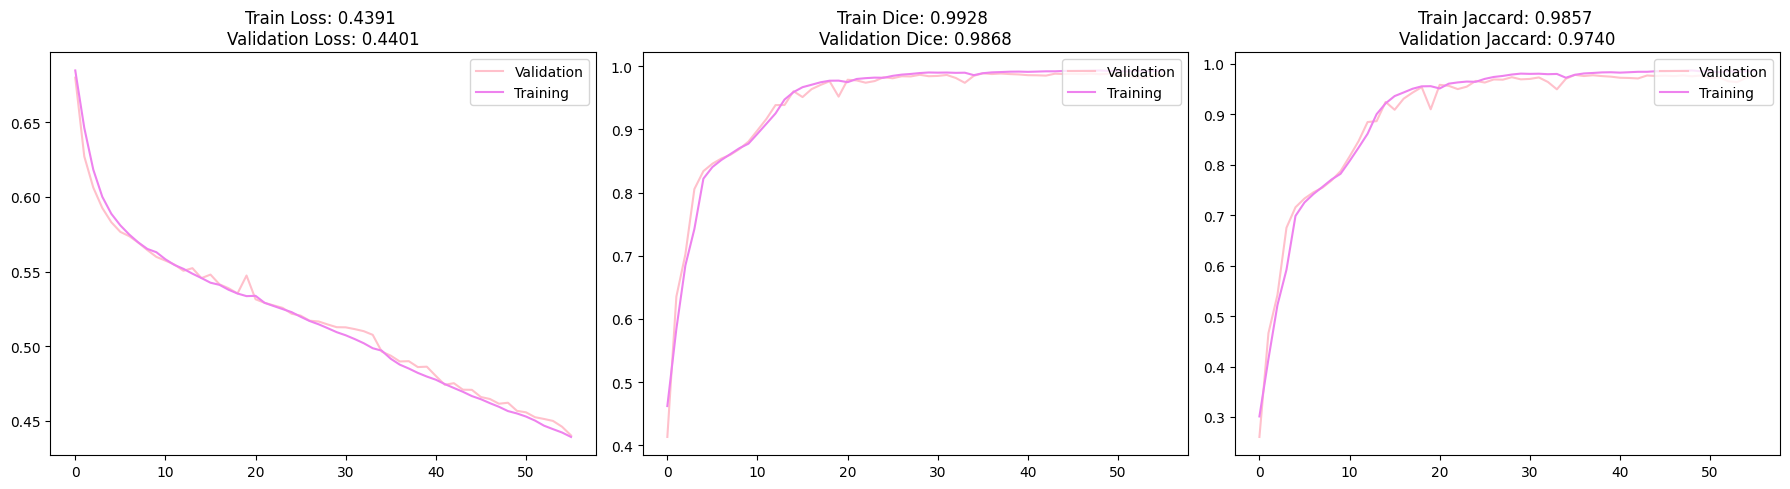

train epoch 57/70: 100%|██████████| 38/38 [00:27<00:00,  1.40it/s]


Loss: 0.4368 | Dice: 0.9933 | IoU: 0.9866


val epoch 57/70: 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


Loss: 0.4384 | Dice: 0.9875 | IoU: 0.9755


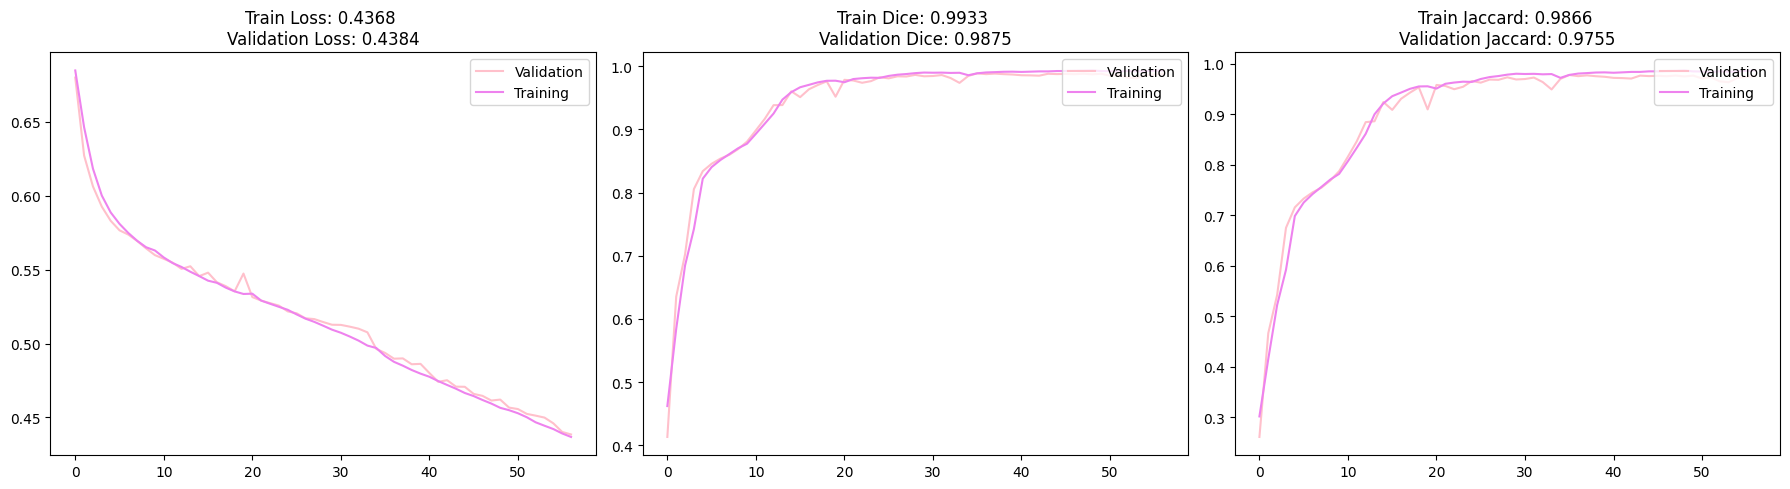

train epoch 58/70: 100%|██████████| 38/38 [00:27<00:00,  1.37it/s]


Loss: 0.4345 | Dice: 0.9932 | IoU: 0.9864


val epoch 58/70: 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


Loss: 0.4383 | Dice: 0.9859 | IoU: 0.9722


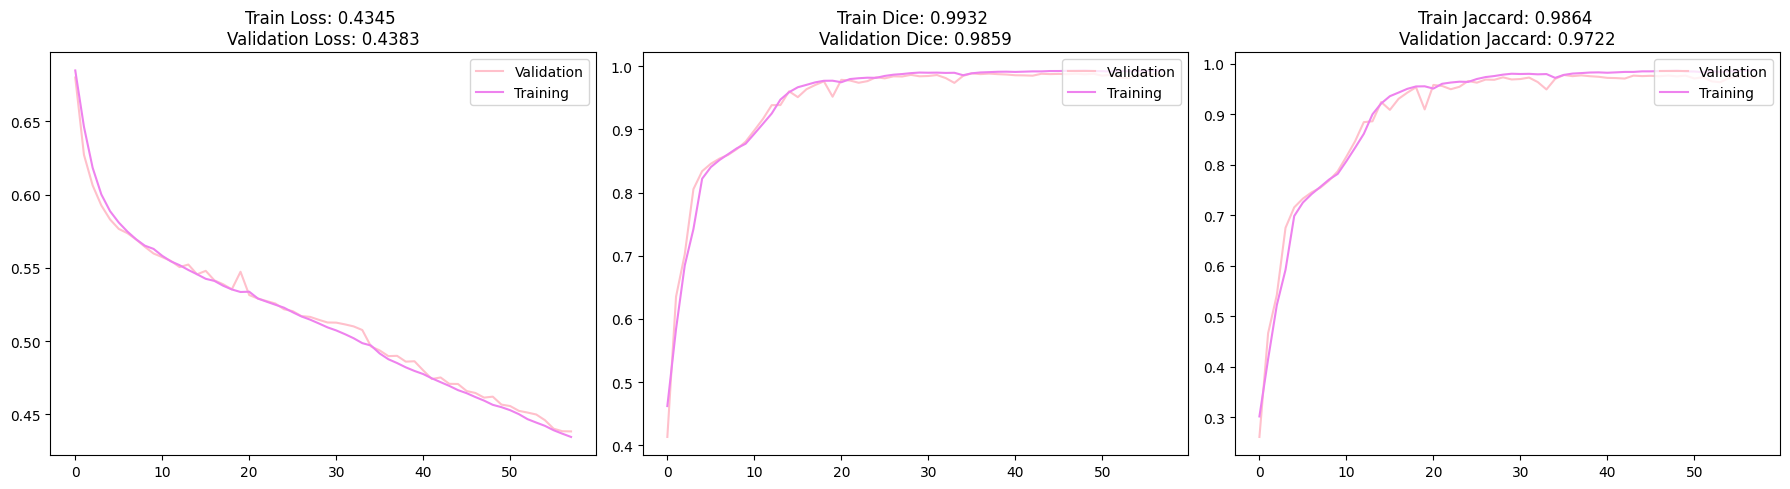

train epoch 59/70: 100%|██████████| 38/38 [00:27<00:00,  1.39it/s]


Loss: 0.4329 | Dice: 0.9921 | IoU: 0.9843


val epoch 59/70: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


Loss: 0.4349 | Dice: 0.9873 | IoU: 0.9751


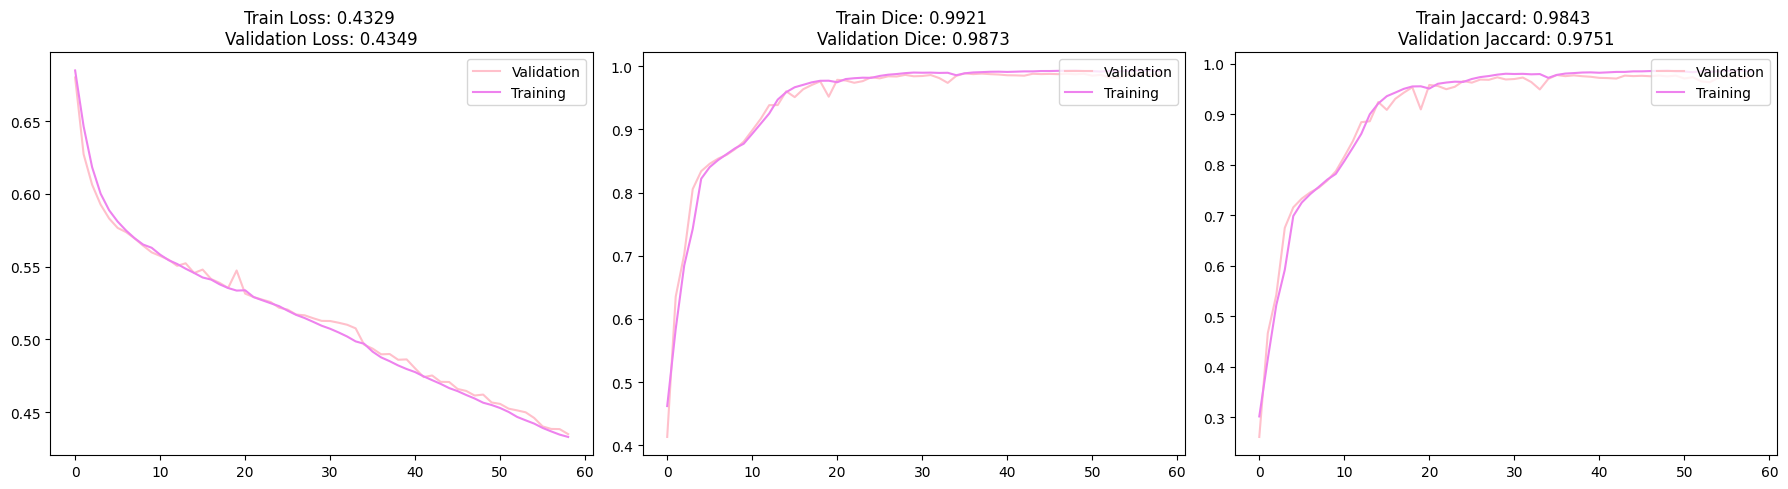

train epoch 60/70: 100%|██████████| 38/38 [00:27<00:00,  1.38it/s]


Loss: 0.4297 | Dice: 0.9932 | IoU: 0.9866


val epoch 60/70: 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


Loss: 0.4320 | Dice: 0.9876 | IoU: 0.9757


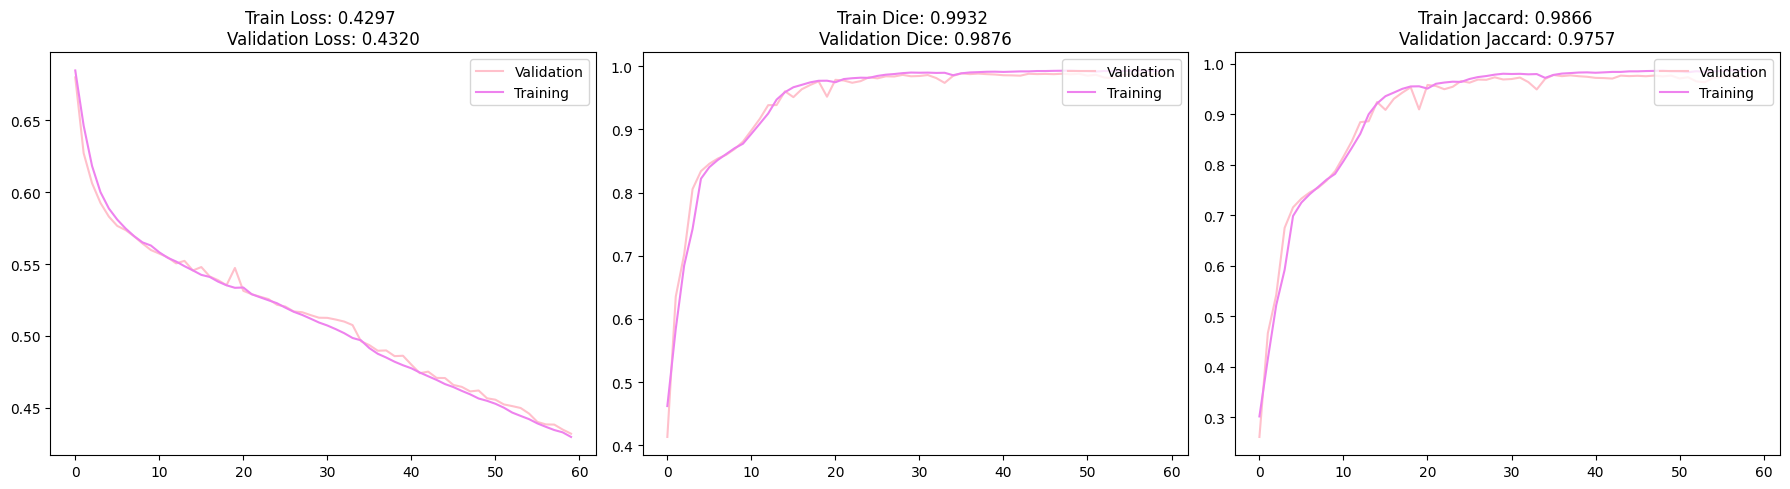

train epoch 61/70: 100%|██████████| 38/38 [00:27<00:00,  1.37it/s]


Loss: 0.4275 | Dice: 0.9935 | IoU: 0.9872


val epoch 61/70: 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


Loss: 0.4308 | Dice: 0.9870 | IoU: 0.9744


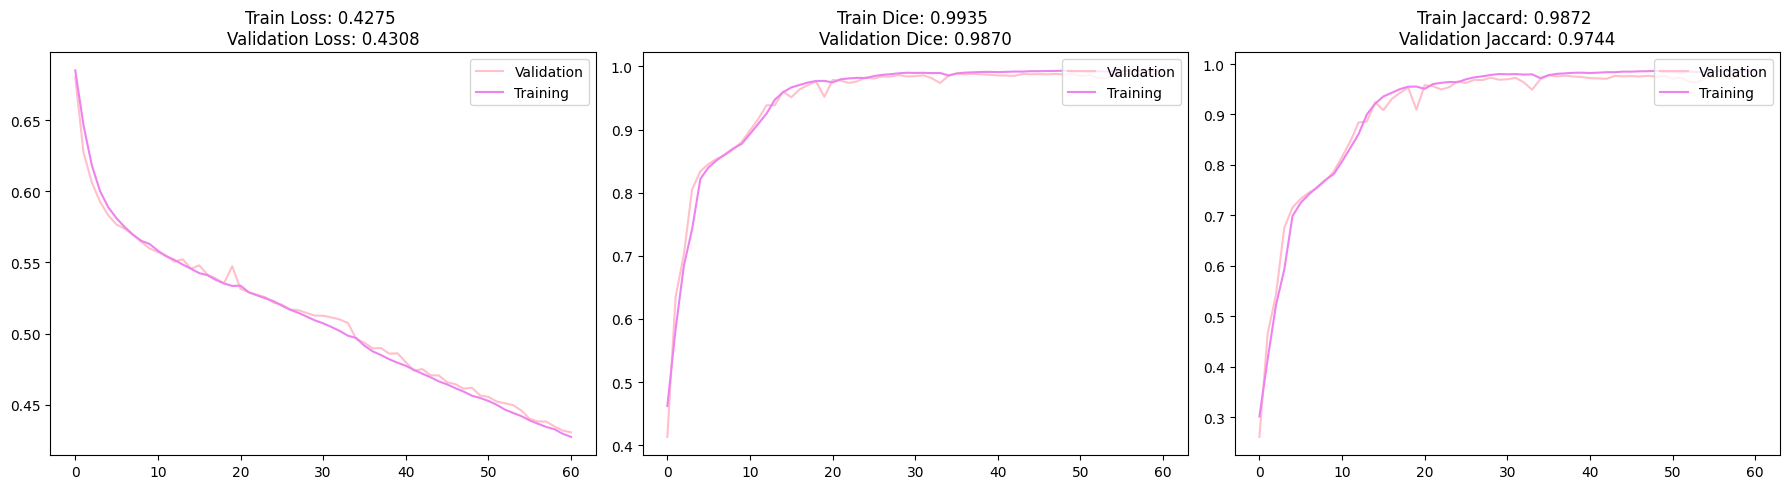

train epoch 62/70: 100%|██████████| 38/38 [00:27<00:00,  1.40it/s]


Loss: 0.4253 | Dice: 0.9936 | IoU: 0.9872


val epoch 62/70: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


Loss: 0.4298 | Dice: 0.9874 | IoU: 0.9753


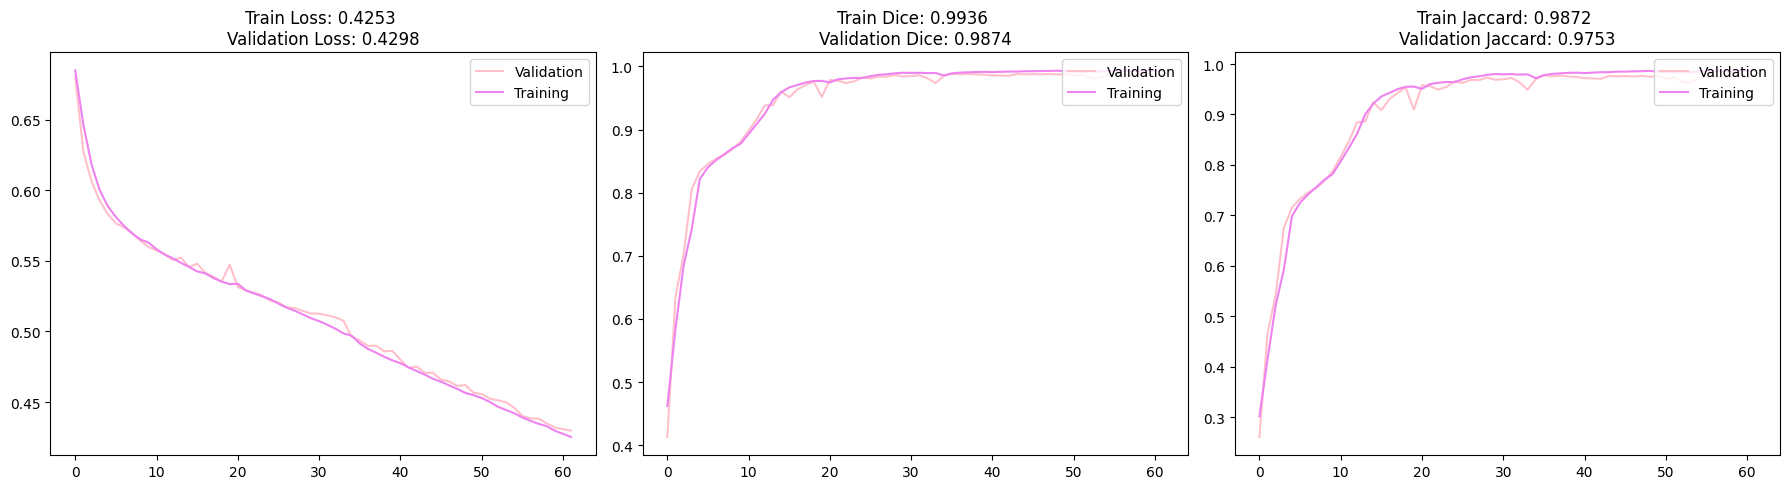

train epoch 63/70: 100%|██████████| 38/38 [00:28<00:00,  1.34it/s]


Loss: 0.4245 | Dice: 0.9926 | IoU: 0.9854


val epoch 63/70: 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]


Loss: 0.4264 | Dice: 0.9875 | IoU: 0.9754


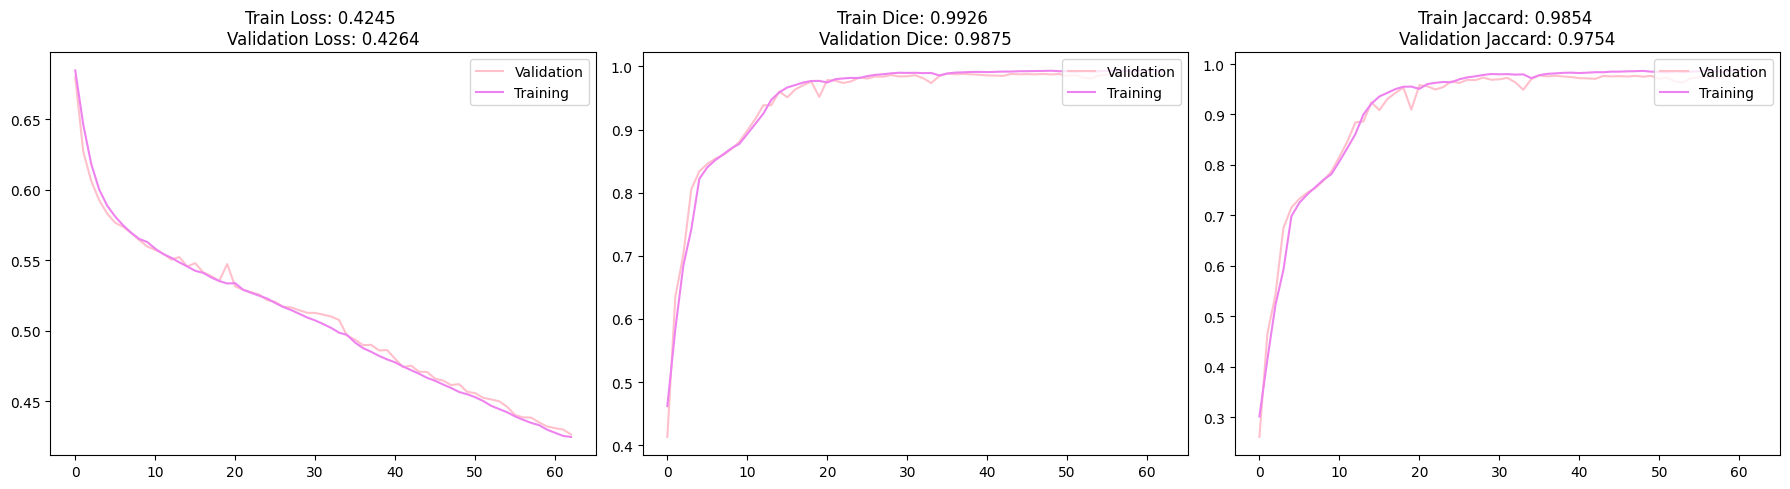

train epoch 64/70: 100%|██████████| 38/38 [00:27<00:00,  1.38it/s]


Loss: 0.4217 | Dice: 0.9926 | IoU: 0.9852


val epoch 64/70: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


Loss: 0.4241 | Dice: 0.9870 | IoU: 0.9745


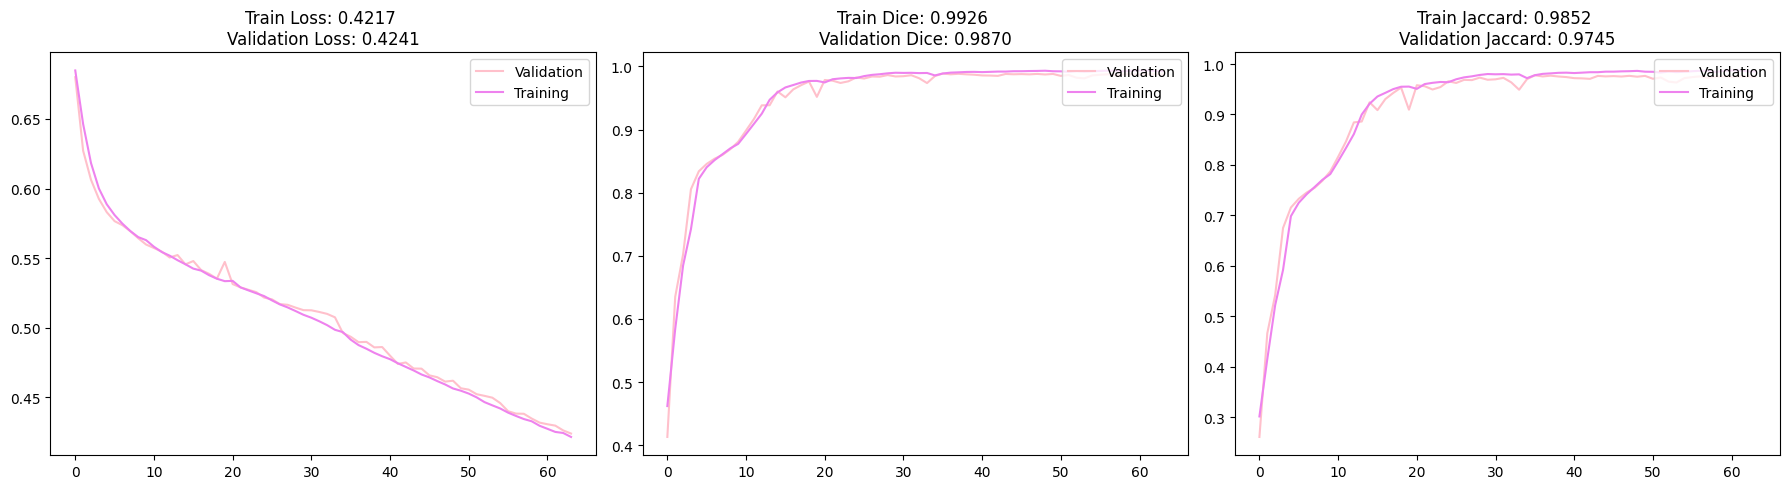

train epoch 65/70: 100%|██████████| 38/38 [00:27<00:00,  1.40it/s]


Loss: 0.4190 | Dice: 0.9932 | IoU: 0.9865


val epoch 65/70: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]


Loss: 0.4214 | Dice: 0.9878 | IoU: 0.9760


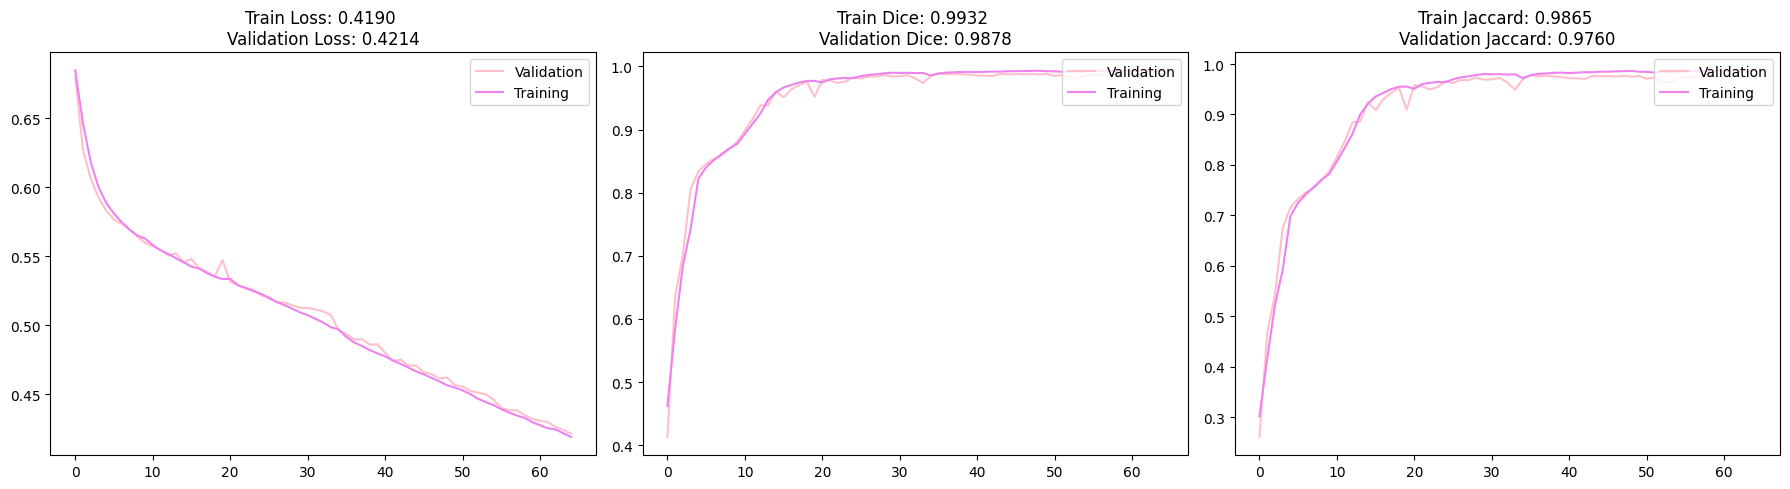

train epoch 66/70: 100%|██████████| 38/38 [00:27<00:00,  1.39it/s]


Loss: 0.4174 | Dice: 0.9934 | IoU: 0.9869


val epoch 66/70: 100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


Loss: 0.4203 | Dice: 0.9871 | IoU: 0.9747


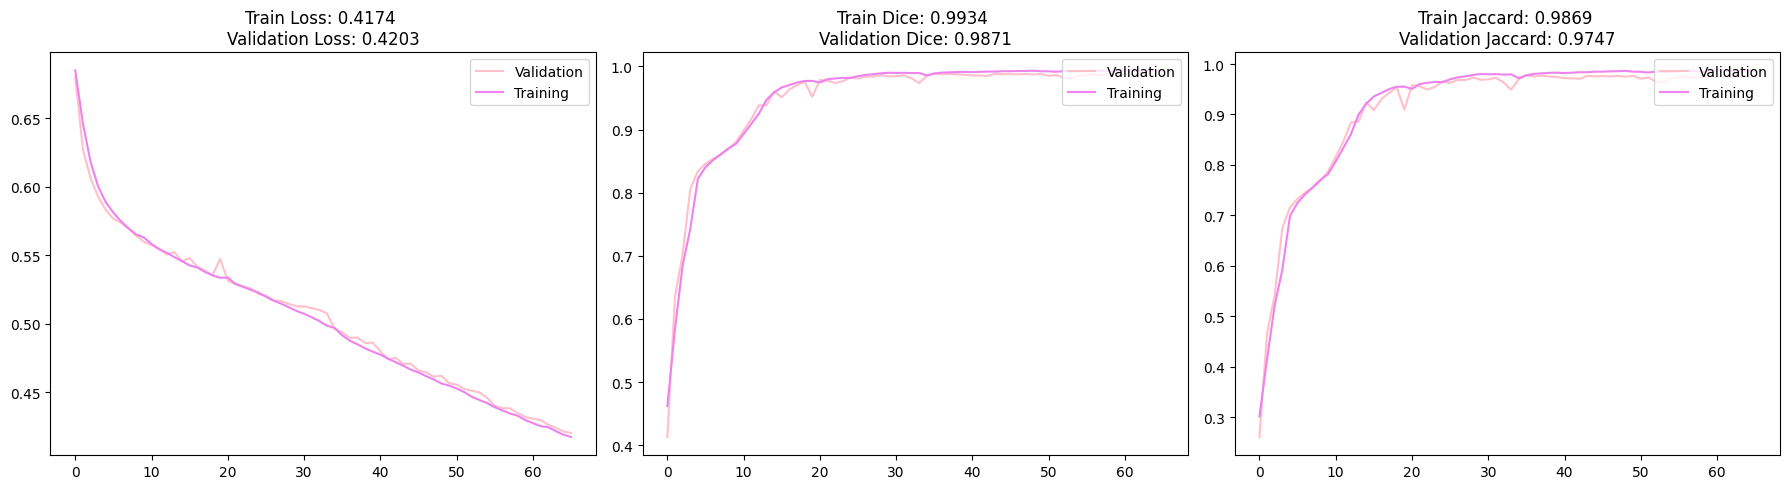

train epoch 67/70: 100%|██████████| 38/38 [00:27<00:00,  1.37it/s]


Loss: 0.4143 | Dice: 0.9940 | IoU: 0.9880


val epoch 67/70: 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


Loss: 0.4175 | Dice: 0.9880 | IoU: 0.9764


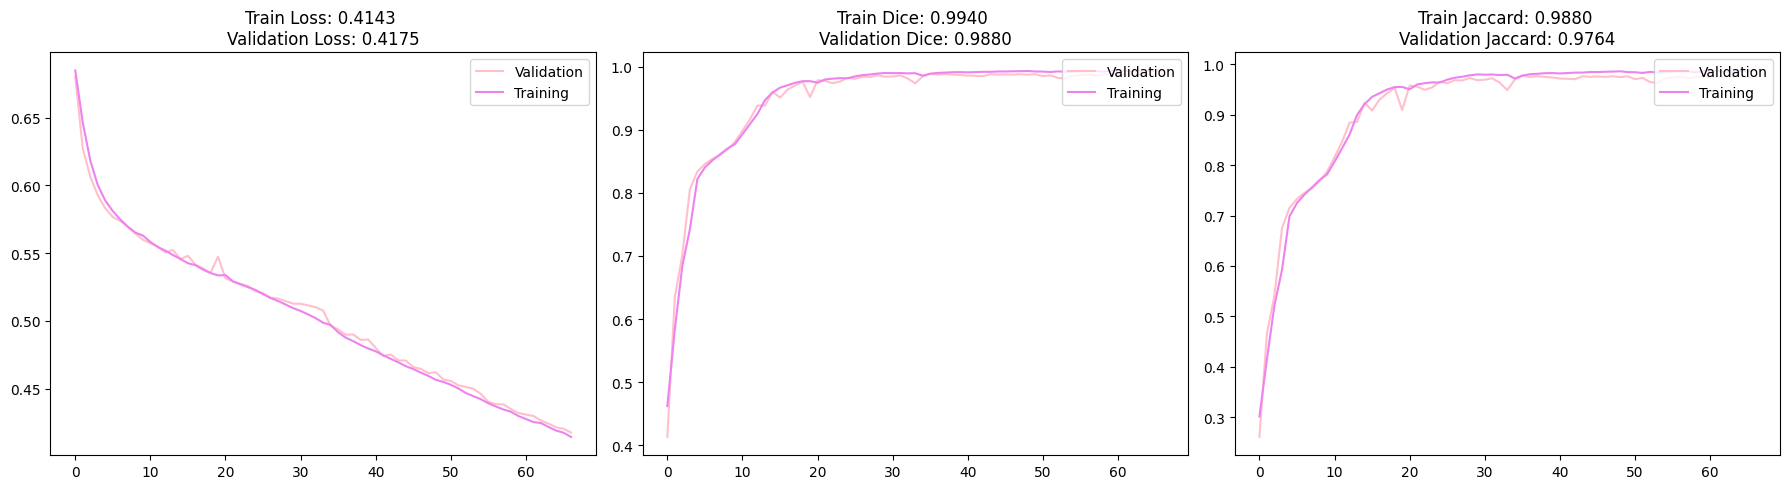

train epoch 68/70: 100%|██████████| 38/38 [00:27<00:00,  1.37it/s]


Loss: 0.4128 | Dice: 0.9936 | IoU: 0.9873


val epoch 68/70: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]


Loss: 0.4171 | Dice: 0.9864 | IoU: 0.9733


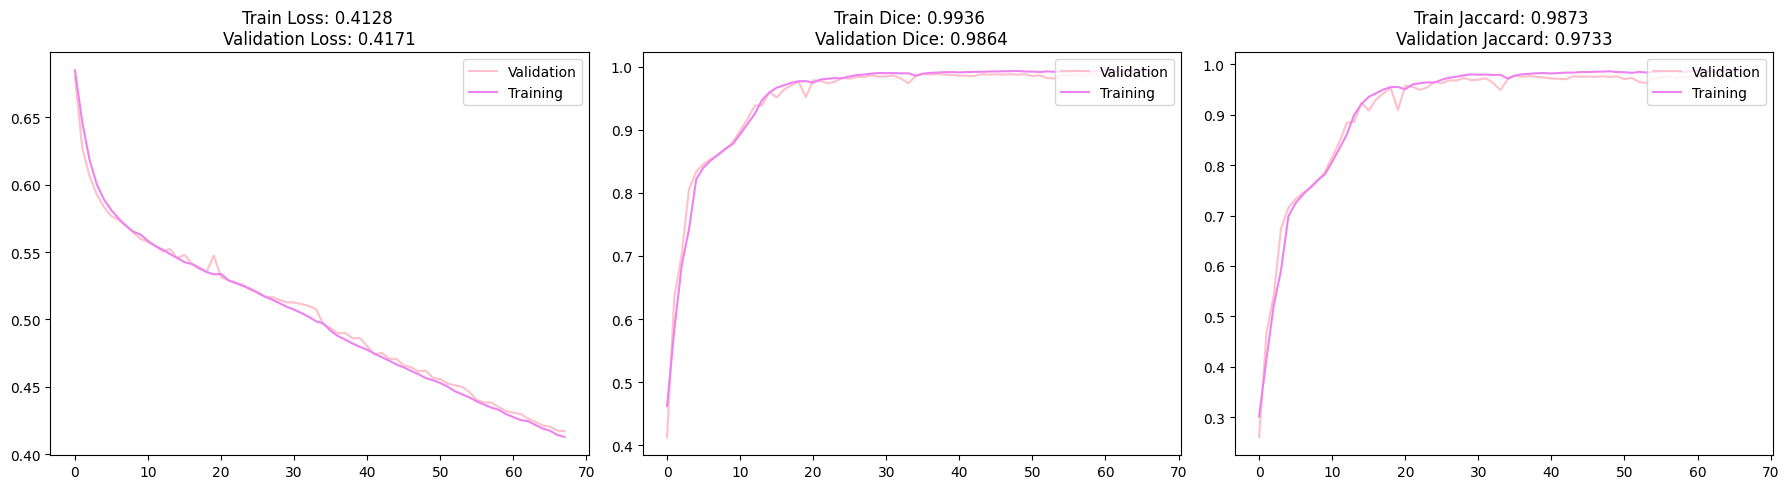

train epoch 69/70: 100%|██████████| 38/38 [00:27<00:00,  1.37it/s]


Loss: 0.4109 | Dice: 0.9922 | IoU: 0.9846


val epoch 69/70: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]


Loss: 0.4114 | Dice: 0.9868 | IoU: 0.9742


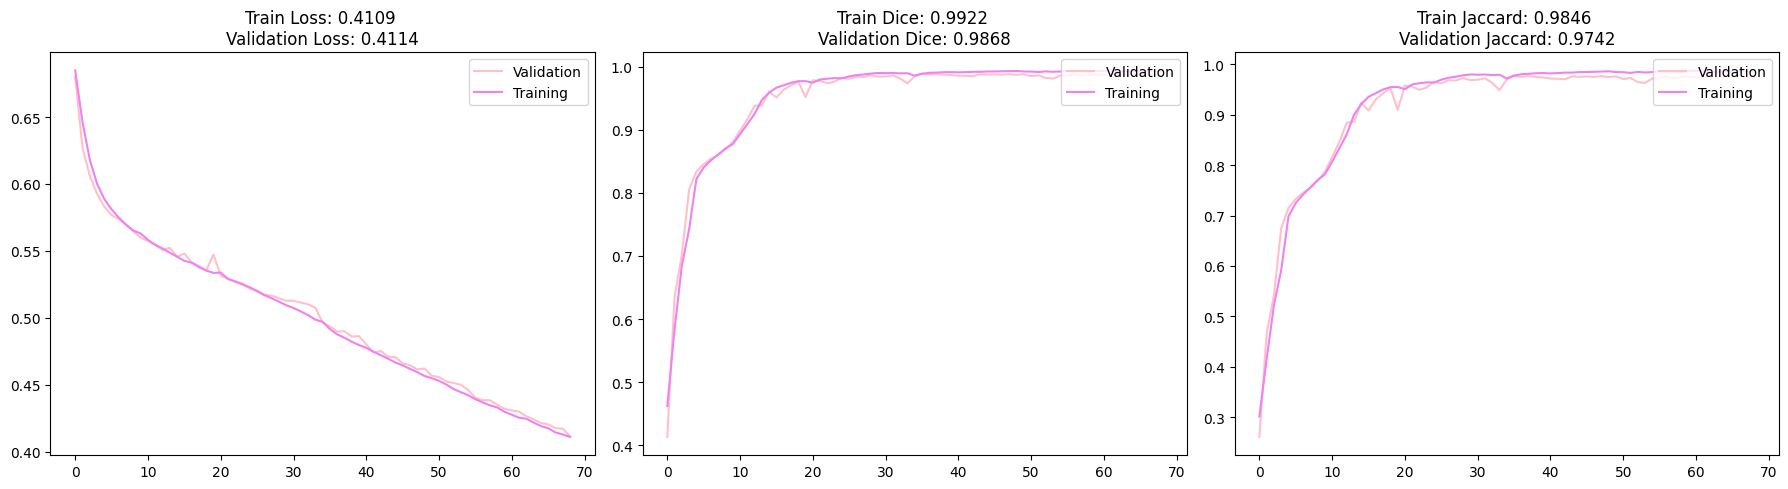

train epoch 70/70: 100%|██████████| 38/38 [00:27<00:00,  1.40it/s]


Loss: 0.4081 | Dice: 0.9931 | IoU: 0.9864


val epoch 70/70: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]


Loss: 0.4108 | Dice: 0.9866 | IoU: 0.9737


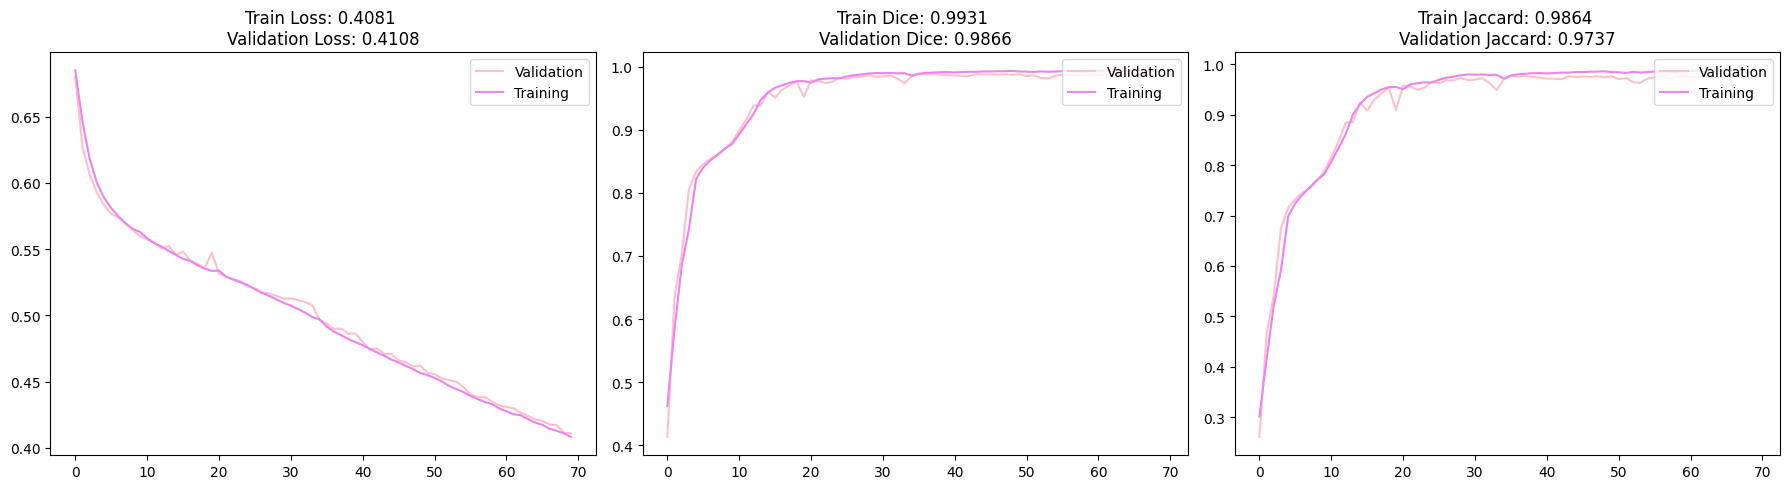


CPU times: user 29min 41s, sys: 1min 24s, total: 31min 6s
Wall time: 45min 10s


In [17]:
%%time
trainer.run()

In [18]:
def coef_metric_per_classes(probabilities, truth, threshold=0.5, eps=1e-9, classes=['WT', 'TC', 'ET', 'BG'], metric='dice'):
    scores = {key: [] for key in classes}
    predictions = (probabilities >= threshold).astype(np.float32)

    for i in range(probabilities.shape[0]):
        for class_, class_name in enumerate(classes):
            prediction = predictions[i, class_]
            truth_ = truth[i, class_]

            if metric == 'dice':
                intersection = 2.0 * np.sum(truth_ * prediction)
                union = np.sum(truth_) + np.sum(prediction)
            elif metric == 'jaccard':
                intersection = np.sum(prediction * truth_)
                union = np.sum(prediction) + np.sum(truth_) - intersection + eps
            else:
                raise ValueError("Unsupported metric. Use 'dice' or 'jaccard'.")

            if np.sum(truth_) == 0 and np.sum(prediction) == 0:
                scores[class_name].append(1.0)
            else:
                scores[class_name].append((intersection + eps) / (union + eps))

    return scores

def compute_scores_per_classes(model, dataloader, classes):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}
    loss_per_batch = []

    criterion = bce_dice_loss  # Use the appropriate loss function

    with torch.no_grad():
        for i, (imgs, targets) in enumerate(dataloader):
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs.float())

            # Compute loss
            loss = criterion(logits, targets, alpha=0.5, beta=0.5)
            loss_per_batch.append(loss.item())

            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()

            dice_scores = coef_metric_per_classes(logits, targets, metric='dice')
            iou_scores = coef_metric_per_classes(logits, targets, metric='jaccard')

            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    average_loss = sum(loss_per_batch) / len(loss_per_batch)

    return average_loss, dice_scores_per_classes, iou_scores_per_classes

In [19]:
model.eval();

In [20]:
average_test_loss, dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(model, test_dl, ['WT', 'TC', 'ET', 'BG'])

print(f"Average Test Loss: {average_test_loss:.4f}\n")

for key in dice_scores_per_classes.keys():
    print(f"Average Test Dice ({key}): {np.mean(dice_scores_per_classes[key]):.4f}")
print("\t")
for key in iou_scores_per_classes.keys():
    print(f"Average Test Jaccard ({key}): {np.mean(iou_scores_per_classes[key]):.4f}")

Average Test Loss: 0.4120

Average Test Dice (WT): 0.8083
Average Test Dice (TC): 0.7454
Average Test Dice (ET): 0.8889
Average Test Dice (BG): 0.9917
	
Average Test Jaccard (WT): 0.8070
Average Test Jaccard (TC): 0.6301
Average Test Jaccard (ET): 0.8889
Average Test Jaccard (BG): 0.9836


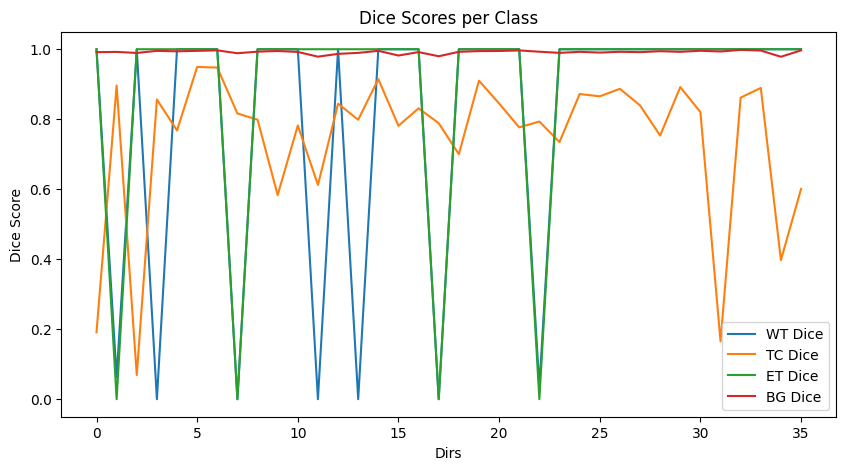

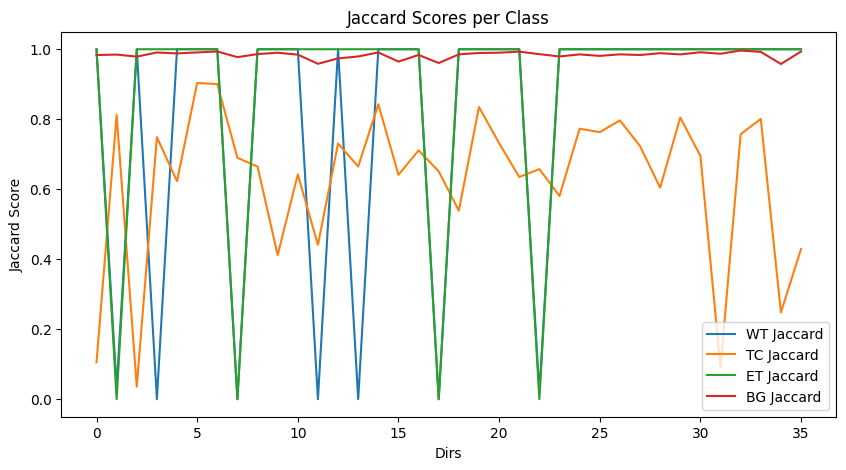

In [21]:
# Plot the Dice scores
plt.figure(figsize=(10, 5))
for key in dice_scores_per_classes.keys():
    plt.plot(dice_scores_per_classes[key], label=f'{key} Dice')
plt.title('Dice Scores per Class')
plt.xlabel('Dirs')
plt.ylabel('Dice Score')
plt.legend()
plt.show()

# Plot the Jaccard scores
plt.figure(figsize=(10, 5))
for key in iou_scores_per_classes.keys():
    plt.plot(iou_scores_per_classes[key], label=f'{key} Jaccard')
plt.title('Jaccard Scores per Class')
plt.xlabel('Dirs')
plt.ylabel('Jaccard Score')
plt.legend()
plt.show()


In [22]:
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['WT dice', 'TC dice', 'ET dice', 'BG dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard', 'BG jaccard']
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['WT dice', 'WT jaccard',
                                      'TC dice', 'TC jaccard',
                                      'ET dice', 'ET jaccard',
                                      'BG dice', 'BG jaccard']]
val_metics_df.sample(5)

WT dice  WT jaccard   TC dice  TC jaccard  ET dice  ET jaccard   BG dice  \
2       1.0         1.0  0.069063    0.035766      1.0         1.0  0.989344   
28      1.0         1.0  0.753372    0.604328      1.0         1.0  0.994289   
25      1.0         1.0  0.865509    0.762905      1.0         1.0  0.990398   
34      1.0         1.0  0.397339    0.247925      1.0         1.0  0.978458   
8       1.0         1.0  0.798641    0.664781      1.0         1.0  0.993024   

    BG jaccard  
2     0.978912  
28    0.988642  
25    0.980978  
34    0.957824  
8     0.986144

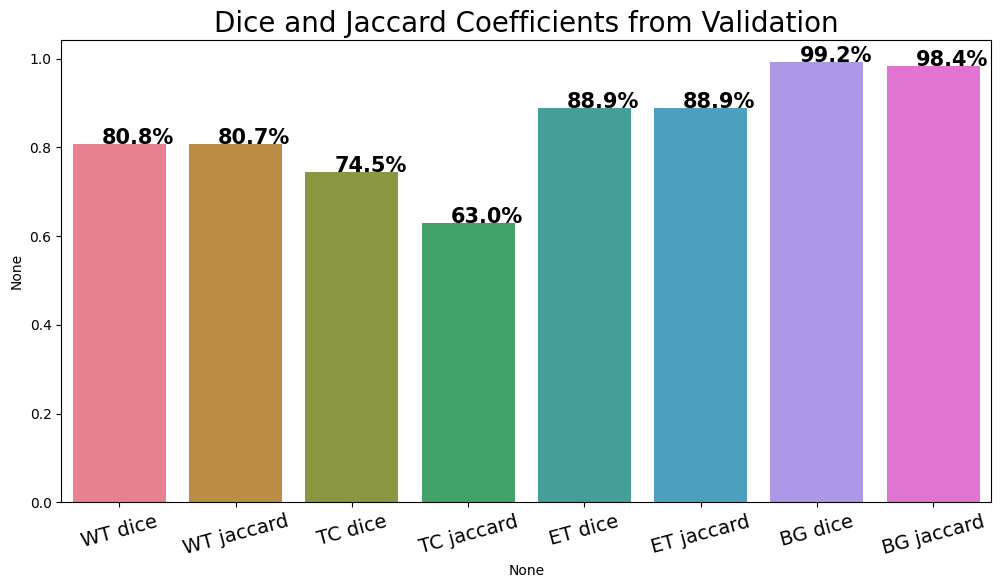

In [23]:
## Prosječne vrijednosti Dice i Jaccard koeficijenata za svaku od klasa na validacijskom skupu

unique_categories = val_metics_df.mean().index
palette = sns.color_palette("husl", len(unique_categories))

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), hue=val_metics_df.mean().index, palette=palette, ax=ax, legend=False)

ax.set_xticks(range(len(val_metics_df.mean().index)))
ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15)

ax.set_title("Dice and Jaccard Coefficients from Validation", fontsize=20)

for idx, p in enumerate(ax.patches):
    percentage = '{:.1f}%'.format(100 * val_metics_df.mean().values[idx])
    x = p.get_x() + p.get_width() / 2 - 0.15
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

fig.savefig("result1.png", format="png", pad_inches=0.2, transparent=False, bbox_inches='tight')

plt.show()

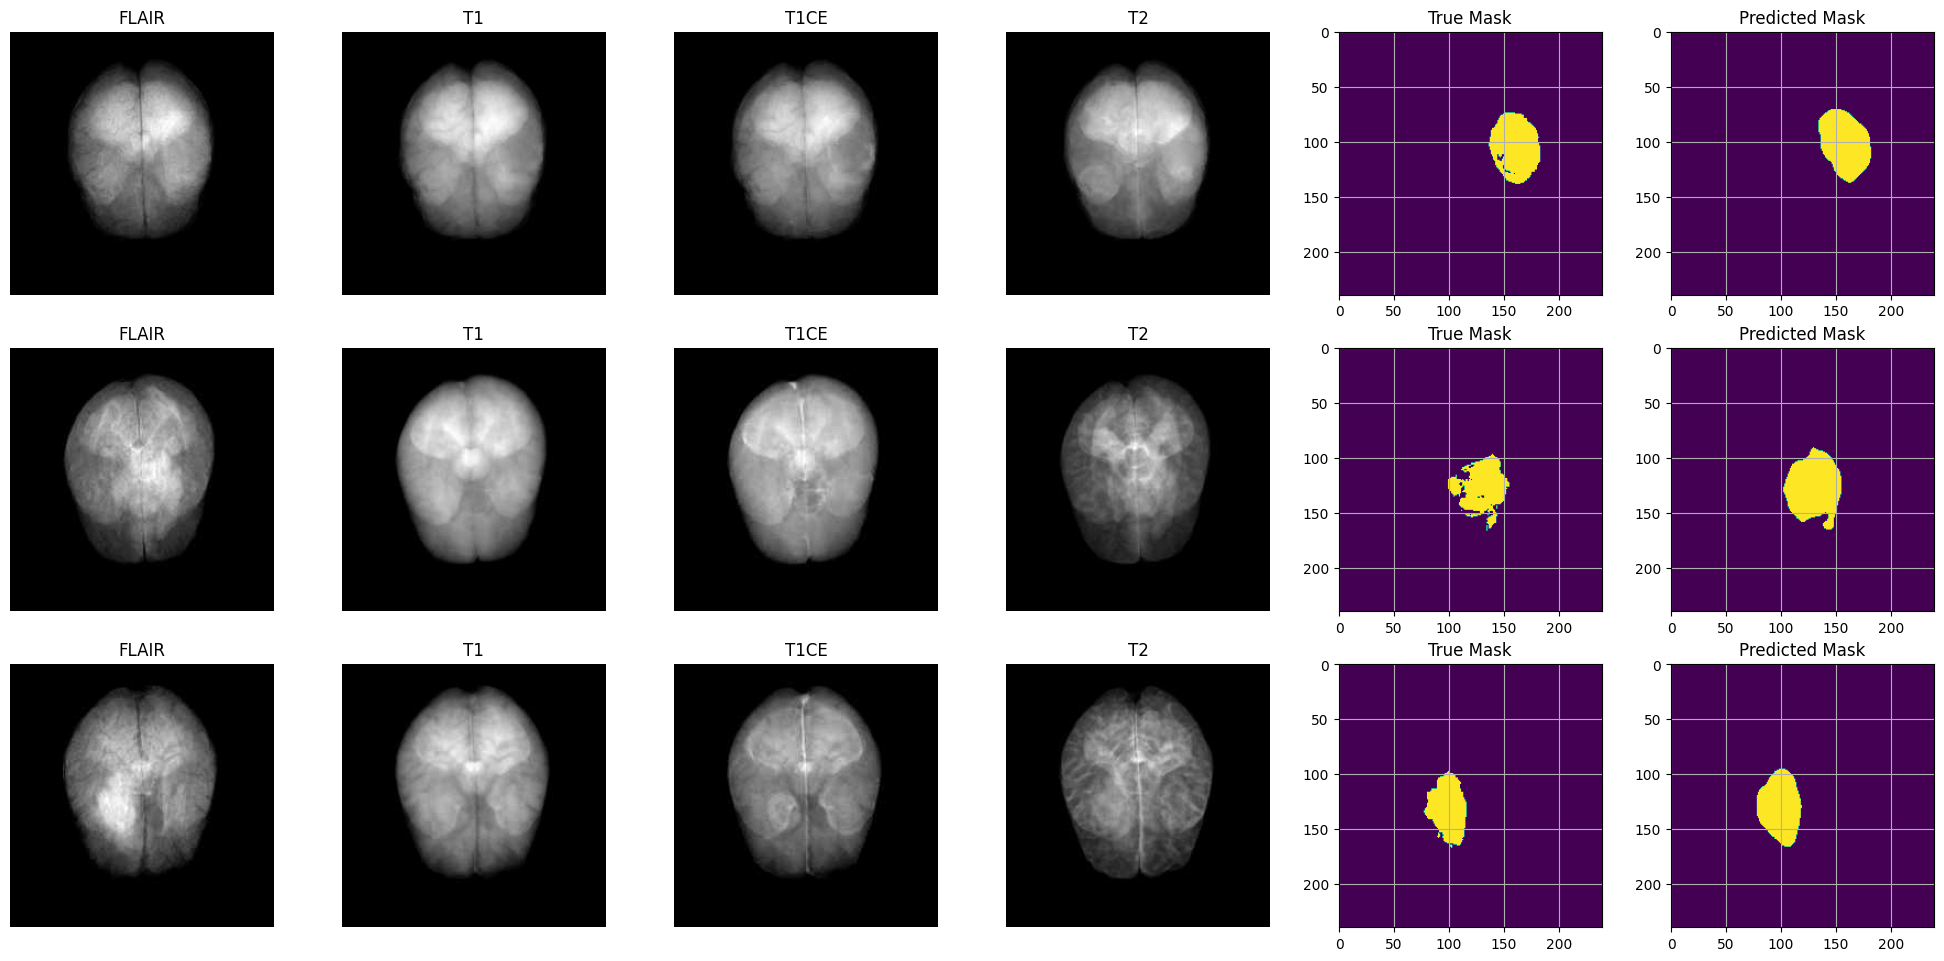

In [44]:
def show_results(model, test_dl):
    dl_iter = iter(test_dl)
    images, masks = next(dl_iter)

    images = images.to(device)
    masks = masks.to(device)
    outputs = model(images.float())

    preds = torch.argmax(outputs, dim=1)
    masks = torch.argmax(masks, dim=1)

    plt.figure(figsize=(25, 65))

    for i in range(3):
        for j in range(len(modality_types)):
            plt.subplot(16, 6, 6 * i + j + 1)
            plt.axis('off')
            plt.title(modality_types[j])
            plt.imshow(images[i][j].cpu(), cmap='gray')

        # show True Mask
        plt.subplot(16, 6, 6 * i + 5)
        plt.title('True Mask')
        plt.grid()
        plt.imshow(255 - masks[i].cpu(), cmap='viridis')

        # show Predicted Mask
        plt.subplot(16, 6, 6 * i + 6)
        plt.title('Predicted Mask')
        plt.grid()
        plt.imshow(255 - preds[i].cpu(), cmap='viridis')

    plt.show()

show_results(model, test_dl)